In [1]:
from datetime import timedelta
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models,transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader,random_split
from __future__ import print_function
import numpy as np 
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt 
from torch.autograd import Function
from collections import OrderedDict
import torch.nn as nn
import math
import torchvision.models as models
import pickle
from tqdm.auto import tqdm
import cv2
import wandb
from sklearn.model_selection import KFold
# from torchsummary import summary
import glob
from sklearn.manifold import TSNE
import seaborn as sns
import collections
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import umap.umap_ as UMAP
import pims

SAVING_FRAMES_PER_SECOND = 30

/home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Autoencoder Model

In [2]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):
    def __init__(self, z_dim=32):
        super(ResNet18Enc, self).__init__()
        self.z_dim = z_dim
        self.ResNet18 = models.resnet18(pretrained=True)
        self.num_feature = self.ResNet18.fc.in_features
        self.ResNet18.fc = nn.Linear(self.num_feature, 1*self.z_dim)
        
    def forward(self, x):
        x = self.ResNet18(x)
        return x

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=32, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=7)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = F.interpolate(x, size=(112,112), mode='bilinear')
        x = torch.sigmoid(self.conv1(x))
        # [x, channels, height, width]
        x = x.view(x.size(0), 3, 224, 224)
        return x

class newAE(nn.Module):

    def __init__(self, z_dim):
        super(newAE, self).__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
        z = self.encoder(x)
#         mean, logvar = self.encoder(x)
#         z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x

    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

### VAE Model

In [3]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18EncVAE(nn.Module):
    def __init__(self, z_dim=32):
        super(ResNet18EncVAE, self).__init__()
        self.z_dim = z_dim
        self.ResNet18 = models.resnet18(pretrained=True)
        self.num_feature = self.ResNet18.fc.in_features
        self.ResNet18.fc = nn.Linear(self.num_feature, 2*self.z_dim)
        
    def forward(self, x):
        x = self.ResNet18(x)
        mu = x[:, :self.z_dim]
        logvar = x[:, self.z_dim:]
        return mu, logvar

class ResNet18DecVAE(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=32, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=7)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = F.interpolate(x, size=(112,112), mode='bilinear')
        x = torch.sigmoid(self.conv1(x))
        # [x, channels, height, width]
        x = x.view(x.size(0), 3, 224, 224)
        return x

class newVAE(nn.Module):

    def __init__(self, z_dim):
        super(newVAE, self).__init__()
        self.encoder = ResNet18EncVAE(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
#         z = self.encoder(x)
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x, mean, logvar

    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

### Loading the Dataset

In [4]:
class NIHDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, augmentations = None):
        super(NIHDataset, self).__init__()
        self.img_list = img_list
        self.augmentations = augmentations
    
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        # Load Image using PIL
        img = Image.open(self.img_list[idx])
        # Resize to 224x224
        img = torchvision.transforms.Resize((224, 224))(img)
        # Need to convert to a Tensor, Resize doesn't return a Tensor
        img = torchvision.transforms.ToTensor()(img)
        # Normalizing for ImageNet weights since we're using a pretrained network
#         img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
        return img

In [5]:
start = time.time()
training_data_list = np.load("/media/data_cifs/anagara8/OnePercentFramesList.npy")
end = time.time()
print("Training File List Loading Time:", end - start)

Training File List Loading Time: 20.556038856506348


In [6]:
random.seed(42)
random.shuffle(training_data_list)

In [7]:
m=len(training_data_list)

print("Length:",m, "-> Training set size:", int(math.ceil(m-m*0.2)), "| Validation set size:", int(m*0.2))
train_data, val_data = random_split(training_data_list, [int(math.ceil(m-m*0.2)), int(m*0.2)])

Length: 8086880 -> Training set size: 6469504 | Validation set size: 1617376


In [12]:
batch_size=16
# train_set_loader = torch.utils.data.DataLoader(NIHDataset(train_data), batch_size=batch_size, num_workers = 4, shuffle=True)
valid_set_loader = torch.utils.data.DataLoader(NIHDataset(val_data), batch_size=batch_size, num_workers = 4, shuffle=True)
# test_set_loader = torch.utils.data.DataLoader(NIHDataset(test_dataset_list), batch_size=batch_size,shuffle=True, num_workers = 4)
print("Converted to DataLoader")

Converted to DataLoader


#### Utils to visualize outputs

In [13]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def plot_model_outputs(model, n=10):
    total_loss = 0.0
    plt.figure(figsize=(16,4.5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        
        img = valid_set_loader.dataset[i].unsqueeze(0).cuda()
        model.eval()
        with torch.no_grad():
            if len(model(img))>1:
                rec_img, _, _  = model(img)
            else:
                rec_img = model(img)
        train_loss = nn.MSELoss()(rec_img, img)
        total_loss += train_loss.item()
        temp = torch.permute(img[0].cpu(), (1, 2, 0))
        temp_rec_img = torch.permute(rec_img[0].cpu(), (1, 2, 0))
        
        plt.imshow(temp, cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(temp_rec_img, cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    print("Total Loss:", total_loss*10**6)
    plt.show()

### Comparing VAE Models

/home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


Total Loss: 286575.95347613096


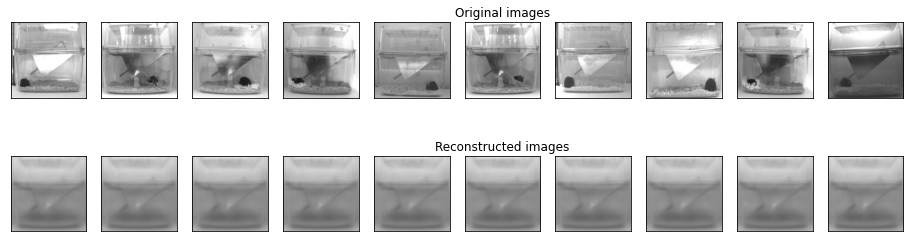

In [14]:
model = newVAE(32)
model = nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load("vae_MSE_1100.p"))
model.eval()
plot_model_outputs(model)

Total Loss: 288242.65860021114


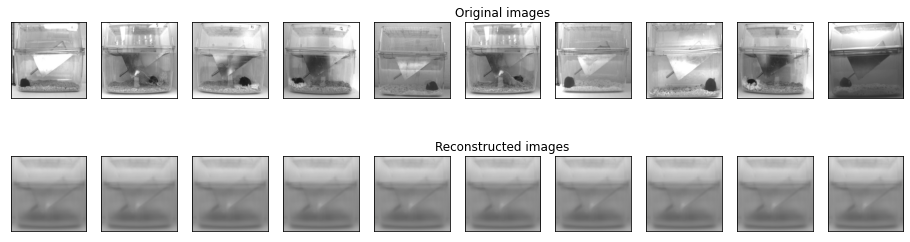

In [15]:
model = newVAE(32)
model = nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load("vae_MSE_e800.p"))
model.eval()
plot_model_outputs(model)

### Comparing AE Models

Total Loss: 22742.92754009366


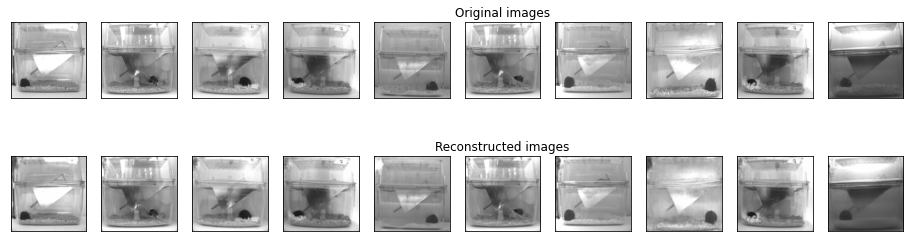

In [16]:
# Best Model
model = newAE(32)
model = nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load("new_architecture_weighted_loss_e490.p"))
model.eval()
plot_model_outputs(model)

Total Loss: 7369.679820840247


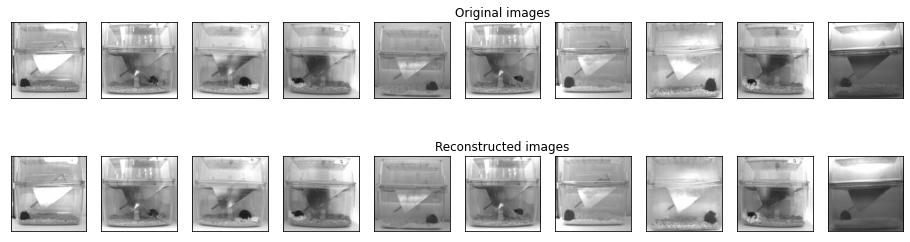

In [17]:
# Best Model
model = newAE(32)
model = nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load("new_architecture_MSE_e2000.p"))
model.eval()
plot_model_outputs(model)

Total Loss: 7391.412786091678


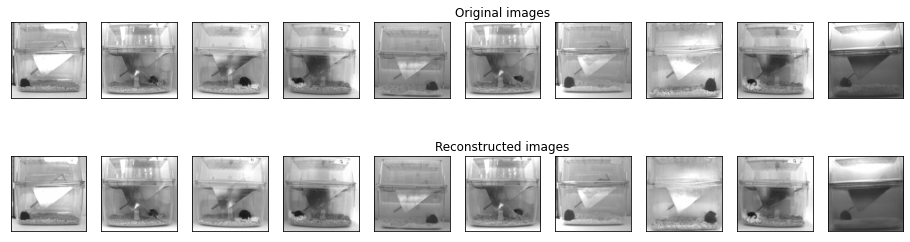

In [18]:
model = newAE(32)
model = nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load("new_architecture_MSE_e1550.p"))
model.eval()
plot_model_outputs(model)

Total Loss: 7338.274575886317


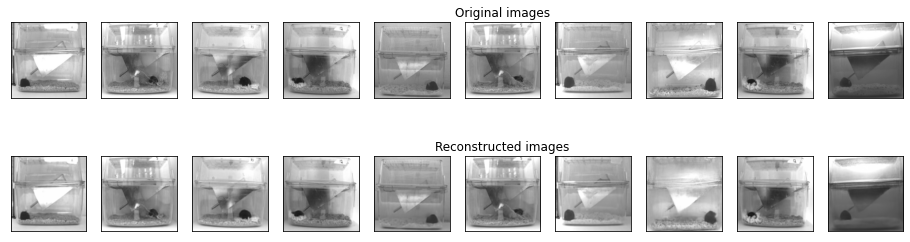

In [19]:
model = newAE(32)
model = nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load("new_architecture_MSE_e1900.p"))
model.eval()
plot_model_outputs(model)

Total Loss: 7418.983572279103


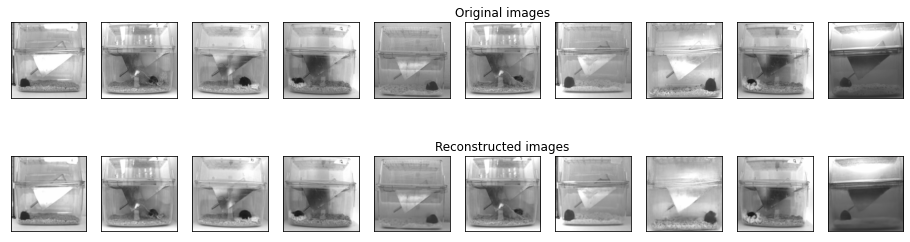

In [20]:
model = newAE(32)
model = nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load("new_architecture_MSE_e2400.p"))
model.eval()
plot_model_outputs(model)

Total Loss: 7348.701066803187


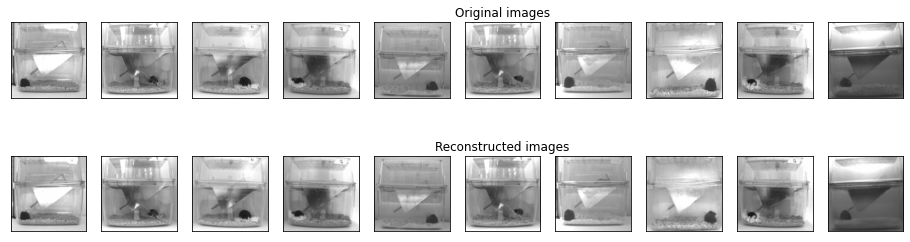

In [21]:
model = newAE(32)
model = nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load("new_architecture_MSE_e1800.p"))
model.eval()
plot_model_outputs(model)

Total Loss: 7225.599867524579


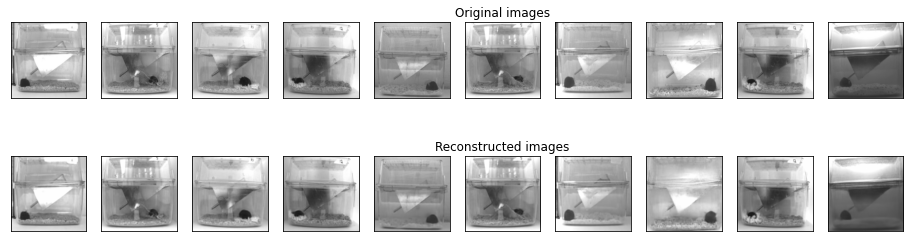

In [22]:
model = newAE(32)
model = nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load("new_architecture_MSE_e1200.p"))
model.eval()
plot_model_outputs(model)

## Modelling

In [60]:
pca_training_vectors = []

In [50]:
model = newAE(32)
model = nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load("new_architecture_MSE_e2400.p"))
model.eval()

# def hook_fn(m, i, o):

#     for grad in o:  
#         try:
# #             full_video_vectors.append(np.array(grad.cpu()))
#             pca_training_vectors.append(np.array(grad.cpu()))
# #             action_vectors[current_action].append(np.array(grad.cpu()))
#         except AttributeError: 
#             print ("None found for Gradient")

# hook_handle = model.module.encoder.ResNet18.fc.register_forward_hook(hook_fn)

DataParallel(
  (module): newAE(
    (encoder): ResNet18Enc(
      (ResNet18): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(

### Generating data to train PCA

In [25]:
# for video_action in ["Eat", "Eathand", "Sniff", "Groom", "Rest", "Walk", "Hang", "Rear"]:
#     print("Working on video", video_action)
#     files = glob.glob('/home/anagara8/Documents/Autoencoder/VideoActions/'+video_action+'/*.jpg')
#     files.sort()
#     for image in files:
#         image = cv2.imread(image)
#         image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
#         tensor_frame = torchvision.transforms.functional.to_tensor(image).unsqueeze(0).cuda()
#         with torch.no_grad():
#             reconstructed_frame = model.module.encoder(tensor_frame)
#         pca_training_vectors.append(reconstructed_frame.cpu().numpy())
# print("All done!")

In [51]:
print("Length of PCA Training Vector:", len(pca_training_vectors))

Length of PCA Training Vector: 0


In [27]:
# for video_number in range(1,6):
#     print("Working on video", video_number)
#     files = glob.glob('/home/anagara8/Documents/Autoencoder/video_sample'+str(video_number)+'-opencv/*.jpg')
#     files.sort()
#     for image in files:
#         image = cv2.imread(image)
#         image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
#         tensor_frame = torchvision.transforms.functional.to_tensor(image).unsqueeze(0).cpu()
#         with torch.no_grad():
#             reconstructed_frame = model(tensor_frame)
#         pca_training_vectors.append(reconstructed_frame.cpu().numpy())
# print("All done!")

In [61]:
print("Length of PCA Training Vector:", len(pca_training_vectors))

Length of PCA Training Vector: 0


In [62]:
final_training_list = []

preexposure_count = 0
postcond_count = 0
postext_count = 0
postret_count = 0

# 1353968 -> Number of frames of postret (smallest class)
for sample in training_data_list:
    if "preexposure" in sample:
        if preexposure_count < 200000:
            final_training_list.append(sample)
            preexposure_count += 1
    elif "postcond" in sample:
        if postcond_count < 200000:
            final_training_list.append(sample)
            postcond_count += 1
    elif "postext" in sample:
        if postext_count < 200000:
            final_training_list.append(sample)
            postext_count += 1
    elif "postret" in sample:
        if postret_count < 200000:
            final_training_list.append(sample)
            postret_count += 1

In [63]:
print("Complete Training Data Length:", len(final_training_list))
# Selecting 1000000 random samples
random.seed(42)
random_samples = random.sample(list(final_training_list), 500000)

Complete Training Data Length: 800000


In [64]:
random_samples.sort()
# New order is: postcond, postext, postret, preexposure

In [71]:
print("Number of randomly selected samples:", len(random_samples))
sample_count = 0
for image in random_samples[len(pca_training_vectors):]:
    sample_count += 1
    if sample_count % 10000 == 0:
        print("Processed", str(sample_count), "samples..")
    image = cv2.imread(image)
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
    tensor_frame = torchvision.transforms.functional.to_tensor(image).unsqueeze(0).cuda()
    with torch.no_grad():
        latent_representation = model.module.encoder(tensor_frame)
    pca_training_vectors.append(latent_representation.squeeze().cpu().numpy())
    
print("All done!")

Number of randomly selected samples: 500000
Processed 10000 samples..
Processed 20000 samples..
Processed 30000 samples..
Processed 40000 samples..
Processed 50000 samples..
Processed 60000 samples..
Processed 70000 samples..
Processed 80000 samples..
Processed 90000 samples..
Processed 100000 samples..
Processed 110000 samples..
Processed 120000 samples..
Processed 130000 samples..
Processed 140000 samples..
Processed 150000 samples..
Processed 160000 samples..
Processed 170000 samples..
Processed 180000 samples..
Processed 190000 samples..
Processed 200000 samples..
Processed 210000 samples..
Processed 220000 samples..
Processed 230000 samples..
Processed 240000 samples..
Processed 250000 samples..
Processed 260000 samples..
Processed 270000 samples..
Processed 280000 samples..
Processed 290000 samples..
Processed 300000 samples..
Processed 310000 samples..
Processed 320000 samples..
Processed 330000 samples..
Processed 340000 samples..
Processed 350000 samples..
Processed 360000 sam

In [72]:
print("Length of PCA Training Vector:", len(pca_training_vectors))

Length of PCA Training Vector: 500000


In [83]:
preexposure = 0
postcond = 0
postext = 0
postret = 0

for sample in random_samples[:len(pca_training_vectors)]:
    if "preexposure" in sample:
        preexposure += 1
    elif "postcond" in sample:
        postcond += 1
    elif "postext" in sample:
        postext += 1
    elif "postret" in sample:
        postret += 1

print("PCA Training Samples split:\nPreexposure:", preexposure, "\nPostcond:", postcond, "\nPostext:", postext, "\nPostret:", postret)

PCA Training Samples split:
Preexposure: 125136 
Postcond: 124816 
Postext: 125018 
Postret: 125030


## PCA

In [87]:
pca_latent_vectors = pca_training_vectors

In [88]:
# Standardising
sc = StandardScaler()
sc.fit(pca_latent_vectors)
standardised_training_vectors = sc.transform(pca_latent_vectors)
print("Data Mean:", np.mean(standardised_training_vectors), " Data Standard Deviation:", np.std(standardised_training_vectors))

Data Mean: 6.8638428274425675e-18  Data Standard Deviation: 0.9999999999999983


In [89]:
pca = PCA(n_components=3, svd_solver='auto')
principalComponents = pca.fit_transform(standardised_training_vectors)
principalDf = pd.DataFrame(data = principalComponents)
print("Explained Variance:", pca.explained_variance_ratio_)

Explained Variance: [0.13043852 0.10373665 0.0781891 ]


## UMAP

In [90]:
umap_latent_vectors = pca_training_vectors

In [ ]:
reducer = umap.umap_.UMAP(n_neighbors=4, random_state=42)
trans = reducer.fit(umap_latent_vectors)

In [ ]:
# New order is: postcond, postext, postret, preexposure
plt.figure(figsize=(20,20))
plt.scatter(trans.embedding_[:postcond, 0], trans.embedding_[:postcond, 1], s= 9,  c='tab:blue', cmap='Spectral')
plt.scatter(trans.embedding_[postcond:postext, 0], trans.embedding_[postcond:postext, 1], s= 9,  c='tab:orange', cmap='Spectral')
plt.scatter(trans.embedding_[postcond+postext:postret, 0], trans.embedding_[postcond+postext:postret, 1], s= 9,  c='limegreen', cmap='Spectral')
plt.scatter(trans.embedding_[postcond+postext+postret:, 0], trans.embedding_[postcond+postext+postret:, 1], s= 9,  c='yellow', cmap='Spectral')
plt.title('Embedding of the training set by UMAP', fontsize=20)

## Animal Embeddings for Different Experiments

### Processing Video Frames to Latents

In [28]:
# Animal in consideration: 17202338 from FC-A
# Time in consideration: ~19:00

video_data_folder = "/media/data_cifs/nih/files_to_send/"
preexposure_video = video_data_folder + "FC-A_08-09-18_preexposure/video_2018Y_08M_09D_19h_18m_24s_cam_17202338-0000.mp4"
postcond_video = video_data_folder + "FC-A_08-10-18_postcond/video_2018Y_08M_13D_19h_21m_04s_cam_17202338-0000.mp4"
postext_video = video_data_folder + "FC-A_08-15-18_postext/video_2018Y_08M_15D_18h_58m_45s_cam_17202338-0000.mp4"
postret_video = video_data_folder + "FC-A_08-15-18_postret/video_2018Y_08M_17D_19h_03m_18s_cam_17202338-0000.mp4"


In [29]:
def video_to_latents(video_path):
    
    latent_vectors = []
    vid_capture = cv2.VideoCapture(video_path)

    if (vid_capture.isOpened() == False):
        print("Error opening the video file")
        
    frame_count = 0
    while(vid_capture.isOpened()):
        ret, frame = vid_capture.read()
        if ret == True:
            frame = cv2.resize(frame, (224, 224), interpolation = cv2.INTER_AREA)
            tensor_frame = torchvision.transforms.functional.to_tensor(frame).unsqueeze(0).cuda()
            with torch.no_grad():
                latent_vector = model.module.encoder(tensor_frame)
                latent_vectors.append(latent_vector.squeeze().cpu().numpy())
        else:
            break
        if frame_count % 10000 == 0:
            print("Processed", frame_count, "frames..")
        frame_count += 1
            
    vid_capture.release()
    return latent_vectors

In [30]:
preexposure_frames1 = video_to_latents(preexposure_video)

Processed 0 frames..
Processed 10000 frames..
Processed 20000 frames..
Processed 30000 frames..
Processed 40000 frames..
Processed 50000 frames..
Processed 60000 frames..
Processed 70000 frames..
Processed 80000 frames..
Processed 90000 frames..
Processed 100000 frames..


In [31]:
postcond_frames1 = video_to_latents(postcond_video)

Processed 0 frames..
Processed 10000 frames..
Processed 20000 frames..
Processed 30000 frames..
Processed 40000 frames..
Processed 50000 frames..
Processed 60000 frames..
Processed 70000 frames..
Processed 80000 frames..
Processed 90000 frames..
Processed 100000 frames..


In [32]:
postext_frames1 = video_to_latents(postext_video)

Processed 0 frames..
Processed 10000 frames..
Processed 20000 frames..
Processed 30000 frames..
Processed 40000 frames..
Processed 50000 frames..
Processed 60000 frames..
Processed 70000 frames..
Processed 80000 frames..
Processed 90000 frames..
Processed 100000 frames..


In [33]:
postret_frames1 = video_to_latents(postret_video)

Processed 0 frames..
Processed 10000 frames..
Processed 20000 frames..
Processed 30000 frames..
Processed 40000 frames..
Processed 50000 frames..
Processed 60000 frames..
Processed 70000 frames..
Processed 80000 frames..
Processed 90000 frames..
Processed 100000 frames..


### Processing Video Actions

In [34]:
# Processing the Action Classes

action_data_folder = "/media/data_cifs/projects/prj_nih/prj_andrew_holmes/inference/batch_inference/akash/"

preexposure_actions = action_data_folder + "FC-A_08-09-18_preexposure/video_2018Y_08M_09D_19h_18m_24s_cam_17202338-0000.csv"
postcond_actions = action_data_folder + "FC-A_08-10-18_postcond/video_2018Y_08M_13D_19h_21m_04s_cam_17202338-0000.csv"
postext_actions = action_data_folder + "FC-A_08-15-18_postext/video_2018Y_08M_15D_18h_58m_45s_cam_17202338-0000.csv"
postret_actions = action_data_folder + "FC-A_08-15-18_postret/video_2018Y_08M_17D_19h_03m_18s_cam_17202338-0000.csv"

preexposure_actions = pd.read_csv(preexposure_actions, header=None)
postcond_actions = pd.read_csv(postcond_actions, header=None)
postext_actions = pd.read_csv(postext_actions, header=None)
postret_actions = pd.read_csv(postret_actions, header=None)

### Comparing Video and Action Lengths:

In [35]:
print("Preexposure: Frames ->", len(preexposure_frames1), "| Actions ->", len(preexposure_actions))
print("Postcond: Frames ->", len(postcond_frames1), "| Actions ->", len(postcond_actions))
print("Postext: Frames ->", len(postext_frames1), "| Actions ->", len(postext_actions))
print("Postret: Frames ->", len(postret_frames1), "| Actions ->", len(postret_actions))

Preexposure: Frames -> 108000 | Actions -> 107840
Postcond: Frames -> 108000 | Actions -> 107840
Postext: Frames -> 108000 | Actions -> 107840
Postret: Frames -> 108000 | Actions -> 107840


In [39]:
preexposure1 = {}
postcond1 = {}
postext1 = {}
postret1 = {}

preexposure_latents_array1 = []
postcond_latents_array1 = []
postext_latents_array1 = []
postret_latents_array1 = []

for i in range(108000):
    try:
        frame_id = preexposure_actions[0][i]
        frame_action = preexposure_actions[1][i]
        preexposure1[i] = {"actions": frame_action, "latents": preexposure_frames1[frame_id]}
        preexposure_latents_array1.append(preexposure_frames1[frame_id])
    except:
        # Action for the frame doesn't exist
        pass

    try:
        frame_id = postcond_actions[0][i]
        frame_action = postcond_actions[1][i]
        postcond1[i] = {"actions": frame_action, "latents": postcond_frames1[frame_id]}
        postcond_latents_array1.append(postcond_frames1[frame_id])
    except:
        # Action for the frame doesn't exist
        pass
    
    try:
        frame_id = postext_actions[0][i]
        frame_action = postext_actions[1][i]
        postext1[i] = {"actions": frame_action, "latents": postext_frames1[frame_id]}
        postext_latents_array1.append(postext_frames1[frame_id])
    except:
        # Action for the frame doesn't exist
        pass
    
    try:
        frame_id = postret_actions[0][i]
        frame_action = postret_actions[1][i]
        postret1[i] = {"actions": frame_action, "latents": postret_frames1[frame_id]}
        postret_latents_array1.append(postret_frames1[frame_id])
    except:
        # Action for the frame doesn't exist
        pass


In [41]:
print("Preexposure: Actions ->", len(preexposure1))
print("Postcond: Actions ->", len(postcond1))
print("Postext: Actions ->", len(postext1))
print("Postret: Actions ->", len(postret1))

Preexposure: Actions -> 107840
Postcond: Actions -> 107840
Postext: Actions -> 107840
Postret: Actions -> 107840


In [50]:
preexposure_pca1 = preexposure1
postcond_pca1 = postcond1
postext_pca1 = postext1
postret_pca1 = postret1

### Visualizing PCA for the data

In [51]:
all_latents_array1 = preexposure_latents_array1 + postcond_latents_array1 + postext_latents_array1 + postret_latents_array1
print("Length of PCA Training array:", len(all_latents_array1))

Length of PCA Training array: 431360


In [52]:
# Creating a label vector
latent_labels = [0]*107840 + [1]*107840 + [2]*107840 + [3]*107840

In [53]:
# Standardising
sc = StandardScaler()
sc.fit(all_latents_array1)
standardised_training_vectors = sc.transform(all_latents_array1)
print("Data Mean:", np.mean(standardised_training_vectors), " Data Standard Deviation:", np.std(standardised_training_vectors))

pca = PCA(n_components=3, svd_solver='auto')
principalComponents = pca.fit_transform(standardised_training_vectors)
principalDf = pd.DataFrame(data = principalComponents)
print("Explained Variance:", pca.explained_variance_ratio_)

Data Mean: -3.673289829249405e-18  Data Standard Deviation: 1.0000000000000024
Explained Variance: [0.27755576 0.16495825 0.1313575 ]


In [55]:
# Getting PCA-Transformed vectors for every frame that has associated actions
preexposure_pca_rl1 = {"X":[], "Y":[], "Z":[]}
postcond_pca_rl1 = {"X":[], "Y":[], "Z":[]}
postext_pca_rl1 = {"X":[], "Y":[], "Z":[]}
postret_pca_rl1 = {"X":[], "Y":[], "Z":[]}
video_time = []

count = 0
for i in range(107840):
    temp_preexposure = sc.transform(preexposure_pca1[i]["latents"].reshape(1, -1))
    temp_preexposure = pca.transform(temp_preexposure)
    preexposure_pca_rl1["X"].append(temp_preexposure[0][0])
    preexposure_pca_rl1["Y"].append(temp_preexposure[0][1])
    preexposure_pca_rl1["Z"].append(temp_preexposure[0][2])
    
    temp_postcond = sc.transform(postcond_pca1[i]["latents"].reshape(1, -1))
    temp_postcond = pca.transform(temp_postcond)
    postcond_pca_rl1["X"].append(temp_postcond[0][0])
    postcond_pca_rl1["Y"].append(temp_postcond[0][1])
    postcond_pca_rl1["Z"].append(temp_postcond[0][2])
    
    temp_postext = sc.transform(postext_pca1[i]["latents"].reshape(1, -1))
    temp_postext = pca.transform(temp_postext)
    postext_pca_rl1["X"].append(temp_postext[0][0])
    postext_pca_rl1["Y"].append(temp_postext[0][1])
    postext_pca_rl1["Z"].append(temp_postext[0][2])
    
    temp_postret = sc.transform(postret_pca1[i]["latents"].reshape(1, -1))
    temp_postret = pca.transform(temp_postret)
    postret_pca_rl1["X"].append(temp_postret[0][0])
    postret_pca_rl1["Y"].append(temp_postret[0][1])
    postret_pca_rl1["Z"].append(temp_postret[0][2])
    
    video_time.append(count)
    count += 1

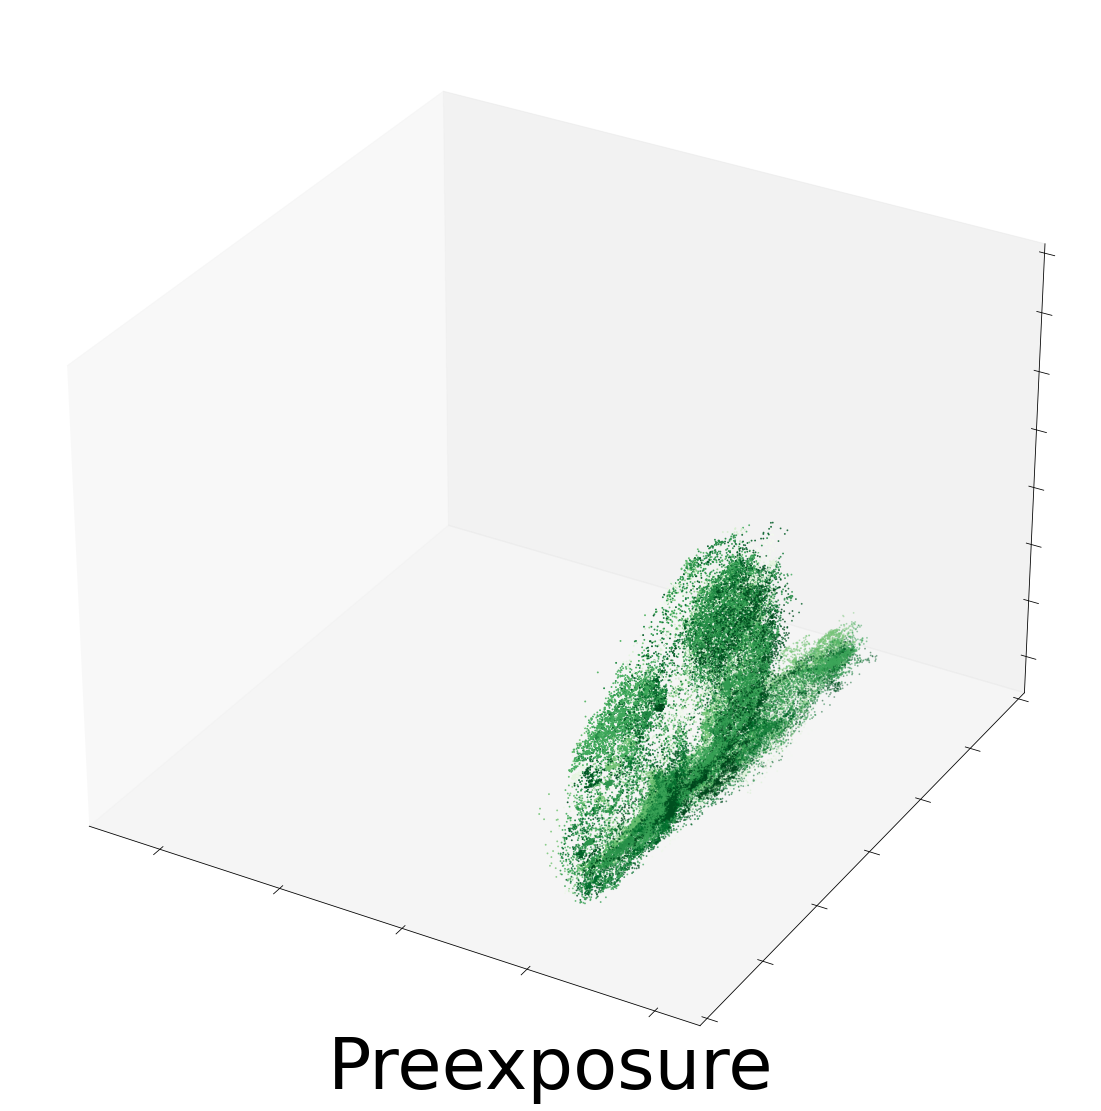

In [73]:
# Different Days:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.set_xlim([-3.0, 6.5])
ax.set_ylim([-4.0, 8.0])
ax.set_zlim([-5.0, 10.0])
ax.grid(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.title("Preexposure", y=-0.0005, fontsize=72)
ax.scatter3D(preexposure_pca_rl1['X'], preexposure_pca_rl1['Y'], preexposure_pca_rl1['Z'], c = video_time, cmap='Greens', s=0.8)

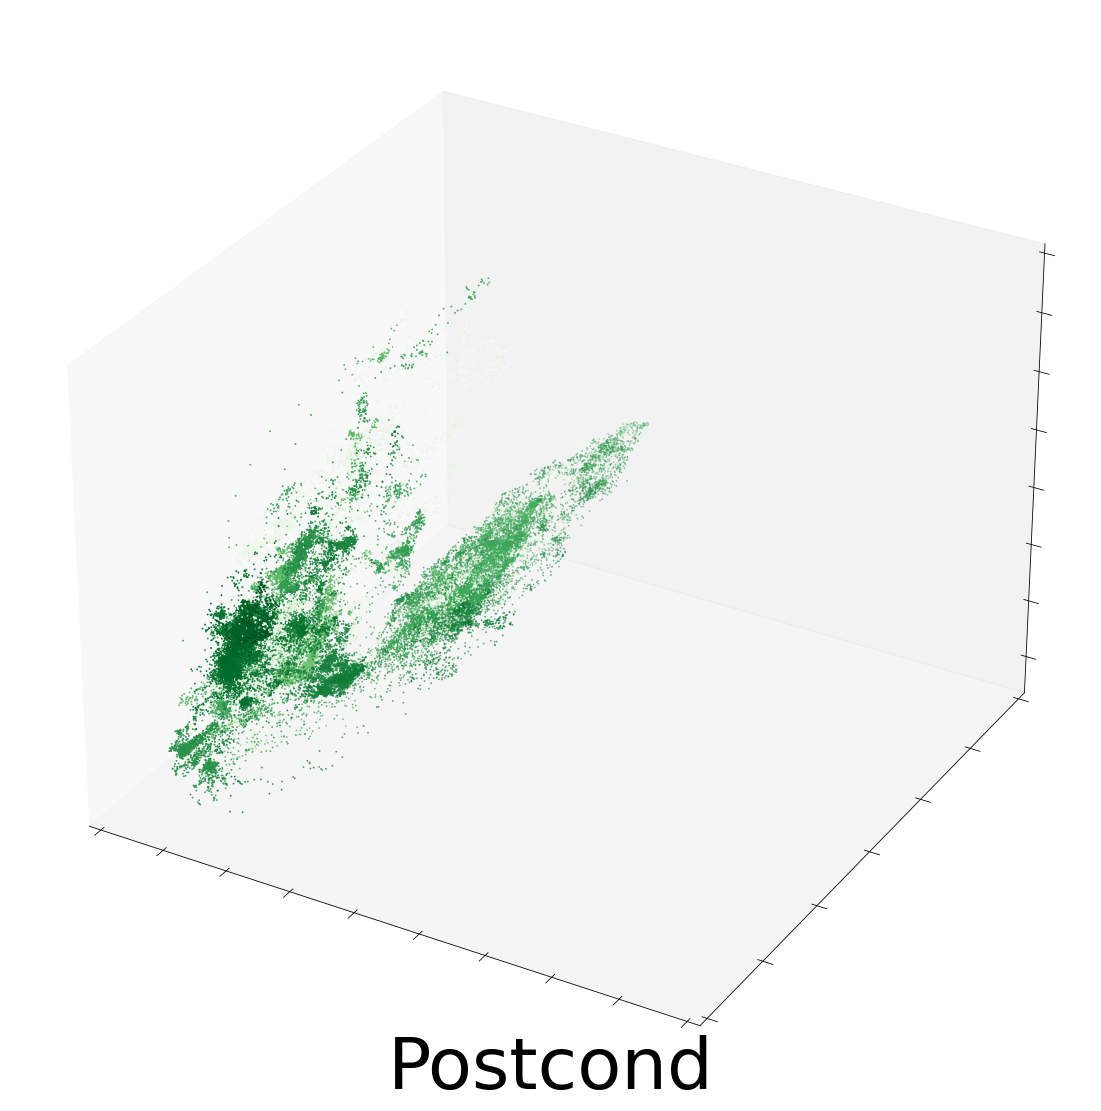

In [72]:
# Different Days:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.set_xlim([-3.0, 6.0])
ax.set_ylim([-4.0, 8.0])
ax.set_zlim([-5.0, 10.0])
ax.grid(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.title("Postcond", y=-0.0005, fontsize=72)
ax.scatter3D(postcond_pca_rl1['X'], postcond_pca_rl1['Y'], postcond_pca_rl1['Z'], c = video_time, cmap='Greens', s = 0.8)

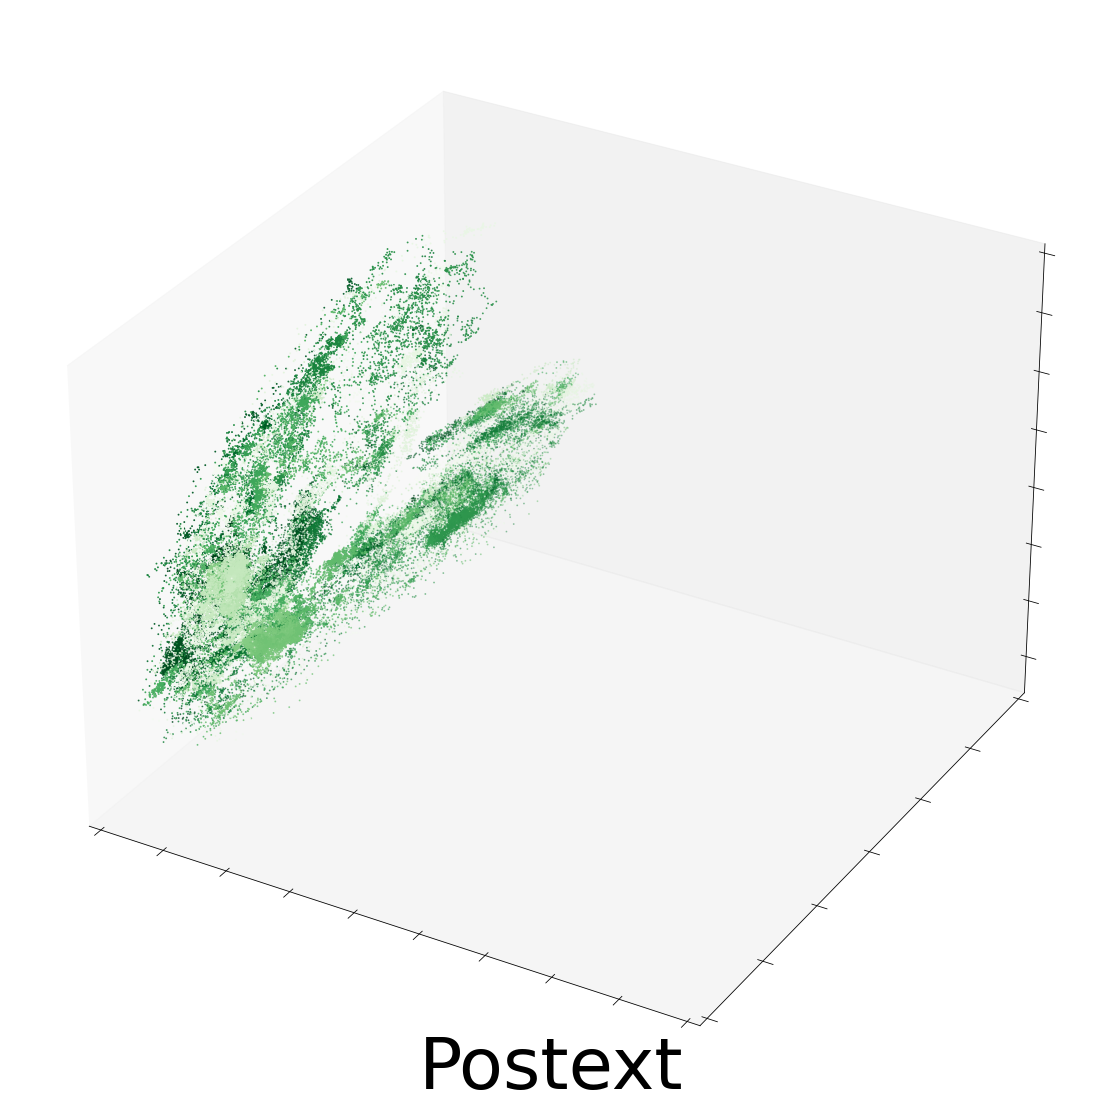

In [70]:
# Different Days:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.set_xlim([-3.0, 6.0])
ax.set_ylim([-4.0, 8.0])
ax.set_zlim([-5.0, 10.0])
ax.grid(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.title("Postext", y=-0.0005, fontsize=72)
ax.scatter3D(postext_pca_rl1['X'], postext_pca_rl1['Y'], postext_pca_rl1['Z'], c = video_time, cmap='Greens', s = 0.8)

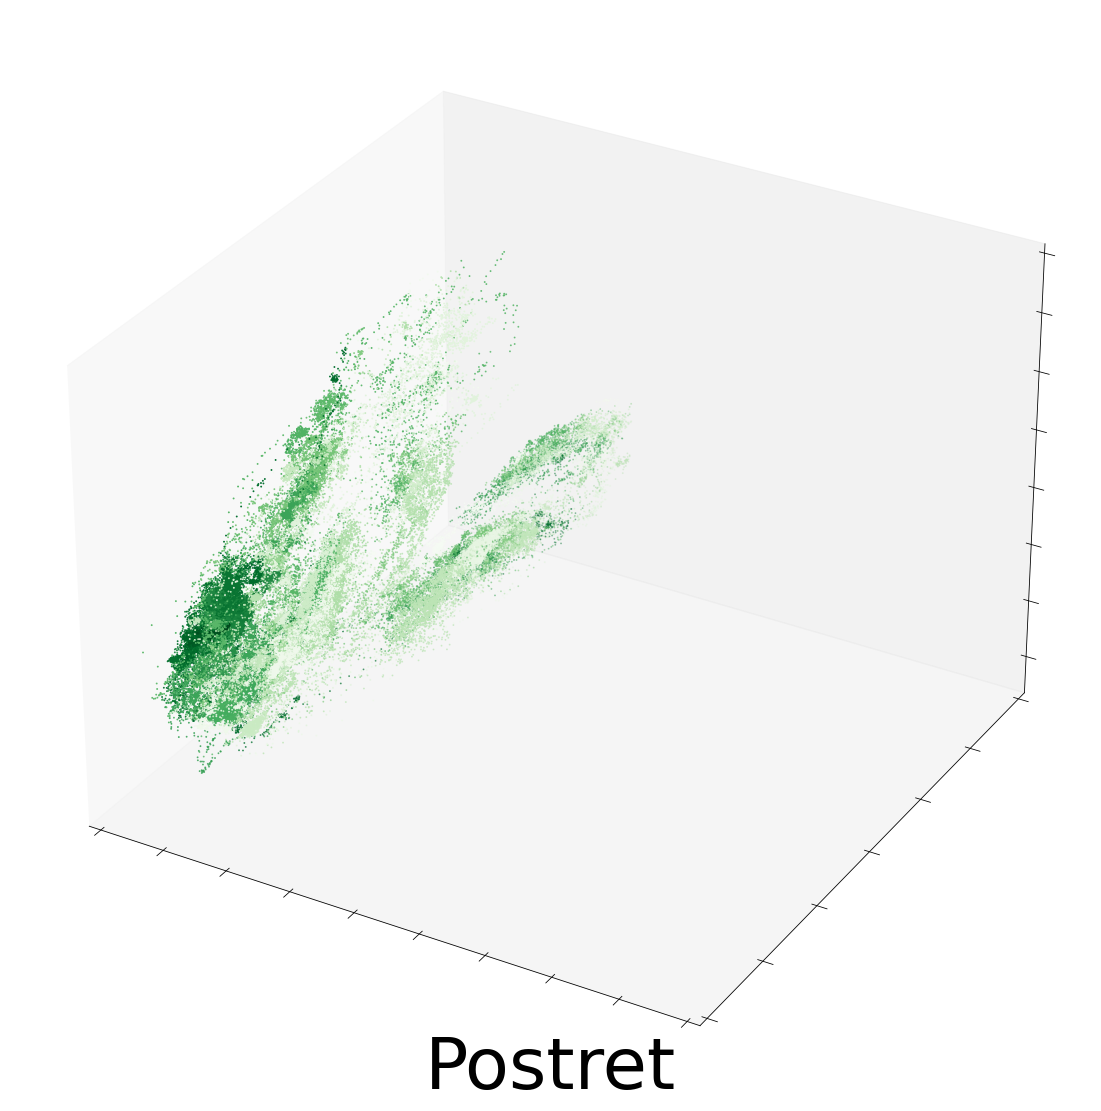

In [68]:
# Different Days:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.set_xlim([-3.0, 6.0])
ax.set_ylim([-4.0, 8.0])
ax.set_zlim([-5.0, 10.0])
ax.grid(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.title("Postret", y=-0.0005, fontsize=72)
ax.scatter3D(postret_pca_rl1['X'], postret_pca_rl1['Y'], postret_pca_rl1['Z'], c = video_time, cmap='Greens', s=0.8)

In [166]:
all_4_expts_x = preexposure_pca_rl['X'] + postcond_pca_rl['X'] + postext_pca_rl['X'] + postret_pca_rl['X']
all_4_expts_y = preexposure_pca_rl['Y'] + postcond_pca_rl['Y'] + postext_pca_rl['Y'] + postret_pca_rl['Y']
all_4_expts_z = preexposure_pca_rl['Z'] + postcond_pca_rl['Z'] + postext_pca_rl['Z'] + postret_pca_rl['Z']

experiments_split = [0]*107840 + [1]*107840 + [2]*107840 + [3]*107840

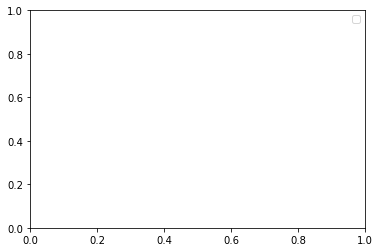

In [260]:
plt.legend(["postcond", "postret", "postext"], loc ="best")
plt.show()

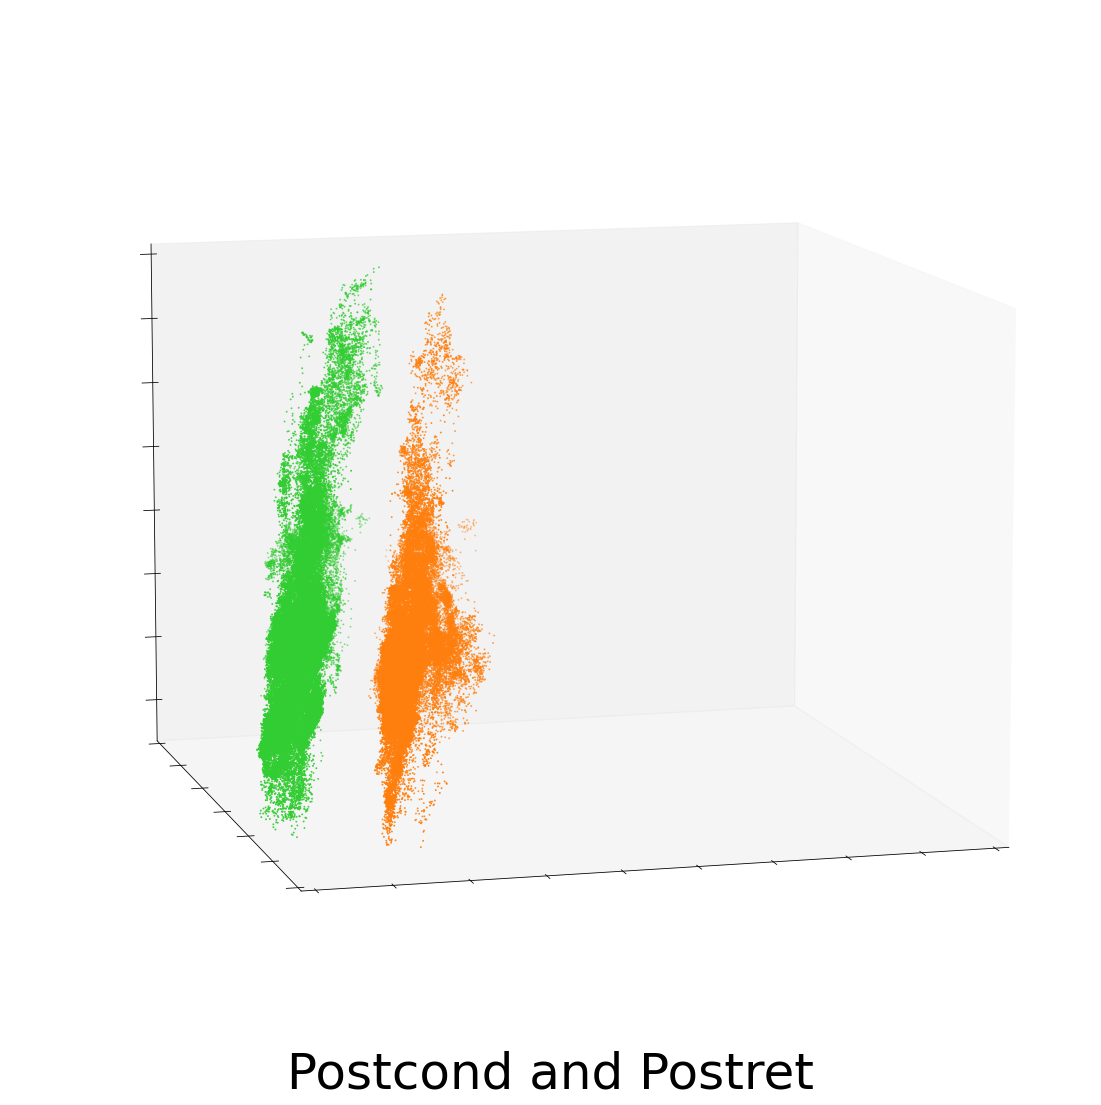

In [362]:
action_colours = {0:'tab:blue', 1:'tab:orange', 2:'limegreen', 3:'yellow'}

action_colour_map = []
for i in range(len(experiments_split)):
    action_colour_map.append(action_colours[experiments_split[i]])
                  
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection='3d')
ax.grid(False)
ax.view_init(10, -105)
ax.set_xlim([-3.0, 6.0])
ax.set_ylim([-4.0, 8.0])
ax.set_zlim([-5.0, 10.0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.title("Postcond and Postret", y=-0.0000001, fontsize=50)
# ax.scatter3D(all_4_expts_x[:107840], all_4_expts_y[:107840], all_4_expts_z[:107840], c=action_colour_map[:107840], s=0.8)#, label=["postext", "postcond", "postret"])
ax.scatter3D(all_4_expts_x[107840:215680], all_4_expts_y[107840:215680], all_4_expts_z[107840:215680], c=action_colour_map[107840:215680], s=0.8)#, label=["postext", "postcond", "postret"])
ax.scatter3D(all_4_expts_x[215680:323520], all_4_expts_y[215680:323520], all_4_expts_z[215680:323520], c=action_colour_map[215680:323520], s=0.8)#, label=["postext", "postcond", "postret"])
# ax.scatter3D(all_4_expts_x[323520:], all_4_expts_y[323520:], all_4_expts_z[323520:], c=action_colour_map[323520:], s=0.8)#, label=["postext", "postcond", "postret"])
# ax.legend(['Label1', 'Label2', 'Label3']) # 4 Labels for 4 colours
# plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1))
# Function add a legend
# plt.legend(["preexposure", "postcond", "postret", "postext"], loc ="lower right", prop={'size': 60}, framealpha=1)

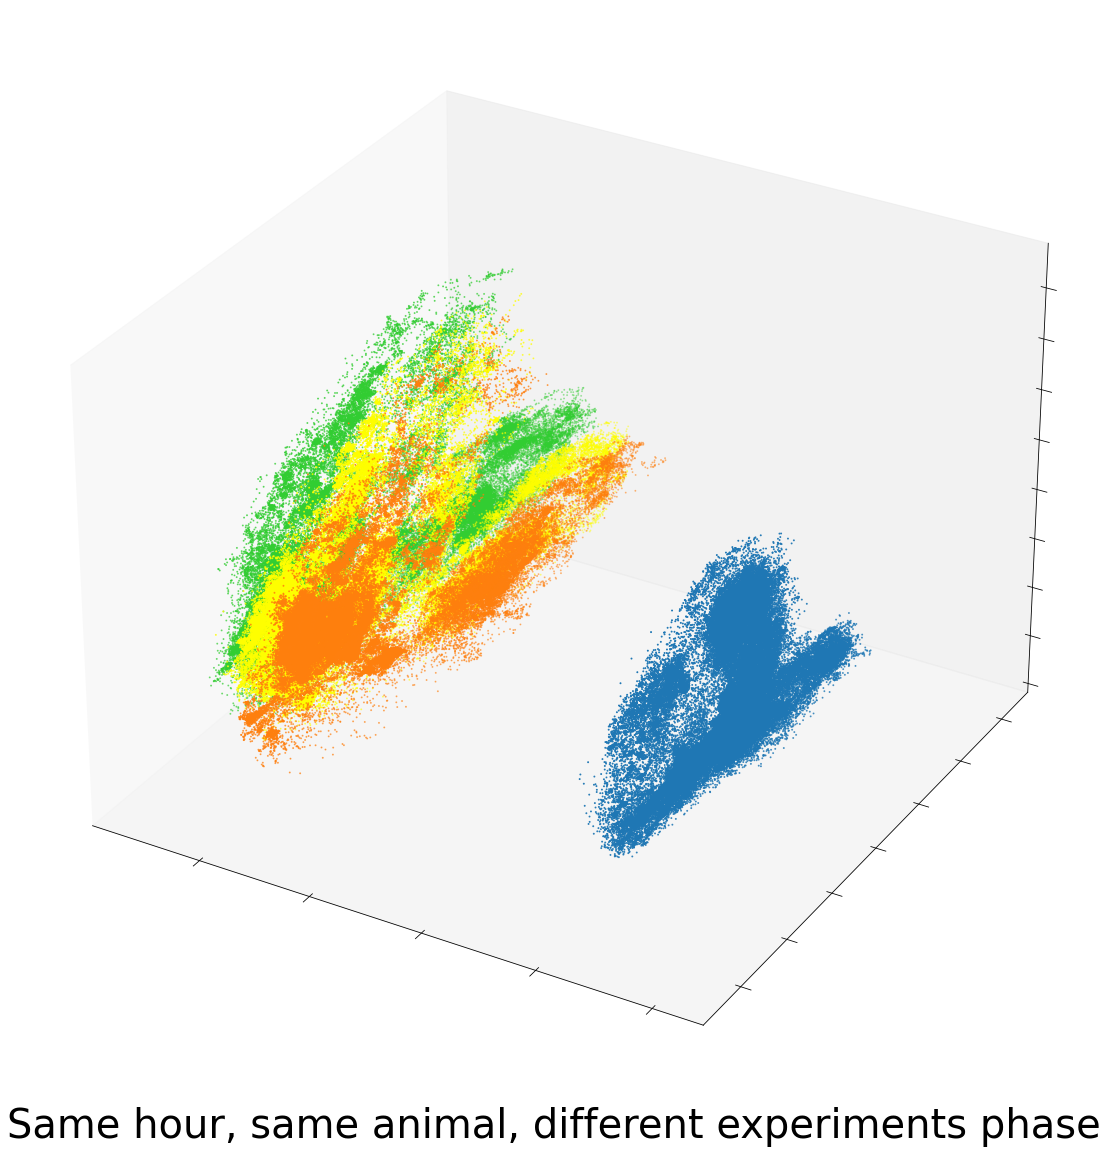

In [251]:
action_colours = {0:'tab:blue', 1:'tab:orange', 2:'limegreen', 3:'yellow'}

action_colour_map = []
for i in range(len(experiments_split)):
    action_colour_map.append(action_colours[experiments_split[i]])
                  
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection='3d')
ax.grid(False)
# ax.set_xlim([-0.6, 2.0])
# ax.set_ylim([-1.0, 2.0])
# ax.set_zlim([-1.0, 2.0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# ax.view_init(40, -75)
plt.title("Same hour, same animal, different experiments phase", y=-0.05, fontsize=40)
ax.scatter3D(all_4_expts_x, all_4_expts_y, all_4_expts_z, c=action_colour_map, s = 0.9)

In [122]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
x_values, y_values, z_values = [], [], []
plt.style.use('seaborn-dark-palette')
mapped_actions = []
prev_action = None
timer = -1
action_time = []
for i in range(len(all_4_expts_x)):
    if i%5000 == 0:
        print("Processed", i, "samples..")
    action_time.append(timer)
    x_values.append(all_4_expts_x[i])
    y_values.append(all_4_expts_y[i])
    z_values.append(all_4_expts_z[i])
    
    ax.scatter3D(x_values, y_values, z_values, c=action_colour_map[i])#, cmap=action_cmaps[action_labels[i]])
    x_values, y_values, z_values = [], [], []
    action_time = []
    mapped_actions = []

def rotate(angle):
     ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save('G.gif', writer=animation.PillowWriter(fps=20))

Processed 0 samples..
Processed 5000 samples..
Processed 10000 samples..
Processed 15000 samples..
Processed 20000 samples..
Processed 25000 samples..
Processed 30000 samples..
Processed 35000 samples..
Processed 40000 samples..
Processed 45000 samples..
Processed 50000 samples..
Processed 55000 samples..
Processed 60000 samples..
Processed 65000 samples..
Processed 70000 samples..
Processed 75000 samples..
Processed 80000 samples..
Processed 85000 samples..
Processed 90000 samples..
Processed 95000 samples..
Processed 100000 samples..
Processed 105000 samples..
Processed 110000 samples..
Processed 115000 samples..
Processed 120000 samples..
Processed 125000 samples..
Processed 130000 samples..
Processed 135000 samples..
Processed 140000 samples..
Processed 145000 samples..
Processed 150000 samples..
Processed 155000 samples..
Processed 160000 samples..
Processed 165000 samples..
Processed 170000 samples..
Processed 175000 samples..
Processed 180000 samples..
Processed 185000 samples..

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fc9e62471f0> (for post_execute):


KeyboardInterrupt: 

## Same Experiment but different Animal from FC-B

In [285]:
# Animal in consideration: 17202341 from FC-B
# Time in consideration: ~19:00

video_data_folder = "/media/data_cifs/nih/files_to_send/"
preexposure_video = video_data_folder + "FC-B_1-6_Preexposure_09-17_09-21_2/video_2018Y_09M_19D_19h_02m_38s_cam_17202341-0000.mp4"
postcond_video = video_data_folder + "FC-B_1-6_postcond_09-21_09-23/video_2018Y_09M_21D_19h_39m_29s_cam_17202341-0000.mp4"
postext_video = video_data_folder + "FC-B_1-6_postext_09-24_09-26/video_2018Y_09M_24D_18h_47m_35s_cam_17202341-0000.mp4"
postret_video = video_data_folder + "FC-B_1-6_postretrieval_09-27_10-01/video_2018Y_09M_27D_18h_45m_51s_cam_17202341-0000.mp4"


In [286]:
preexposure_frames = video_to_latents(preexposure_video)

Processed 0 frames..
Processed 10000 frames..
Processed 20000 frames..
Processed 30000 frames..
Processed 40000 frames..
Processed 50000 frames..
Processed 60000 frames..
Processed 70000 frames..
Processed 80000 frames..
Processed 90000 frames..
Processed 100000 frames..


In [287]:
postcond_frames = video_to_latents(postcond_video)

Processed 0 frames..
Processed 10000 frames..
Processed 20000 frames..
Processed 30000 frames..
Processed 40000 frames..
Processed 50000 frames..
Processed 60000 frames..
Processed 70000 frames..
Processed 80000 frames..
Processed 90000 frames..
Processed 100000 frames..


In [288]:
postext_frames = video_to_latents(postext_video)

Processed 0 frames..
Processed 10000 frames..
Processed 20000 frames..
Processed 30000 frames..
Processed 40000 frames..
Processed 50000 frames..
Processed 60000 frames..
Processed 70000 frames..
Processed 80000 frames..
Processed 90000 frames..
Processed 100000 frames..


In [289]:
postret_frames = video_to_latents(postret_video)

Processed 0 frames..
Processed 10000 frames..
Processed 20000 frames..
Processed 30000 frames..
Processed 40000 frames..
Processed 50000 frames..
Processed 60000 frames..
Processed 70000 frames..
Processed 80000 frames..
Processed 90000 frames..
Processed 100000 frames..


In [290]:
# Processing the Action Classes

action_data_folder = "/media/data_cifs/projects/prj_nih/prj_andrew_holmes/inference/batch_inference/akash/"

preexposure_actions = action_data_folder + "FC-B_1-6_Preexposure_09-17_09-21_2/video_2018Y_09M_19D_19h_02m_38s_cam_17202341-0000.csv"
postcond_actions = action_data_folder + "FC-B_1-6_postcond_09-21_09-23/video_2018Y_09M_21D_19h_39m_29s_cam_17202341-0000.csv"
postext_actions = action_data_folder + "FC-B_1-6_postext_09-24_09-26/video_2018Y_09M_24D_18h_47m_35s_cam_17202341-0000.csv"
postret_actions = action_data_folder + "FC-B_1-6_postretrieval_09-27_10-01/video_2018Y_09M_27D_18h_45m_51s_cam_17202341-0000.csv"

preexposure_actions = pd.read_csv(preexposure_actions, header=None)
postcond_actions = pd.read_csv(postcond_actions, header=None)
postext_actions = pd.read_csv(postext_actions, header=None)
postret_actions = pd.read_csv(postret_actions, header=None)

In [291]:
preexposure2 = {}
postcond2 = {}
postext2 = {}
postret2 = {}

preexposure_latents_array2 = []
postcond_latents_array2 = []
postext_latents_array2 = []
postret_latents_array2 = []

preexposure_actions_array2 = []
postcond_actions_array2 = []
postext_actions_array2 = []
postret_actions_array2 = []

for i in range(108000):
    try:
        frame_id = preexposure_actions[0][i]
        frame_action = preexposure_actions[1][i]
        preexposure2[i] = {"actions": frame_action, "latents": preexposure_frames[frame_id]}
        preexposure_latents_array2.append(preexposure_frames[frame_id])
        preexposure_actions_array2.append(frame_action)
    except:
        # Action for the frame doesn't exist
        pass

    try:
        frame_id = postcond_actions[0][i]
        frame_action = postcond_actions[1][i]
        postcond2[i] = {"actions": frame_action, "latents": postcond_frames[frame_id]}
        postcond_latents_array2.append(postcond_frames[frame_id])
        postcond_actions_array2.append(frame_action)
    except:
        # Action for the frame doesn't exist
        pass
    
    try:
        frame_id = postext_actions[0][i]
        frame_action = postext_actions[1][i]
        postext2[i] = {"actions": frame_action, "latents": postext_frames[frame_id]}
        postext_latents_array2.append(postext_frames[frame_id])
        postext_actions_array2.append(frame_action)
    except:
        # Action for the frame doesn't exist
        pass
    
    try:
        frame_id = postret_actions[0][i]
        frame_action = postret_actions[1][i]
        postret2[i] = {"actions": frame_action, "latents": postret_frames[frame_id]}
        postret_latents_array2.append(postret_frames[frame_id])
        postret_actions_array2.append(frame_action)
    except:
        # Action for the frame doesn't exist
        pass

print("Preexposure: Actions ->", len(preexposure2))
print("Postcond: Actions ->", len(postcond2))
print("Postext: Actions ->", len(postext2))
print("Postret: Actions ->", len(postret2))

Preexposure: Actions -> 107840
Postcond: Actions -> 107840
Postext: Actions -> 107840
Postret: Actions -> 107840


In [292]:
preexposure_pca2 = preexposure
postcond_pca2 = postcond
postext_pca2 = postext
postret_pca2 = postret

In [370]:
postcond2[0]["latents"]

array([-0.15224771, -0.32143518,  0.45714495,  0.13763581,  0.52719   ,
        0.45767137, -0.62835526,  0.56135994,  0.11338222,  0.1322084 ,
       -0.00402417, -0.8630734 , -0.6824383 ,  0.9648133 , -0.12555942,
       -0.08934835,  0.6186826 ,  0.44398305,  0.28202137, -0.91508317,
       -0.2968705 , -1.2607434 , -0.5199784 ,  0.795787  , -0.85900766,
        0.02152587, -1.6165429 , -0.6404864 , -0.5550732 , -0.3302333 ,
        0.64444625, -0.19729772], dtype=float32)

In [369]:
postcond_latents_array2[0]

array([-0.15224771, -0.32143518,  0.45714495,  0.13763581,  0.52719   ,
        0.45767137, -0.62835526,  0.56135994,  0.11338222,  0.1322084 ,
       -0.00402417, -0.8630734 , -0.6824383 ,  0.9648133 , -0.12555942,
       -0.08934835,  0.6186826 ,  0.44398305,  0.28202137, -0.91508317,
       -0.2968705 , -1.2607434 , -0.5199784 ,  0.795787  , -0.85900766,
        0.02152587, -1.6165429 , -0.6404864 , -0.5550732 , -0.3302333 ,
        0.64444625, -0.19729772], dtype=float32)

In [305]:
all_latents_array = preexposure_latents_array + postcond_latents_array + postext_latents_array + postret_latents_array
print("Length of PCA Training array:", len(all_latents_array))

# Standardising
sc = StandardScaler()
sc.fit(all_latents_array)
standardised_training_vectors = sc.transform(all_latents_array)
print("Data Mean:", np.mean(standardised_training_vectors), " Data Standard Deviation:", np.std(standardised_training_vectors))

pca = PCA(n_components=3, svd_solver='auto')
principalComponents = pca.fit_transform(standardised_training_vectors)
principalDf = pd.DataFrame(data = principalComponents)
print("Explained Variance:", pca.explained_variance_ratio_)

Length of PCA Training array: 431360
Data Mean: -3.673289829249405e-18  Data Standard Deviation: 1.0000000000000024
Explained Variance: [0.27755576 0.16495825 0.1313575 ]


In [306]:
# Getting PCA-Transformed vectors for every frame that has associated actions
preexposure_pca_rl2 = {"X":[], "Y":[], "Z":[]}
postcond_pca_rl2 = {"X":[], "Y":[], "Z":[]}
postext_pca_rl2 = {"X":[], "Y":[], "Z":[]}
postret_pca_rl2 = {"X":[], "Y":[], "Z":[]}
video_time2 = []

count = 0
for i in range(107840):
    temp_preexposure = sc.transform(preexposure_pca2[i]["latents"].reshape(1, -1))
    temp_preexposure = pca.transform(temp_preexposure)
    preexposure_pca_rl2["X"].append(temp_preexposure[0][0])
    preexposure_pca_rl2["Y"].append(temp_preexposure[0][1])
    preexposure_pca_rl2["Z"].append(temp_preexposure[0][2])
    
    temp_postcond = sc.transform(postcond_pca2[i]["latents"].reshape(1, -1))
    temp_postcond = pca.transform(temp_postcond)
    postcond_pca_rl2["X"].append(temp_postcond[0][0])
    postcond_pca_rl2["Y"].append(temp_postcond[0][1])
    postcond_pca_rl2["Z"].append(temp_postcond[0][2])
    
    temp_postext = sc.transform(postext_pca2[i]["latents"].reshape(1, -1))
    temp_postext = pca.transform(temp_postext)
    postext_pca_rl2["X"].append(temp_postext[0][0])
    postext_pca_rl2["Y"].append(temp_postext[0][1])
    postext_pca_rl2["Z"].append(temp_postext[0][2])
    
    temp_postret = sc.transform(postret_pca2[i]["latents"].reshape(1, -1))
    temp_postret = pca.transform(temp_postret)
    postret_pca_rl2["X"].append(temp_postret[0][0])
    postret_pca_rl2["Y"].append(temp_postret[0][1])
    postret_pca_rl2["Z"].append(temp_postret[0][2])
    
    video_time2.append(count)
    count += 1

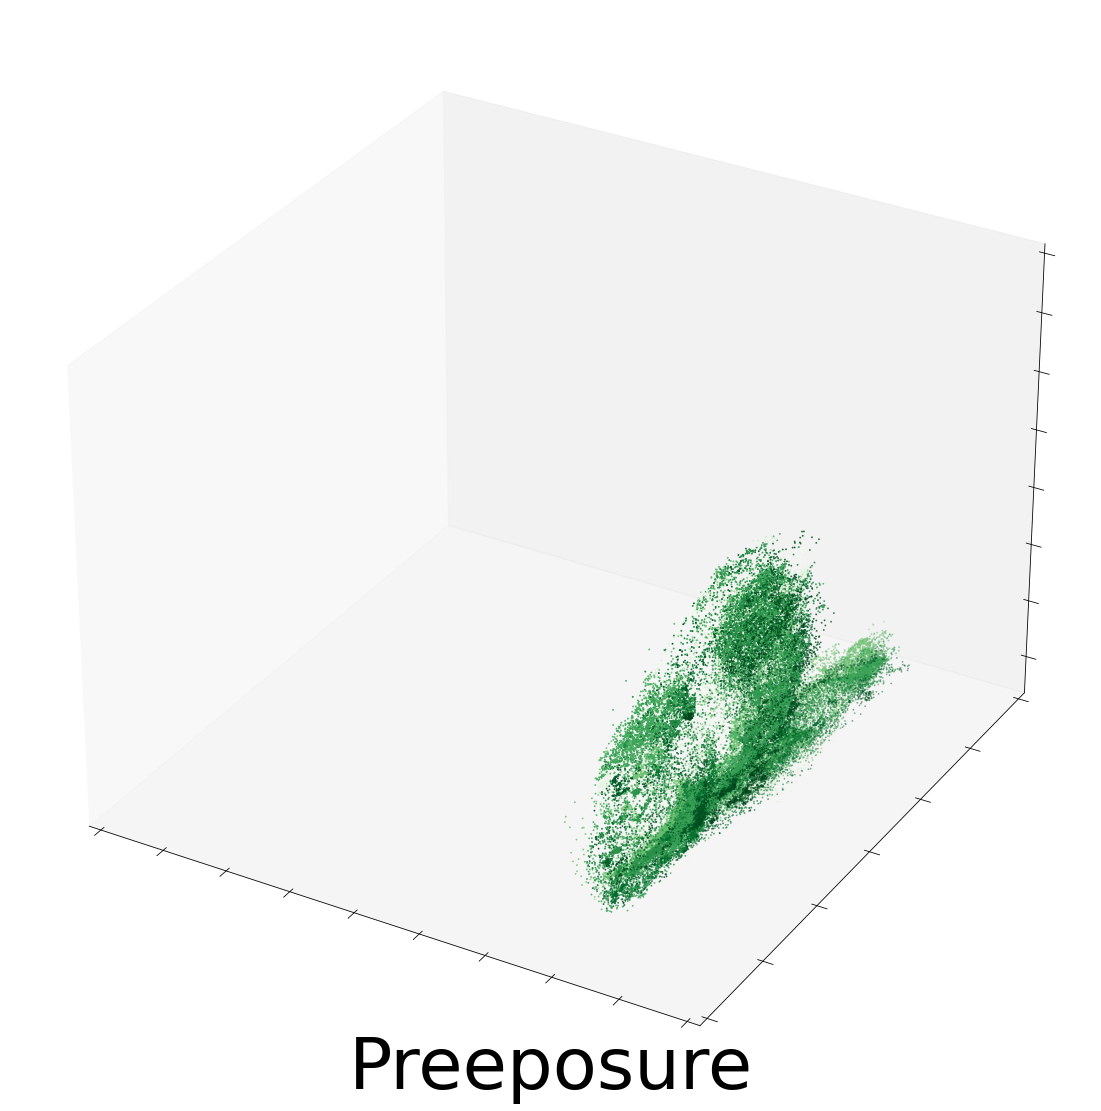

In [354]:
# Different Days:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.set_xlim([-3.0, 6.0])
ax.set_ylim([-4.0, 8.0])
ax.set_zlim([-5.0, 10.0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(False)
plt.title("Preeposure", y=-0.0005, fontsize=72)
ax.scatter3D(preexposure_pca_rl2['X'], preexposure_pca_rl2['Y'], preexposure_pca_rl2['Z'], c = video_time2, cmap='Greens', s=0.8)

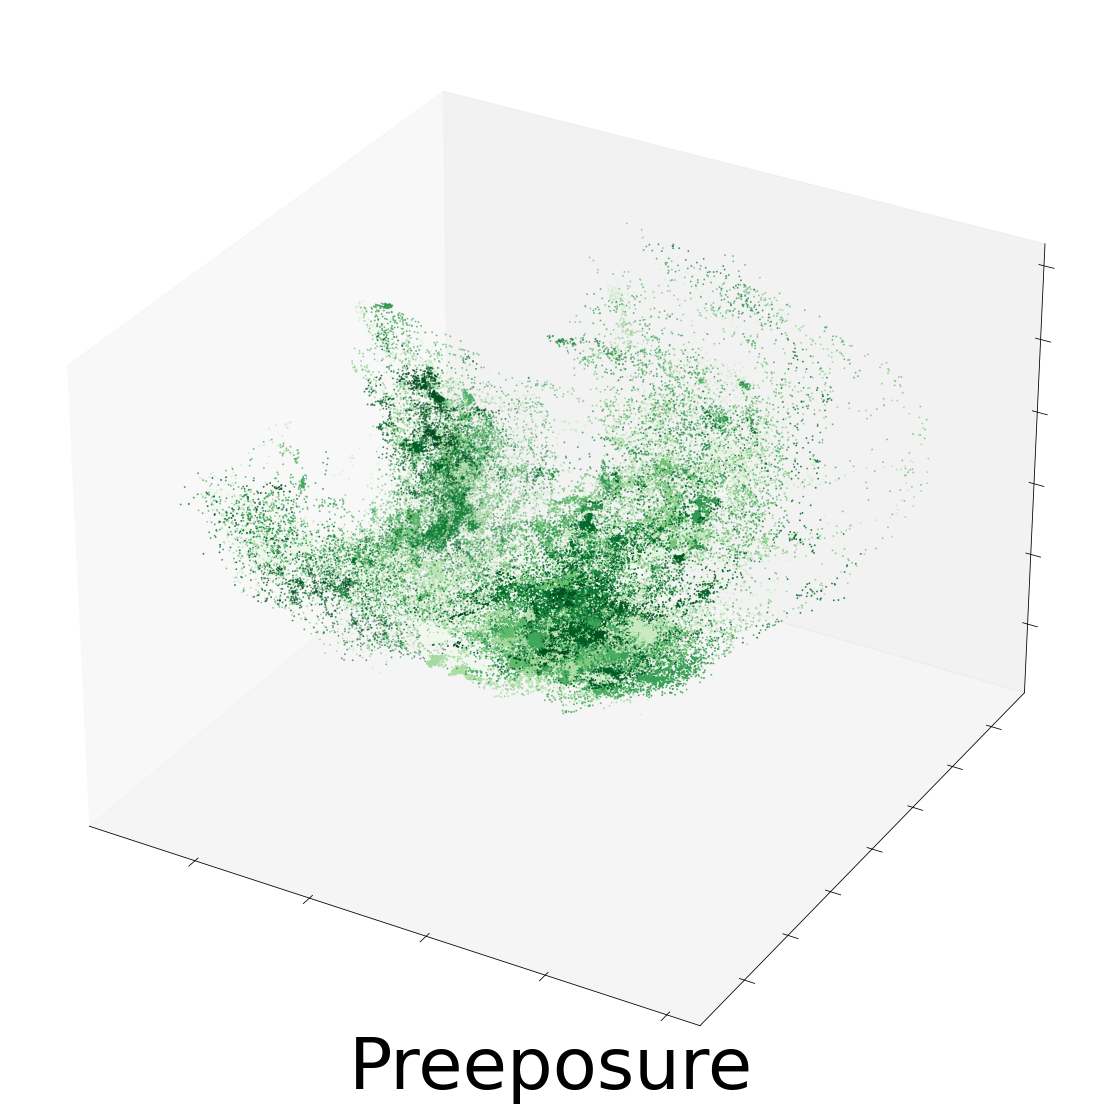

In [355]:
# Different Days:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
# ax.set_xlim([-3.0, 6.0])
# ax.set_ylim([-4.0, 8.0])
# ax.set_zlim([-5.0, 10.0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(False)
plt.title("Preeposure", y=-0.0005, fontsize=72)
ax.scatter3D(preexposure_pca_rl['X'], preexposure_pca_rl['Y'], preexposure_pca_rl['Z'], c = video_time2, cmap='Greens', s=0.8)

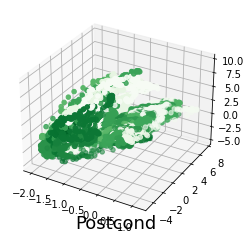

In [357]:
# Different Days:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.set_xlim([-6.0, 4.0])
# ax.set_ylim([-4.0, 0.0])
# ax.set_zlim([-2.0, 3.0])
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_zticklabels([])
plt.title("Postcond", y=-0.05, fontsize=18)
ax.scatter3D(postcond_pca_rl2['X'], postcond_pca_rl2['Y'], postcond_pca_rl2['Z'], c = video_time2, cmap='Greens')

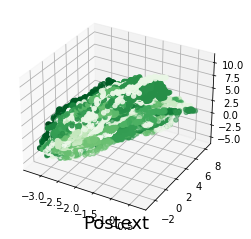

In [309]:
# Different Days:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.set_xlim([-6.0, 4.0])
# ax.set_ylim([-4.0, 0.0])
# ax.set_zlim([-2.0, 3.0])
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_zticklabels([])
plt.title("Postext", y=-0.05, fontsize=18)
ax.scatter3D(postext_pca_rl2['X'], postext_pca_rl2['Y'], postext_pca_rl2['Z'], c = video_time2, cmap='Greens')

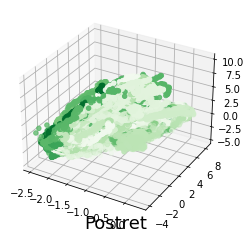

In [310]:
# Different Days:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.set_xlim([-6.0, 4.0])
# ax.set_ylim([-4.0, 0.0])
# ax.set_zlim([-2.0, 3.0])
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_zticklabels([])
plt.title("Postret", y=-0.05, fontsize=18)
ax.scatter3D(postret_pca_rl2['X'], postret_pca_rl2['Y'], postret_pca_rl2['Z'], c = video_time2, cmap='Greens')

In [311]:
all_4_expts_x2 = preexposure_pca_rl2['X'] + postcond_pca_rl2['X'] + postext_pca_rl2['X'] + postret_pca_rl2['X']
all_4_expts_y2 = preexposure_pca_rl2['Y'] + postcond_pca_rl2['Y'] + postext_pca_rl2['Y'] + postret_pca_rl2['Y']
all_4_expts_z2 = preexposure_pca_rl2['Z'] + postcond_pca_rl2['Z'] + postext_pca_rl2['Z'] + postret_pca_rl2['Z']

experiments_split2 = [0]*107840 + [1]*107840 + [2]*107840 + [3]*107840

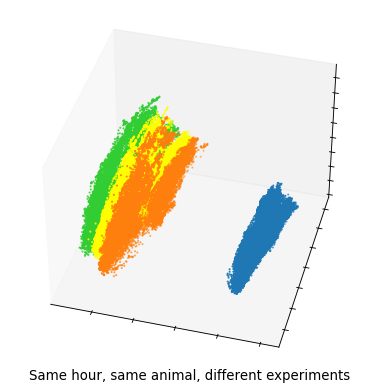

In [313]:
action_colours = {0:'tab:blue', 1:'tab:orange', 2:'limegreen', 3:'yellow'}

action_colour_map2 = []
for i in range(len(experiments_split)):
    action_colour_map2.append(action_colours[experiments_split[i]])
                  
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')
ax.grid(False)
# ax.set_xlim([-0.6, 2.0])
# ax.set_ylim([-1.0, 2.0])
# ax.set_zlim([-1.0, 2.0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.view_init(40, -75)
plt.title("Same hour, same animal, different experiments", y=-0.05, fontsize=12)
ax.scatter3D(all_4_expts_x2, all_4_expts_y2, all_4_expts_z2, c=action_colour_map2, s=0.8)

In [193]:
len(all_4_expts_x2) - 2*107840

215680

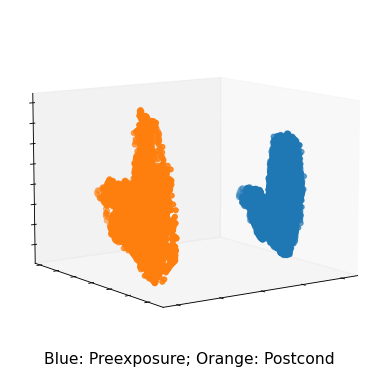

In [195]:
action_colours = {0:'tab:blue', 1:'tab:orange', 2:'limegreen', 3:'yellow'}

action_colour_map = []
for i in range(len(experiments_split)):
    action_colour_map.append(action_colours[experiments_split[i]])
                  
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')
ax.grid(False)
# ax.set_xlim([-0.6, 0.4])
# ax.set_ylim([-1.0, 1.0])
# ax.set_zlim([-1.0, 2.0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.view_init(10, -125)

plt.title("Blue: Preexposure; Orange: Postcond", y=-0.0005, fontsize=14)
ax.scatter3D(all_4_expts_x2[:215680], all_4_expts_y2[:215680], all_4_expts_z2[:215680], c=action_colour_map2[:215680])

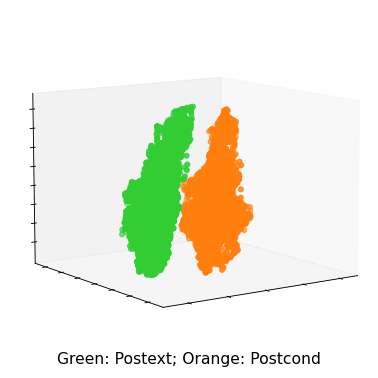

In [192]:
action_colours = {0:'tab:blue', 1:'tab:orange', 2:'limegreen', 3:'yellow'}

action_colour_map = []
for i in range(len(experiments_split)):
    action_colour_map.append(action_colours[experiments_split[i]])
                  
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')
ax.grid(False)
# ax.set_xlim([-0.6, 0.4])
# ax.set_ylim([-1.0, 1.0])
# ax.set_zlim([-1.0, 2.0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.view_init(10, -125)

plt.title("Green: Postext; Orange: Postcond", y=-0.0005, fontsize=14)
ax.scatter3D(all_4_expts_x2[107840:323520], all_4_expts_y2[107840:323520], all_4_expts_z2[107840:323520], c=action_colour_map2[107840:323520])

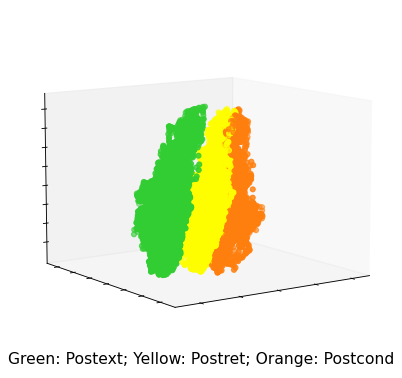

In [164]:
action_colours = {0:'tab:blue', 1:'tab:orange', 2:'limegreen', 3:'yellow'}

action_colour_map = []
for i in range(len(experiments_split)):
    action_colour_map.append(action_colours[experiments_split[i]])
                  
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')
ax.grid(False)
# ax.set_xlim([-0.6, 0.4])
# ax.set_ylim([-1.0, 1.0])
# ax.set_zlim([-1.0, 2.0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.view_init(10, )

plt.title("Green: Postext; Yellow: Postret; Orange: Postcond", y=-0.0005, fontsize=14)
ax.scatter3D(all_4_expts_x2[107840:], all_4_expts_y2[107840:], all_4_expts_z2[107840:], c=action_colour_map2[107840:])

In [167]:
set(postret_actions_array2)

{0, 1, 2, 3, 4, 5, 6, 7, 8}

In [ ]:
action_colours = {0:'tab:blue', 1:'tab:orange', 3:'limegreen', 6:'deepskyblue', 4:'tab:pink', 5:'tab:purple', 2:'tab:brown', 7:'tab:red', 8:"yellow"}

action_colour_map = []
for i in range(len(postret_actions_array2)):
    action_colour_map.append(action_colours[postret_actions_array2[i]])

fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')
# ax.set_xlim([-6.0, 4.0])
# ax.set_ylim([-4.0, 0.0])
# ax.set_zlim([-2.0, 3.0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.title("Postret", y=-0.05, fontsize=18)
ax.view_init(10, -210)
ax.scatter3D(postret_pca_rl2['X'], postret_pca_rl2['Y'], postret_pca_rl2['Z'], s=0.01, c = action_colour_map)

In [83]:
len(preexposure_latents_array1), len(preexposure_latents_array1)*2, len(preexposure_latents_array1)*3

(107840, 215680, 323520)

In [74]:
umap_latent_vectors = preexposure_latents_array1 + postcond_latents_array1 + postext_latents_array1 + postret_latents_array1

In [93]:
reducer = umap.umap_.UMAP()
trans = reducer.fit(umap_latent_vectors)

Text(0.5, 1.0, 'Embedding of the training set by UMAP')

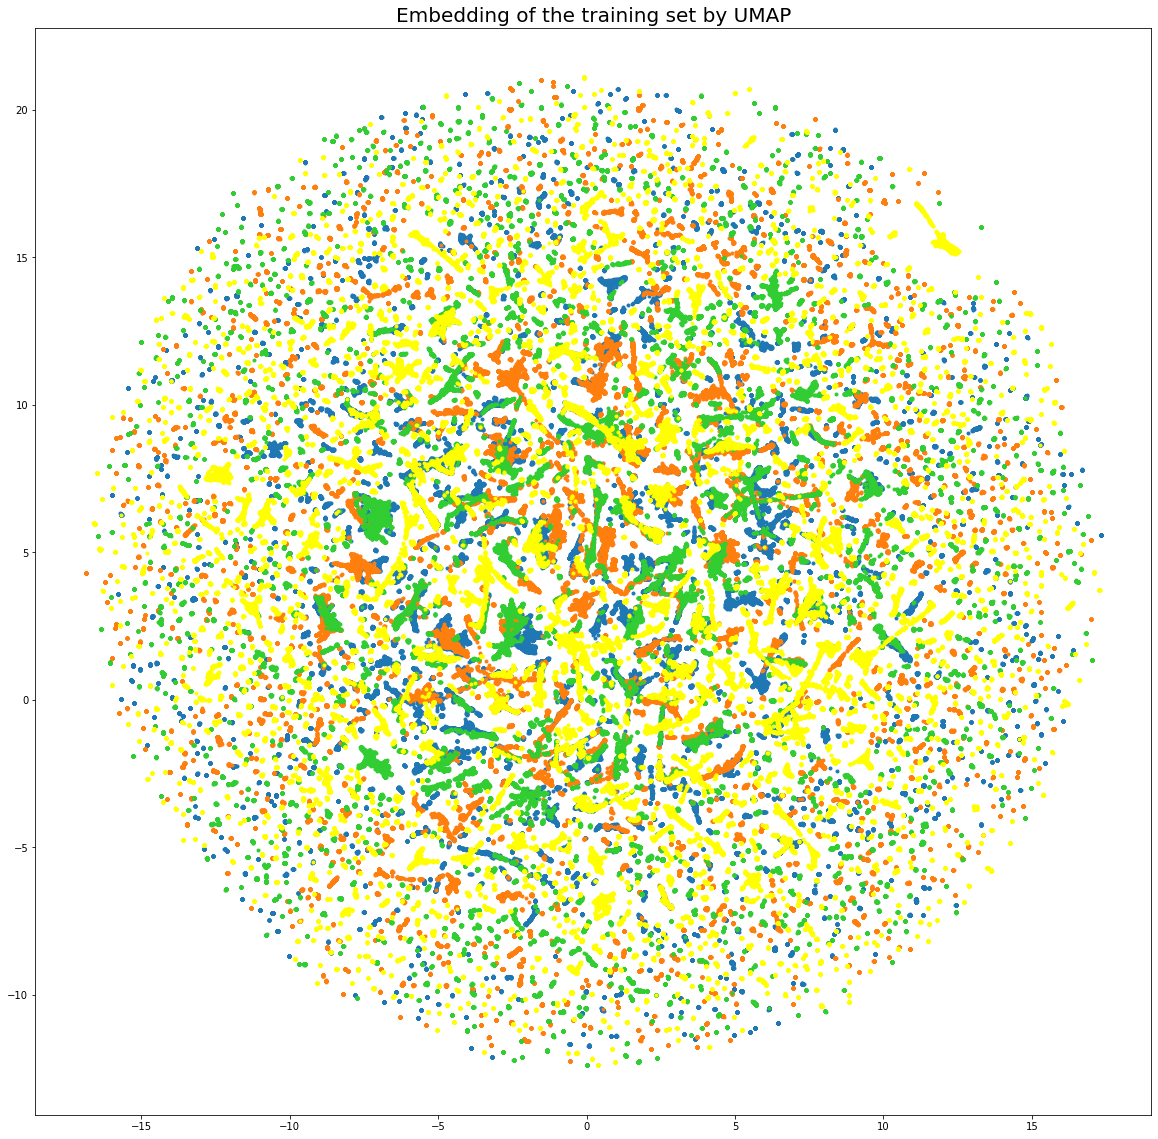

In [94]:
plt.figure(figsize=(20,20))
plt.scatter(trans.embedding_[:107840, 0], trans.embedding_[:107840, 1], s= 9,  c='tab:blue', cmap='Spectral')
plt.scatter(trans.embedding_[107840:215680, 0], trans.embedding_[107840:215680, 1], s= 9,  c='tab:orange', cmap='Spectral')
plt.scatter(trans.embedding_[215680:323520, 0], trans.embedding_[215680:323520, 1], s= 9,  c='limegreen', cmap='Spectral')
plt.scatter(trans.embedding_[323520:, 0], trans.embedding_[323520:, 1], s= 9,  c='yellow', cmap='Spectral')
plt.title('Embedding of the training set by UMAP', fontsize=20)

## tSNE

In [122]:
umap_latent_vectors[0]

array([-0.02103512, -0.08586912,  0.19684295, -0.44239658, -0.2064108 ,
       -0.44674835,  0.69272435, -0.17413568, -0.42253453, -0.09025269,
        1.4947597 ,  0.32573497, -1.0712498 , -0.28608692,  0.22208796,
       -0.5947379 ,  0.15702125,  0.07344718,  0.975754  , -0.08787981,
       -0.79998606, -0.5996526 ,  0.54012704,  0.8686054 , -0.91080844,
       -0.20131595,  0.44106007, -0.4393056 , -0.5771822 ,  0.30558816,
        0.50425076,  0.12928349], dtype=float32)

In [93]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
tsne_results = tsne.fit_transform(umap_latent_vectors)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 431360 samples in 0.007s...
[t-SNE] Computed neighbors for 431360 samples in 1339.675s...
[t-SNE] Computed conditional probabilities for sample 1000 / 431360
[t-SNE] Computed conditional probabilities for sample 2000 / 431360
[t-SNE] Computed conditional probabilities for sample 3000 / 431360
[t-SNE] Computed conditional probabilities for sample 4000 / 431360
[t-SNE] Computed conditional probabilities for sample 5000 / 431360
[t-SNE] Computed conditional probabilities for sample 6000 / 431360
[t-SNE] Computed conditional probabilities for sample 7000 / 431360
[t-SNE] Computed conditional probabilities for sample 8000 / 431360
[t-SNE] Computed conditional probabilities for sample 9000 / 431360
[t-SNE] Computed conditional probabilities for sample 10000 / 431360
[t-SNE] Computed conditional probabilities for sample 11000 / 431360
[t-SNE] Computed conditional probabilities for sample 12000 / 431360
[t-SNE] Computed conditional pro

[t-SNE] Computed conditional probabilities for sample 124000 / 431360
[t-SNE] Computed conditional probabilities for sample 125000 / 431360
[t-SNE] Computed conditional probabilities for sample 126000 / 431360
[t-SNE] Computed conditional probabilities for sample 127000 / 431360
[t-SNE] Computed conditional probabilities for sample 128000 / 431360
[t-SNE] Computed conditional probabilities for sample 129000 / 431360
[t-SNE] Computed conditional probabilities for sample 130000 / 431360
[t-SNE] Computed conditional probabilities for sample 131000 / 431360
[t-SNE] Computed conditional probabilities for sample 132000 / 431360
[t-SNE] Computed conditional probabilities for sample 133000 / 431360
[t-SNE] Computed conditional probabilities for sample 134000 / 431360
[t-SNE] Computed conditional probabilities for sample 135000 / 431360
[t-SNE] Computed conditional probabilities for sample 136000 / 431360
[t-SNE] Computed conditional probabilities for sample 137000 / 431360
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 246000 / 431360
[t-SNE] Computed conditional probabilities for sample 247000 / 431360
[t-SNE] Computed conditional probabilities for sample 248000 / 431360
[t-SNE] Computed conditional probabilities for sample 249000 / 431360
[t-SNE] Computed conditional probabilities for sample 250000 / 431360
[t-SNE] Computed conditional probabilities for sample 251000 / 431360
[t-SNE] Computed conditional probabilities for sample 252000 / 431360
[t-SNE] Computed conditional probabilities for sample 253000 / 431360
[t-SNE] Computed conditional probabilities for sample 254000 / 431360
[t-SNE] Computed conditional probabilities for sample 255000 / 431360
[t-SNE] Computed conditional probabilities for sample 256000 / 431360
[t-SNE] Computed conditional probabilities for sample 257000 / 431360
[t-SNE] Computed conditional probabilities for sample 258000 / 431360
[t-SNE] Computed conditional probabilities for sample 259000 / 431360
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 367000 / 431360
[t-SNE] Computed conditional probabilities for sample 368000 / 431360
[t-SNE] Computed conditional probabilities for sample 369000 / 431360
[t-SNE] Computed conditional probabilities for sample 370000 / 431360
[t-SNE] Computed conditional probabilities for sample 371000 / 431360
[t-SNE] Computed conditional probabilities for sample 372000 / 431360
[t-SNE] Computed conditional probabilities for sample 373000 / 431360
[t-SNE] Computed conditional probabilities for sample 374000 / 431360
[t-SNE] Computed conditional probabilities for sample 375000 / 431360
[t-SNE] Computed conditional probabilities for sample 376000 / 431360
[t-SNE] Computed conditional probabilities for sample 377000 / 431360
[t-SNE] Computed conditional probabilities for sample 378000 / 431360
[t-SNE] Computed conditional probabilities for sample 379000 / 431360
[t-SNE] Computed conditional probabilities for sample 380000 / 431360
[t-SNE] Computed con

In [94]:
print(tsne_results.shape)
tsne_df = pd.DataFrame(tsne_results, columns = ['Axis1','Axis2'])#,'Column_C'])

(431360, 2)


In [111]:
print("t-SNE KL Divergence:",tsne.kl_divergence_)

t-SNE KL Divergence: 3.2183573246002197


In [ ]:
experiment_phases = []

In [105]:
for i in range(107840):
    experiment_phases.append("postret")

[Text(0.5, 1.0, 'Experiment Phase t-SNE projection')]

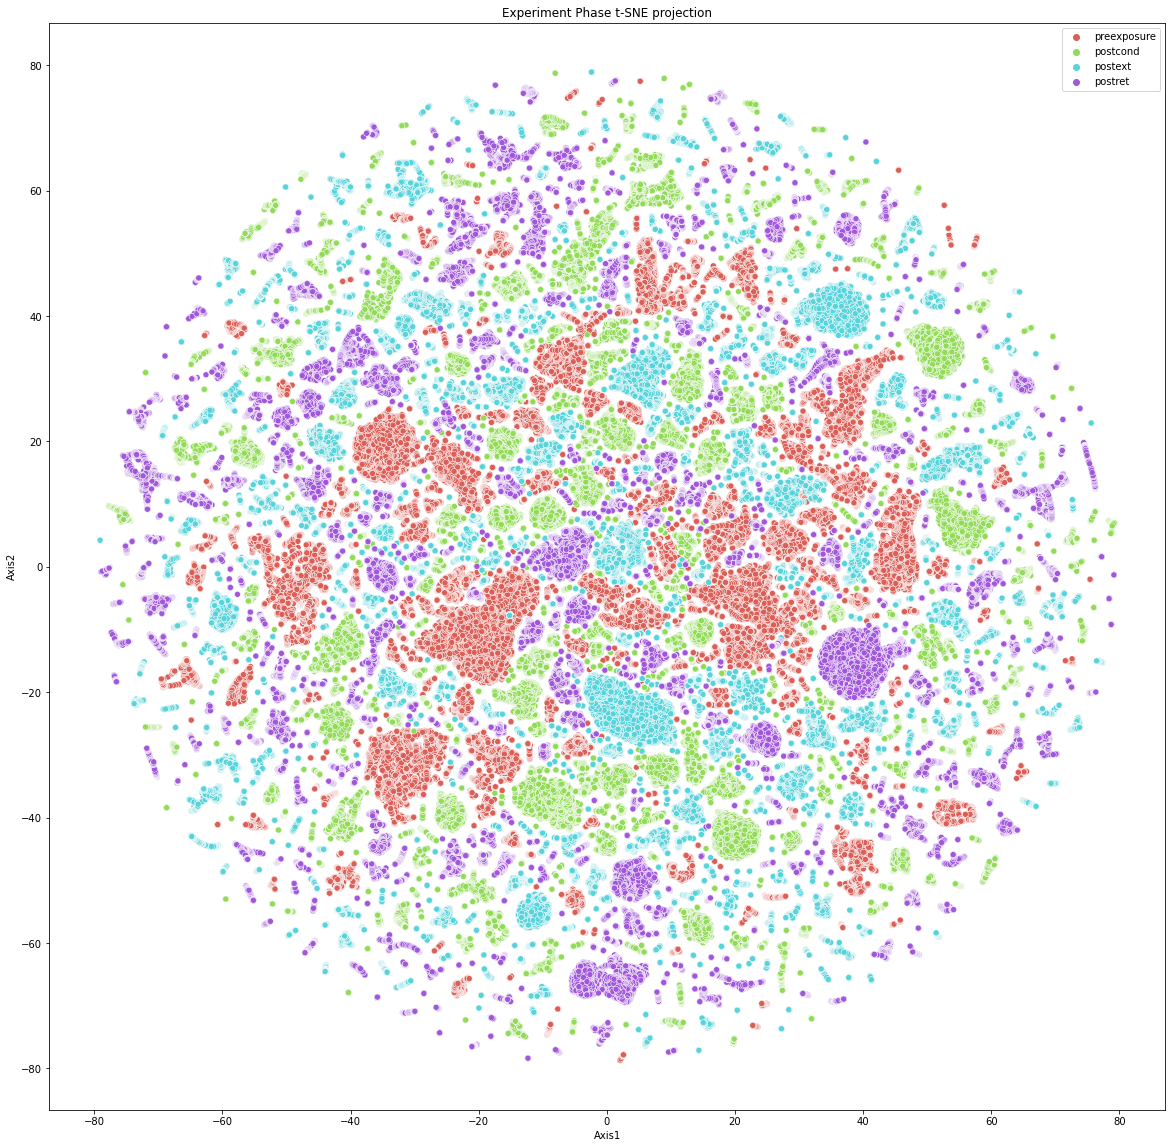

In [113]:
fig = plt.gcf()
fig.set_size_inches(20, 20)
sns.scatterplot(x="Axis1", y="Axis2", hue=experiment_phases,
                palette=sns.color_palette("hls", 4),
                data=tsne_df).set(title="Experiment Phase t-SNE projection")

# Training a Classifier to predict phases of the experiment

In [108]:
start = time.time()
training_data_list = np.load("/media/data_cifs/anagara8/OnePercentFramesList.npy")
end = time.time()
print("Training File List containing", len(training_data_list), "frames loaded in:", end - start)

Training File List containing 8086880 frames loaded in: 23.108654022216797


In [109]:
final_training_list = []

preexposure_count = 0
postcond_count = 0
postext_count = 0
postret_count = 0

for sample in training_data_list:
    if "preexposure" in sample:
        if preexposure_count < 1353968:
            final_training_list.append(sample)
            preexposure_count += 1
    elif "postcond" in sample:
        if postcond_count < 1353968:
            final_training_list.append(sample)
            postcond_count += 1
    elif "postext" in sample:
        if postext_count < 1353968:
            final_training_list.append(sample)
            postext_count += 1
    elif "postret" in sample:
        if postret_count < 1353968:
            final_training_list.append(sample)
            postret_count += 1

In [110]:
print(preexposure_count, postcond_count, postext_count, postret_count)

1353968 1353968 1353968 1353968


In [111]:
len(final_training_list)

5415872

In [112]:
all_latents_array = []
all_labels_array = []

In [113]:
random.seed(42)
random.shuffle(final_training_list)

In [15]:
# image_count = 0
# all_latents_array = []
# all_labels_array = []

# for image in final_training_list:
#     image_count += 1
#     if image_count % 5000 == 0:
#         print("Processed", image_count, "Images..")
#     name = image
#     image = cv2.imread(image)
#     image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
#     tensor_frame = torchvision.transforms.functional.to_tensor(image).unsqueeze(0).cuda()
#     with torch.no_grad():
#         latent_representation = model.module.encoder(tensor_frame)
#     all_latents_array.append(latent_representation.squeeze().cpu().numpy())
    
#     # Append One Hot encoded Labels
#     if "preexposure" in name:
#         all_labels_array.append([1.0, 0.0, 0.0, 0.0])
#     elif "postcond" in name:
#         all_labels_array.append([0.0, 1.0, 0.0, 0.0])
#     elif "postext" in name:
#         all_labels_array.append([0.0, 0.0, 1.0, 0.0])
#     elif "postret" in name:
#         all_labels_array.append([0.0, 0.0, 0.0, 1.0])
#     else:
#         print("ERROR: Incorrect Experiment Phase, no label associated.")

        
# print("All done!")

In [125]:
# Save Latents
# np.save("shuffled4phaseLatents.npy", copied_latents)
# np.save("shuffled4phaseLabels.npy", all_labels_array)
all_latents_array = np.load("shuffled4phaseLatents.npy")
all_labels_array = np.load("shuffled4phaseLabels.npy")

In [126]:
# Creating the DataLoader
class LatentDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, augmentations = None):
        super(LatentDataset, self).__init__()
        
        # Latents are stored as the first element
        self.vector_list = [item[0] for item in dataset]
        # Labels are stored as the second element
        self.label_list = [item[1] for item in dataset]
        
        self.augmentations = augmentations
    
    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, idx):
        vector = torch.tensor(self.vector_list[idx])
        label = torch.tensor(self.label_list[idx])
        return vector, label

In [127]:
m = len(all_latents_array)
test_train_split = 0.2

torch.manual_seed(42)
print("Length:",m, "-> Training set size:", int(math.ceil(m-m*0.2)), "| Validation set size:", int(m*0.2))
train_data, val_data = random_split(list(zip(all_latents_array, all_labels_array)), [int(math.ceil(m-m*test_train_split)), int(m*test_train_split)])

Length: 431360 -> Training set size: 345088 | Validation set size: 86272


In [123]:
# Ensuring the training set is reproducible

In [117]:
train_dataset = LatentDataset(train_data)
val_dataset = LatentDataset(val_data)

In [118]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers = 4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers = 4, shuffle=False)

In [119]:
# Ensuring shuffling
for i in range(15):
    print(train_loader.dataset[i])

(tensor([-0.9735, -0.4467,  0.6988, -0.5000, -0.6634,  0.5094, -0.5485,  0.7482,
        -0.3715,  0.9607,  1.0252, -0.2592, -1.1790, -0.3906,  0.7183,  0.5340,
         0.2954,  0.5841,  0.1269, -0.0496,  1.1773, -0.1850, -0.4668,  0.0237,
         0.3843, -0.0568, -1.6046,  0.5101, -0.4384, -0.1970,  1.6332,  0.1629]), tensor([0., 1., 0., 0.], dtype=torch.float64))
(tensor([ 0.2830, -0.3025,  0.0264, -0.3330,  0.1163, -0.2582,  0.4334, -0.4119,
        -0.2753,  0.6316,  1.3984, -0.3767, -0.6612, -0.1930,  0.6783, -0.3446,
         0.3132,  0.2124,  0.7622, -0.2354, -0.5535, -0.3070,  0.8678,  0.2370,
        -1.0500,  0.0037,  0.3069, -0.1308, -0.1938,  0.1806,  0.8630, -0.5933]), tensor([1., 0., 0., 0.], dtype=torch.float64))
(tensor([-0.0080, -0.7709,  0.3552,  0.3990,  0.0075, -0.2373,  0.5854, -0.1515,
        -0.3578,  1.0564, -0.1229, -0.3052, -0.5033,  0.1748, -0.0817, -0.7486,
        -0.7146, -0.1707, -0.2787,  0.3241,  0.8429, -0.6853,  0.2510,  0.5630,
        -0.5665,  0

In [120]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 128)
        self.hidden_fc1 = nn.Linear(128, 64)
        self.hidden_fc2 = nn.Linear(64, 32)
        self.output_fc = nn.Linear(32, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc1(h_1))
        h_3 = F.relu(self.hidden_fc2(h_2))
        y_out = self.output_fc(h_3)
        y_pred = torch.sigmoid(y_out)
        
        return y_out

In [121]:
INPUT_DIM = 32
OUTPUT_DIM = 4

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [122]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", device)

Using cuda


In [123]:
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.000001)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [124]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [125]:
def calculate_accuracy(y_pred, y):
    y_pred = torch.argmax(y_pred, dim = 1)
    y = torch.argmax(y, dim = 1)
    
#     print("Accuracy:", y_pred, y)
    acc = torch.unique(y_pred[y_pred==y], return_counts = True)[1].sum()
    acc = acc / y.shape[0]
    return acc

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,692 trainable parameters


In [126]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for sample in tqdm(iterator, desc="Validating", leave=False):
            latent, label = sample
        
            latent = latent.to(device)
            label = label.squeeze().to(device)
            
            y_pred = model(latent)

            loss = criterion(y_pred, label)
            acc = calculate_accuracy(y_pred, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [127]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
#     SequenceID, Light_Cycle, Chase_Values, Keypoints

    for sample in tqdm(iterator, desc="Training", leave=False):
        latent, label = sample
        
        latent = latent.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        y_pred = model(latent)
        
#         y_pred = torch.argmax(y_pred, dim=1)#.squeeze()
#         label = torch.argmax(label, dim=1)
#         print("Training preds:", y_pred)
#         print("Training Label:", label.shape)
#         print("Training pred:", y_pred.shape)
        
#         print("Prediction after ArgMax:", y_pred.shape)
#         print("Target:", label.shape)
        loss = criterion(y_pred, label)
        acc = calculate_accuracy(y_pred, label)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 1.3873284 | Train Acc: 24.56%
	 Val. Loss: 1.3860198 |  Val. Acc: 25.06%


Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 1.3854455 | Train Acc: 25.34%
	 Val. Loss: 1.3841153 |  Val. Acc: 26.36%


Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 1.3834675 | Train Acc: 26.56%
	 Val. Loss: 1.3820612 |  Val. Acc: 27.73%


Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 1.3812803 | Train Acc: 27.51%
	 Val. Loss: 1.3797500 |  Val. Acc: 28.41%


Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 1.3787713 | Train Acc: 28.24%
	 Val. Loss: 1.3770868 |  Val. Acc: 29.31%


Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 1.3759291 | Train Acc: 29.45%
	 Val. Loss: 1.3741226 |  Val. Acc: 30.79%


Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 1.3727826 | Train Acc: 31.33%
	 Val. Loss: 1.3708503 |  Val. Acc: 33.42%


Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 1.3693242 | Train Acc: 34.30%
	 Val. Loss: 1.3672534 |  Val. Acc: 36.39%


Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 1.3655368 | Train Acc: 36.79%
	 Val. Loss: 1.3633260 |  Val. Acc: 38.39%


Epoch: 10 | Epoch Time: 0m 11s
	Train Loss: 1.3614115 | Train Acc: 38.79%
	 Val. Loss: 1.3590391 |  Val. Acc: 39.96%


Epoch: 11 | Epoch Time: 0m 11s
	Train Loss: 1.3569114 | Train Acc: 40.41%
	 Val. Loss: 1.3543866 |  Val. Acc: 41.57%


Epoch: 12 | Epoch Time: 0m 10s
	Train Loss: 1.3520613 | Train Acc: 42.12%
	 Val. Loss: 1.3494043 |  Val. Acc: 43.19%


Epoch: 13 | Epoch Time: 0m 10s
	Train Loss: 1.3469085 | Train Acc: 43.20%
	 Val. Loss: 1.3441456 |  Val. Acc: 43.39%


Epoch: 14 | Epoch Time: 0m 11s
	Train Loss: 1.3414614 | Train Acc: 43.07%
	 Val. Loss: 1.3385738 |  Val. Acc: 42.69%


Epoch: 15 | Epoch Time: 0m 11s
	Train Loss: 1.3356890 | Train Acc: 42.16%
	 Val. Loss: 1.3326841 |  Val. Acc: 41.48%


Epoch: 16 | Epoch Time: 0m 11s
	Train Loss: 1.3295961 | Train Acc: 41.04%
	 Val. Loss: 1.3264827 |  Val. Acc: 40.32%


Epoch: 17 | Epoch Time: 0m 11s
	Train Loss: 1.3231869 | Train Acc: 40.03%
	 Val. Loss: 1.3199698 |  Val. Acc: 39.44%


Epoch: 18 | Epoch Time: 0m 11s
	Train Loss: 1.3164572 | Train Acc: 39.42%
	 Val. Loss: 1.3131336 |  Val. Acc: 38.95%


Epoch: 19 | Epoch Time: 0m 11s
	Train Loss: 1.3094205 | Train Acc: 38.95%
	 Val. Loss: 1.3060094 |  Val. Acc: 38.63%


Epoch: 20 | Epoch Time: 0m 11s
	Train Loss: 1.3020988 | Train Acc: 38.75%
	 Val. Loss: 1.2986026 |  Val. Acc: 38.46%


Epoch: 21 | Epoch Time: 0m 11s
	Train Loss: 1.2945079 | Train Acc: 38.67%
	 Val. Loss: 1.2909385 |  Val. Acc: 38.42%


Epoch: 22 | Epoch Time: 0m 10s
	Train Loss: 1.2866652 | Train Acc: 38.69%
	 Val. Loss: 1.2830335 |  Val. Acc: 38.52%


Epoch: 23 | Epoch Time: 0m 10s
	Train Loss: 1.2786239 | Train Acc: 38.85%
	 Val. Loss: 1.2749555 |  Val. Acc: 38.74%


Epoch: 24 | Epoch Time: 0m 9s
	Train Loss: 1.2704017 | Train Acc: 39.05%
	 Val. Loss: 1.2666908 |  Val. Acc: 38.99%


Epoch: 25 | Epoch Time: 0m 11s
	Train Loss: 1.2619986 | Train Acc: 39.38%
	 Val. Loss: 1.2582662 |  Val. Acc: 39.48%


Epoch: 26 | Epoch Time: 0m 10s
	Train Loss: 1.2534674 | Train Acc: 40.12%
	 Val. Loss: 1.2497215 |  Val. Acc: 40.29%


Epoch: 27 | Epoch Time: 0m 10s
	Train Loss: 1.2448184 | Train Acc: 41.02%
	 Val. Loss: 1.2410766 |  Val. Acc: 41.42%


Epoch: 28 | Epoch Time: 0m 11s
	Train Loss: 1.2360988 | Train Acc: 42.05%
	 Val. Loss: 1.2323577 |  Val. Acc: 42.42%


Epoch: 29 | Epoch Time: 0m 11s
	Train Loss: 1.2273189 | Train Acc: 43.07%
	 Val. Loss: 1.2235758 |  Val. Acc: 43.29%


Epoch: 30 | Epoch Time: 0m 11s
	Train Loss: 1.2184954 | Train Acc: 43.53%
	 Val. Loss: 1.2147950 |  Val. Acc: 43.57%


Epoch: 31 | Epoch Time: 0m 11s
	Train Loss: 1.2097226 | Train Acc: 43.62%
	 Val. Loss: 1.2061146 |  Val. Acc: 43.54%


Epoch: 32 | Epoch Time: 0m 11s
	Train Loss: 1.2010790 | Train Acc: 43.60%
	 Val. Loss: 1.1975573 |  Val. Acc: 43.57%


Epoch: 33 | Epoch Time: 0m 11s
	Train Loss: 1.1925466 | Train Acc: 43.66%
	 Val. Loss: 1.1890974 |  Val. Acc: 43.67%


Epoch: 34 | Epoch Time: 0m 11s
	Train Loss: 1.1841267 | Train Acc: 43.95%
	 Val. Loss: 1.1807713 |  Val. Acc: 44.32%


Epoch: 35 | Epoch Time: 0m 10s
	Train Loss: 1.1758567 | Train Acc: 44.71%
	 Val. Loss: 1.1726012 |  Val. Acc: 45.31%


Epoch: 36 | Epoch Time: 0m 11s
	Train Loss: 1.1677488 | Train Acc: 45.54%
	 Val. Loss: 1.1645864 |  Val. Acc: 45.83%


Epoch: 37 | Epoch Time: 0m 11s
	Train Loss: 1.1598362 | Train Acc: 45.97%
	 Val. Loss: 1.1567947 |  Val. Acc: 46.19%


Epoch: 38 | Epoch Time: 0m 11s
	Train Loss: 1.1520849 | Train Acc: 46.28%
	 Val. Loss: 1.1490904 |  Val. Acc: 46.52%


Epoch: 39 | Epoch Time: 0m 11s
	Train Loss: 1.1444149 | Train Acc: 46.70%
	 Val. Loss: 1.1414914 |  Val. Acc: 46.79%


Epoch: 40 | Epoch Time: 0m 11s
	Train Loss: 1.1369125 | Train Acc: 47.00%
	 Val. Loss: 1.1340796 |  Val. Acc: 47.08%


Epoch: 41 | Epoch Time: 0m 11s
	Train Loss: 1.1295984 | Train Acc: 47.34%
	 Val. Loss: 1.1268803 |  Val. Acc: 47.44%


Epoch: 42 | Epoch Time: 0m 9s
	Train Loss: 1.1224852 | Train Acc: 47.66%
	 Val. Loss: 1.1198590 |  Val. Acc: 47.82%


Epoch: 43 | Epoch Time: 0m 11s
	Train Loss: 1.1155325 | Train Acc: 47.96%
	 Val. Loss: 1.1129922 |  Val. Acc: 48.13%


Epoch: 44 | Epoch Time: 0m 10s
	Train Loss: 1.1087236 | Train Acc: 48.33%
	 Val. Loss: 1.1062315 |  Val. Acc: 48.45%


Epoch: 45 | Epoch Time: 0m 11s
	Train Loss: 1.1020502 | Train Acc: 48.67%
	 Val. Loss: 1.0996369 |  Val. Acc: 48.80%


Epoch: 46 | Epoch Time: 0m 9s
	Train Loss: 1.0955100 | Train Acc: 49.02%
	 Val. Loss: 1.0931758 |  Val. Acc: 49.12%


Epoch: 47 | Epoch Time: 0m 11s
	Train Loss: 1.0891053 | Train Acc: 49.38%
	 Val. Loss: 1.0868437 |  Val. Acc: 49.47%


Epoch: 48 | Epoch Time: 0m 11s
	Train Loss: 1.0828011 | Train Acc: 49.73%
	 Val. Loss: 1.0806163 |  Val. Acc: 49.81%


Epoch: 49 | Epoch Time: 0m 11s
	Train Loss: 1.0766107 | Train Acc: 50.10%
	 Val. Loss: 1.0744917 |  Val. Acc: 50.19%


Epoch: 50 | Epoch Time: 0m 10s
	Train Loss: 1.0705131 | Train Acc: 50.44%
	 Val. Loss: 1.0684582 |  Val. Acc: 50.47%


Epoch: 51 | Epoch Time: 0m 11s
	Train Loss: 1.0645027 | Train Acc: 50.71%
	 Val. Loss: 1.0625051 |  Val. Acc: 50.79%


Epoch: 52 | Epoch Time: 0m 11s
	Train Loss: 1.0585577 | Train Acc: 50.98%
	 Val. Loss: 1.0566236 |  Val. Acc: 51.12%


Epoch: 53 | Epoch Time: 0m 11s
	Train Loss: 1.0527053 | Train Acc: 51.29%
	 Val. Loss: 1.0508310 |  Val. Acc: 51.43%


Epoch: 54 | Epoch Time: 0m 11s
	Train Loss: 1.0469313 | Train Acc: 51.54%
	 Val. Loss: 1.0451094 |  Val. Acc: 51.70%


Epoch: 55 | Epoch Time: 0m 10s
	Train Loss: 1.0412129 | Train Acc: 51.78%
	 Val. Loss: 1.0394269 |  Val. Acc: 51.95%


Epoch: 56 | Epoch Time: 0m 11s
	Train Loss: 1.0355210 | Train Acc: 52.07%
	 Val. Loss: 1.0337808 |  Val. Acc: 52.18%


Epoch: 57 | Epoch Time: 0m 10s
	Train Loss: 1.0298794 | Train Acc: 52.31%
	 Val. Loss: 1.0282105 |  Val. Acc: 52.43%


Epoch: 58 | Epoch Time: 0m 11s
	Train Loss: 1.0243150 | Train Acc: 52.58%
	 Val. Loss: 1.0226831 |  Val. Acc: 52.71%


Epoch: 59 | Epoch Time: 0m 10s
	Train Loss: 1.0187848 | Train Acc: 52.82%
	 Val. Loss: 1.0172012 |  Val. Acc: 52.96%


Epoch: 60 | Epoch Time: 0m 10s
	Train Loss: 1.0133187 | Train Acc: 53.06%
	 Val. Loss: 1.0118198 |  Val. Acc: 53.21%


Epoch: 61 | Epoch Time: 0m 10s
	Train Loss: 1.0079227 | Train Acc: 53.31%
	 Val. Loss: 1.0064786 |  Val. Acc: 53.43%


Epoch: 62 | Epoch Time: 0m 10s
	Train Loss: 1.0025684 | Train Acc: 53.53%
	 Val. Loss: 1.0011575 |  Val. Acc: 53.66%


Epoch: 63 | Epoch Time: 0m 11s
	Train Loss: 0.9972586 | Train Acc: 53.75%
	 Val. Loss: 0.9959054 |  Val. Acc: 53.86%


Epoch: 64 | Epoch Time: 0m 11s
	Train Loss: 0.9919927 | Train Acc: 53.97%
	 Val. Loss: 0.9907013 |  Val. Acc: 54.11%


Epoch: 65 | Epoch Time: 0m 10s
	Train Loss: 0.9867871 | Train Acc: 54.20%
	 Val. Loss: 0.9855398 |  Val. Acc: 54.39%


Epoch: 66 | Epoch Time: 0m 10s
	Train Loss: 0.9816296 | Train Acc: 54.46%
	 Val. Loss: 0.9804261 |  Val. Acc: 54.61%


Epoch: 67 | Epoch Time: 0m 11s
	Train Loss: 0.9765282 | Train Acc: 54.70%
	 Val. Loss: 0.9753970 |  Val. Acc: 54.81%


Epoch: 68 | Epoch Time: 0m 10s
	Train Loss: 0.9714932 | Train Acc: 54.96%
	 Val. Loss: 0.9704290 |  Val. Acc: 55.05%


Epoch: 69 | Epoch Time: 0m 10s
	Train Loss: 0.9665151 | Train Acc: 55.20%
	 Val. Loss: 0.9655098 |  Val. Acc: 55.29%


Epoch: 70 | Epoch Time: 0m 10s
	Train Loss: 0.9615846 | Train Acc: 55.50%
	 Val. Loss: 0.9606153 |  Val. Acc: 55.59%


Epoch: 71 | Epoch Time: 0m 10s
	Train Loss: 0.9567023 | Train Acc: 55.78%
	 Val. Loss: 0.9557902 |  Val. Acc: 55.82%


Epoch: 72 | Epoch Time: 0m 9s
	Train Loss: 0.9518733 | Train Acc: 56.03%
	 Val. Loss: 0.9510221 |  Val. Acc: 56.15%


Epoch: 73 | Epoch Time: 0m 10s
	Train Loss: 0.9471014 | Train Acc: 56.25%
	 Val. Loss: 0.9462975 |  Val. Acc: 56.39%


Epoch: 74 | Epoch Time: 0m 10s
	Train Loss: 0.9423649 | Train Acc: 56.48%
	 Val. Loss: 0.9416205 |  Val. Acc: 56.59%


Epoch: 75 | Epoch Time: 0m 10s
	Train Loss: 0.9376863 | Train Acc: 56.69%
	 Val. Loss: 0.9369840 |  Val. Acc: 56.84%


Epoch: 76 | Epoch Time: 0m 10s
	Train Loss: 0.9330565 | Train Acc: 56.90%
	 Val. Loss: 0.9324098 |  Val. Acc: 57.11%


Epoch: 77 | Epoch Time: 0m 9s
	Train Loss: 0.9284704 | Train Acc: 57.13%
	 Val. Loss: 0.9278908 |  Val. Acc: 57.34%


Epoch: 78 | Epoch Time: 0m 9s
	Train Loss: 0.9239367 | Train Acc: 57.34%
	 Val. Loss: 0.9233857 |  Val. Acc: 57.52%


Epoch: 79 | Epoch Time: 0m 10s
	Train Loss: 0.9194607 | Train Acc: 57.53%
	 Val. Loss: 0.9189672 |  Val. Acc: 57.66%


Epoch: 80 | Epoch Time: 0m 11s
	Train Loss: 0.9150352 | Train Acc: 57.73%
	 Val. Loss: 0.9145743 |  Val. Acc: 57.86%


Epoch: 81 | Epoch Time: 0m 11s
	Train Loss: 0.9106511 | Train Acc: 57.95%
	 Val. Loss: 0.9102479 |  Val. Acc: 58.07%


Epoch: 82 | Epoch Time: 0m 10s
	Train Loss: 0.9063330 | Train Acc: 58.16%
	 Val. Loss: 0.9059693 |  Val. Acc: 58.30%


Epoch: 83 | Epoch Time: 0m 11s
	Train Loss: 0.9020689 | Train Acc: 58.42%
	 Val. Loss: 0.9017594 |  Val. Acc: 58.53%


Epoch: 84 | Epoch Time: 0m 11s
	Train Loss: 0.8978545 | Train Acc: 58.63%
	 Val. Loss: 0.8975841 |  Val. Acc: 58.77%


Epoch: 85 | Epoch Time: 0m 10s
	Train Loss: 0.8936599 | Train Acc: 58.85%
	 Val. Loss: 0.8934220 |  Val. Acc: 58.99%


Epoch: 86 | Epoch Time: 0m 10s
	Train Loss: 0.8895078 | Train Acc: 59.07%
	 Val. Loss: 0.8893130 |  Val. Acc: 59.18%


Epoch: 87 | Epoch Time: 0m 11s
	Train Loss: 0.8854106 | Train Acc: 59.28%
	 Val. Loss: 0.8852621 |  Val. Acc: 59.38%


Epoch: 88 | Epoch Time: 0m 11s
	Train Loss: 0.8813756 | Train Acc: 59.46%
	 Val. Loss: 0.8812543 |  Val. Acc: 59.59%


Epoch: 89 | Epoch Time: 0m 10s
	Train Loss: 0.8773856 | Train Acc: 59.70%
	 Val. Loss: 0.8773059 |  Val. Acc: 59.80%


Epoch: 90 | Epoch Time: 0m 11s
	Train Loss: 0.8734185 | Train Acc: 59.87%
	 Val. Loss: 0.8733737 |  Val. Acc: 60.04%


Epoch: 91 | Epoch Time: 0m 11s
	Train Loss: 0.8694943 | Train Acc: 60.10%
	 Val. Loss: 0.8694717 |  Val. Acc: 60.21%


Epoch: 92 | Epoch Time: 0m 11s
	Train Loss: 0.8656121 | Train Acc: 60.32%
	 Val. Loss: 0.8656273 |  Val. Acc: 60.39%


Epoch: 93 | Epoch Time: 0m 11s
	Train Loss: 0.8617786 | Train Acc: 60.50%
	 Val. Loss: 0.8618247 |  Val. Acc: 60.56%


Epoch: 94 | Epoch Time: 0m 11s
	Train Loss: 0.8579964 | Train Acc: 60.70%
	 Val. Loss: 0.8580701 |  Val. Acc: 60.75%


Epoch: 95 | Epoch Time: 0m 11s
	Train Loss: 0.8542506 | Train Acc: 60.92%
	 Val. Loss: 0.8543436 |  Val. Acc: 60.98%


Epoch: 96 | Epoch Time: 0m 11s
	Train Loss: 0.8505309 | Train Acc: 61.13%
	 Val. Loss: 0.8506472 |  Val. Acc: 61.16%


Epoch: 97 | Epoch Time: 0m 11s
	Train Loss: 0.8468400 | Train Acc: 61.33%
	 Val. Loss: 0.8469770 |  Val. Acc: 61.37%


Epoch: 98 | Epoch Time: 0m 11s
	Train Loss: 0.8431995 | Train Acc: 61.53%
	 Val. Loss: 0.8433592 |  Val. Acc: 61.58%


Epoch: 99 | Epoch Time: 0m 11s
	Train Loss: 0.8396027 | Train Acc: 61.74%
	 Val. Loss: 0.8398003 |  Val. Acc: 61.80%


Epoch: 100 | Epoch Time: 0m 11s
	Train Loss: 0.8360371 | Train Acc: 61.95%
	 Val. Loss: 0.8362376 |  Val. Acc: 62.02%


Epoch: 101 | Epoch Time: 0m 11s
	Train Loss: 0.8324896 | Train Acc: 62.16%
	 Val. Loss: 0.8326997 |  Val. Acc: 62.26%


Epoch: 102 | Epoch Time: 0m 11s
	Train Loss: 0.8289773 | Train Acc: 62.40%
	 Val. Loss: 0.8292052 |  Val. Acc: 62.47%


Epoch: 103 | Epoch Time: 0m 9s
	Train Loss: 0.8254901 | Train Acc: 62.64%
	 Val. Loss: 0.8257301 |  Val. Acc: 62.67%


Epoch: 104 | Epoch Time: 0m 10s
	Train Loss: 0.8220343 | Train Acc: 62.86%
	 Val. Loss: 0.8222961 |  Val. Acc: 62.95%


Epoch: 105 | Epoch Time: 0m 11s
	Train Loss: 0.8186047 | Train Acc: 63.08%
	 Val. Loss: 0.8188729 |  Val. Acc: 63.14%


Epoch: 106 | Epoch Time: 0m 10s
	Train Loss: 0.8152068 | Train Acc: 63.30%
	 Val. Loss: 0.8154898 |  Val. Acc: 63.33%


Epoch: 107 | Epoch Time: 0m 11s
	Train Loss: 0.8118460 | Train Acc: 63.49%
	 Val. Loss: 0.8121482 |  Val. Acc: 63.58%


Epoch: 108 | Epoch Time: 0m 11s
	Train Loss: 0.8085161 | Train Acc: 63.71%
	 Val. Loss: 0.8088388 |  Val. Acc: 63.78%


Epoch: 109 | Epoch Time: 0m 11s
	Train Loss: 0.8051961 | Train Acc: 63.90%
	 Val. Loss: 0.8055165 |  Val. Acc: 64.00%


Epoch: 110 | Epoch Time: 0m 10s
	Train Loss: 0.8018946 | Train Acc: 64.13%
	 Val. Loss: 0.8022318 |  Val. Acc: 64.22%


Epoch: 111 | Epoch Time: 0m 11s
	Train Loss: 0.7986127 | Train Acc: 64.33%
	 Val. Loss: 0.7989486 |  Val. Acc: 64.39%


Epoch: 112 | Epoch Time: 0m 11s
	Train Loss: 0.7953405 | Train Acc: 64.53%
	 Val. Loss: 0.7956694 |  Val. Acc: 64.61%


Epoch: 113 | Epoch Time: 0m 10s
	Train Loss: 0.7920917 | Train Acc: 64.73%
	 Val. Loss: 0.7924428 |  Val. Acc: 64.81%


Epoch: 114 | Epoch Time: 0m 11s
	Train Loss: 0.7888631 | Train Acc: 64.93%
	 Val. Loss: 0.7892039 |  Val. Acc: 65.01%


Epoch: 115 | Epoch Time: 0m 11s
	Train Loss: 0.7856460 | Train Acc: 65.13%
	 Val. Loss: 0.7860045 |  Val. Acc: 65.23%


Epoch: 116 | Epoch Time: 0m 11s
	Train Loss: 0.7824465 | Train Acc: 65.33%
	 Val. Loss: 0.7828132 |  Val. Acc: 65.40%


Epoch: 117 | Epoch Time: 0m 11s
	Train Loss: 0.7792599 | Train Acc: 65.51%
	 Val. Loss: 0.7796229 |  Val. Acc: 65.59%


Epoch: 118 | Epoch Time: 0m 11s
	Train Loss: 0.7760905 | Train Acc: 65.74%
	 Val. Loss: 0.7764515 |  Val. Acc: 65.75%


Epoch: 119 | Epoch Time: 0m 11s
	Train Loss: 0.7729357 | Train Acc: 65.94%
	 Val. Loss: 0.7733029 |  Val. Acc: 65.98%


Epoch: 120 | Epoch Time: 0m 11s
	Train Loss: 0.7697921 | Train Acc: 66.13%
	 Val. Loss: 0.7701635 |  Val. Acc: 66.21%


Epoch: 121 | Epoch Time: 0m 11s
	Train Loss: 0.7666592 | Train Acc: 66.35%
	 Val. Loss: 0.7670415 |  Val. Acc: 66.41%


Epoch: 122 | Epoch Time: 0m 10s
	Train Loss: 0.7635411 | Train Acc: 66.54%
	 Val. Loss: 0.7639265 |  Val. Acc: 66.61%


Epoch: 123 | Epoch Time: 0m 11s
	Train Loss: 0.7604484 | Train Acc: 66.72%
	 Val. Loss: 0.7608366 |  Val. Acc: 66.81%


Epoch: 124 | Epoch Time: 0m 10s
	Train Loss: 0.7573667 | Train Acc: 66.92%
	 Val. Loss: 0.7577497 |  Val. Acc: 66.99%


Epoch: 125 | Epoch Time: 0m 11s
	Train Loss: 0.7542766 | Train Acc: 67.15%
	 Val. Loss: 0.7546610 |  Val. Acc: 67.23%


Epoch: 126 | Epoch Time: 0m 11s
	Train Loss: 0.7511953 | Train Acc: 67.37%
	 Val. Loss: 0.7515807 |  Val. Acc: 67.38%


Epoch: 127 | Epoch Time: 0m 11s
	Train Loss: 0.7481088 | Train Acc: 67.56%
	 Val. Loss: 0.7485175 |  Val. Acc: 67.66%


Epoch: 128 | Epoch Time: 0m 12s
	Train Loss: 0.7450359 | Train Acc: 67.80%
	 Val. Loss: 0.7454208 |  Val. Acc: 67.86%


Epoch: 129 | Epoch Time: 0m 11s
	Train Loss: 0.7419704 | Train Acc: 67.99%
	 Val. Loss: 0.7423695 |  Val. Acc: 68.03%


Epoch: 130 | Epoch Time: 0m 12s
	Train Loss: 0.7389119 | Train Acc: 68.22%
	 Val. Loss: 0.7393180 |  Val. Acc: 68.19%


Epoch: 131 | Epoch Time: 0m 10s
	Train Loss: 0.7358599 | Train Acc: 68.42%
	 Val. Loss: 0.7362808 |  Val. Acc: 68.44%


Epoch: 132 | Epoch Time: 0m 12s
	Train Loss: 0.7328113 | Train Acc: 68.61%
	 Val. Loss: 0.7332159 |  Val. Acc: 68.64%


Epoch: 133 | Epoch Time: 0m 11s
	Train Loss: 0.7297583 | Train Acc: 68.79%
	 Val. Loss: 0.7301653 |  Val. Acc: 68.85%


Epoch: 134 | Epoch Time: 0m 10s
	Train Loss: 0.7267142 | Train Acc: 69.02%
	 Val. Loss: 0.7271430 |  Val. Acc: 69.02%


Epoch: 135 | Epoch Time: 0m 11s
	Train Loss: 0.7236786 | Train Acc: 69.20%
	 Val. Loss: 0.7241194 |  Val. Acc: 69.24%


Epoch: 136 | Epoch Time: 0m 12s
	Train Loss: 0.7206481 | Train Acc: 69.42%
	 Val. Loss: 0.7211149 |  Val. Acc: 69.43%


Epoch: 137 | Epoch Time: 0m 11s
	Train Loss: 0.7176261 | Train Acc: 69.63%
	 Val. Loss: 0.7180750 |  Val. Acc: 69.65%


Epoch: 138 | Epoch Time: 0m 11s
	Train Loss: 0.7145950 | Train Acc: 69.82%
	 Val. Loss: 0.7150535 |  Val. Acc: 69.91%


Epoch: 139 | Epoch Time: 0m 12s
	Train Loss: 0.7115769 | Train Acc: 70.04%
	 Val. Loss: 0.7120472 |  Val. Acc: 70.09%


Epoch: 140 | Epoch Time: 0m 12s
	Train Loss: 0.7085463 | Train Acc: 70.25%
	 Val. Loss: 0.7090228 |  Val. Acc: 70.31%


Epoch: 141 | Epoch Time: 0m 10s
	Train Loss: 0.7055136 | Train Acc: 70.46%
	 Val. Loss: 0.7060074 |  Val. Acc: 70.54%


Epoch: 142 | Epoch Time: 0m 10s
	Train Loss: 0.7024825 | Train Acc: 70.68%
	 Val. Loss: 0.7029829 |  Val. Acc: 70.76%


Epoch: 143 | Epoch Time: 0m 12s
	Train Loss: 0.6994634 | Train Acc: 70.91%
	 Val. Loss: 0.6999800 |  Val. Acc: 70.97%


Epoch: 144 | Epoch Time: 0m 11s
	Train Loss: 0.6964524 | Train Acc: 71.11%
	 Val. Loss: 0.6969729 |  Val. Acc: 71.16%


Epoch: 145 | Epoch Time: 0m 11s
	Train Loss: 0.6934279 | Train Acc: 71.32%
	 Val. Loss: 0.6939544 |  Val. Acc: 71.33%


Epoch: 146 | Epoch Time: 0m 12s
	Train Loss: 0.6903923 | Train Acc: 71.50%
	 Val. Loss: 0.6909195 |  Val. Acc: 71.59%


Epoch: 147 | Epoch Time: 0m 11s
	Train Loss: 0.6873425 | Train Acc: 71.72%
	 Val. Loss: 0.6878731 |  Val. Acc: 71.77%


Epoch: 148 | Epoch Time: 0m 11s
	Train Loss: 0.6842932 | Train Acc: 71.91%
	 Val. Loss: 0.6848434 |  Val. Acc: 72.00%


Epoch: 149 | Epoch Time: 0m 11s
	Train Loss: 0.6812527 | Train Acc: 72.13%
	 Val. Loss: 0.6818094 |  Val. Acc: 72.13%


Epoch: 150 | Epoch Time: 0m 11s
	Train Loss: 0.6782061 | Train Acc: 72.33%
	 Val. Loss: 0.6787857 |  Val. Acc: 72.36%


Epoch: 151 | Epoch Time: 0m 11s
	Train Loss: 0.6751637 | Train Acc: 72.53%
	 Val. Loss: 0.6757376 |  Val. Acc: 72.59%


Epoch: 152 | Epoch Time: 0m 11s
	Train Loss: 0.6721205 | Train Acc: 72.74%
	 Val. Loss: 0.6726977 |  Val. Acc: 72.80%


Epoch: 153 | Epoch Time: 0m 12s
	Train Loss: 0.6690747 | Train Acc: 72.95%
	 Val. Loss: 0.6696805 |  Val. Acc: 73.02%


Epoch: 154 | Epoch Time: 0m 11s
	Train Loss: 0.6660281 | Train Acc: 73.15%
	 Val. Loss: 0.6666316 |  Val. Acc: 73.18%


Epoch: 155 | Epoch Time: 0m 10s
	Train Loss: 0.6629824 | Train Acc: 73.35%
	 Val. Loss: 0.6636073 |  Val. Acc: 73.36%


Epoch: 156 | Epoch Time: 0m 11s
	Train Loss: 0.6599312 | Train Acc: 73.53%
	 Val. Loss: 0.6605432 |  Val. Acc: 73.59%


Epoch: 157 | Epoch Time: 0m 11s
	Train Loss: 0.6568730 | Train Acc: 73.73%
	 Val. Loss: 0.6575135 |  Val. Acc: 73.76%


Epoch: 158 | Epoch Time: 0m 11s
	Train Loss: 0.6538320 | Train Acc: 73.91%
	 Val. Loss: 0.6544810 |  Val. Acc: 73.91%


Epoch: 159 | Epoch Time: 0m 11s
	Train Loss: 0.6507741 | Train Acc: 74.10%
	 Val. Loss: 0.6514352 |  Val. Acc: 74.04%


Epoch: 160 | Epoch Time: 0m 11s
	Train Loss: 0.6477070 | Train Acc: 74.29%
	 Val. Loss: 0.6483659 |  Val. Acc: 74.24%


Epoch: 161 | Epoch Time: 0m 11s
	Train Loss: 0.6446320 | Train Acc: 74.47%
	 Val. Loss: 0.6452974 |  Val. Acc: 74.43%


Epoch: 162 | Epoch Time: 0m 9s
	Train Loss: 0.6415633 | Train Acc: 74.64%
	 Val. Loss: 0.6422711 |  Val. Acc: 74.62%


Epoch: 163 | Epoch Time: 0m 11s
	Train Loss: 0.6384988 | Train Acc: 74.84%
	 Val. Loss: 0.6391924 |  Val. Acc: 74.82%


Epoch: 164 | Epoch Time: 0m 9s
	Train Loss: 0.6354155 | Train Acc: 75.01%
	 Val. Loss: 0.6361177 |  Val. Acc: 74.98%


Epoch: 165 | Epoch Time: 0m 11s
	Train Loss: 0.6323437 | Train Acc: 75.20%
	 Val. Loss: 0.6330603 |  Val. Acc: 75.18%


Epoch: 166 | Epoch Time: 0m 11s
	Train Loss: 0.6292713 | Train Acc: 75.38%
	 Val. Loss: 0.6300024 |  Val. Acc: 75.35%


Epoch: 167 | Epoch Time: 0m 11s
	Train Loss: 0.6261971 | Train Acc: 75.56%
	 Val. Loss: 0.6269119 |  Val. Acc: 75.54%


Epoch: 168 | Epoch Time: 0m 11s
	Train Loss: 0.6231004 | Train Acc: 75.75%
	 Val. Loss: 0.6238252 |  Val. Acc: 75.71%


Epoch: 169 | Epoch Time: 0m 11s
	Train Loss: 0.6200047 | Train Acc: 75.93%
	 Val. Loss: 0.6207424 |  Val. Acc: 75.90%


Epoch: 170 | Epoch Time: 0m 11s
	Train Loss: 0.6169028 | Train Acc: 76.12%
	 Val. Loss: 0.6176557 |  Val. Acc: 76.07%


Epoch: 171 | Epoch Time: 0m 11s
	Train Loss: 0.6138117 | Train Acc: 76.30%
	 Val. Loss: 0.6145793 |  Val. Acc: 76.27%


Epoch: 172 | Epoch Time: 0m 11s
	Train Loss: 0.6107262 | Train Acc: 76.47%
	 Val. Loss: 0.6114911 |  Val. Acc: 76.48%


Epoch: 173 | Epoch Time: 0m 10s
	Train Loss: 0.6076254 | Train Acc: 76.67%
	 Val. Loss: 0.6083940 |  Val. Acc: 76.65%


Epoch: 174 | Epoch Time: 0m 11s
	Train Loss: 0.6045113 | Train Acc: 76.86%
	 Val. Loss: 0.6052825 |  Val. Acc: 76.83%


Epoch: 175 | Epoch Time: 0m 9s
	Train Loss: 0.6013893 | Train Acc: 77.08%
	 Val. Loss: 0.6021752 |  Val. Acc: 77.01%


Epoch: 176 | Epoch Time: 0m 11s
	Train Loss: 0.5982753 | Train Acc: 77.27%
	 Val. Loss: 0.5990728 |  Val. Acc: 77.22%


Epoch: 177 | Epoch Time: 0m 11s
	Train Loss: 0.5951550 | Train Acc: 77.47%
	 Val. Loss: 0.5959603 |  Val. Acc: 77.38%


Epoch: 178 | Epoch Time: 0m 11s
	Train Loss: 0.5920276 | Train Acc: 77.63%
	 Val. Loss: 0.5928286 |  Val. Acc: 77.56%


Epoch: 179 | Epoch Time: 0m 11s
	Train Loss: 0.5888858 | Train Acc: 77.83%
	 Val. Loss: 0.5896893 |  Val. Acc: 77.75%


Epoch: 180 | Epoch Time: 0m 10s
	Train Loss: 0.5857267 | Train Acc: 78.03%
	 Val. Loss: 0.5865481 |  Val. Acc: 77.92%


Epoch: 181 | Epoch Time: 0m 11s
	Train Loss: 0.5825738 | Train Acc: 78.19%
	 Val. Loss: 0.5833897 |  Val. Acc: 78.12%


Epoch: 182 | Epoch Time: 0m 9s
	Train Loss: 0.5794175 | Train Acc: 78.39%
	 Val. Loss: 0.5802417 |  Val. Acc: 78.27%


Epoch: 183 | Epoch Time: 0m 10s
	Train Loss: 0.5762691 | Train Acc: 78.56%
	 Val. Loss: 0.5771047 |  Val. Acc: 78.45%


Epoch: 184 | Epoch Time: 0m 10s
	Train Loss: 0.5731224 | Train Acc: 78.75%
	 Val. Loss: 0.5739704 |  Val. Acc: 78.62%


Epoch: 185 | Epoch Time: 0m 11s
	Train Loss: 0.5699693 | Train Acc: 78.89%
	 Val. Loss: 0.5708020 |  Val. Acc: 78.78%


Epoch: 186 | Epoch Time: 0m 10s
	Train Loss: 0.5668044 | Train Acc: 79.07%
	 Val. Loss: 0.5676616 |  Val. Acc: 78.94%


Epoch: 187 | Epoch Time: 0m 11s
	Train Loss: 0.5636392 | Train Acc: 79.21%
	 Val. Loss: 0.5645170 |  Val. Acc: 79.05%


Epoch: 188 | Epoch Time: 0m 10s
	Train Loss: 0.5604916 | Train Acc: 79.37%
	 Val. Loss: 0.5613638 |  Val. Acc: 79.20%


Epoch: 189 | Epoch Time: 0m 10s
	Train Loss: 0.5573307 | Train Acc: 79.52%
	 Val. Loss: 0.5581998 |  Val. Acc: 79.38%


Epoch: 190 | Epoch Time: 0m 11s
	Train Loss: 0.5541555 | Train Acc: 79.67%
	 Val. Loss: 0.5550263 |  Val. Acc: 79.55%


Epoch: 191 | Epoch Time: 0m 11s
	Train Loss: 0.5509722 | Train Acc: 79.83%
	 Val. Loss: 0.5518361 |  Val. Acc: 79.70%


Epoch: 192 | Epoch Time: 0m 11s
	Train Loss: 0.5477748 | Train Acc: 79.97%
	 Val. Loss: 0.5486350 |  Val. Acc: 79.86%


Epoch: 193 | Epoch Time: 0m 11s
	Train Loss: 0.5445726 | Train Acc: 80.15%
	 Val. Loss: 0.5454611 |  Val. Acc: 80.02%


Epoch: 194 | Epoch Time: 0m 11s
	Train Loss: 0.5413816 | Train Acc: 80.33%
	 Val. Loss: 0.5422598 |  Val. Acc: 80.23%


Epoch: 195 | Epoch Time: 0m 11s
	Train Loss: 0.5381651 | Train Acc: 80.49%
	 Val. Loss: 0.5390510 |  Val. Acc: 80.39%


Epoch: 196 | Epoch Time: 0m 11s
	Train Loss: 0.5349506 | Train Acc: 80.68%
	 Val. Loss: 0.5358669 |  Val. Acc: 80.57%


Epoch: 197 | Epoch Time: 0m 9s
	Train Loss: 0.5317380 | Train Acc: 80.85%
	 Val. Loss: 0.5326359 |  Val. Acc: 80.73%


Epoch: 198 | Epoch Time: 0m 11s
	Train Loss: 0.5285244 | Train Acc: 81.02%
	 Val. Loss: 0.5294400 |  Val. Acc: 80.87%


Epoch: 199 | Epoch Time: 0m 11s
	Train Loss: 0.5253098 | Train Acc: 81.18%
	 Val. Loss: 0.5262279 |  Val. Acc: 81.04%


Epoch: 200 | Epoch Time: 0m 11s
	Train Loss: 0.5220867 | Train Acc: 81.35%
	 Val. Loss: 0.5230150 |  Val. Acc: 81.21%


Epoch: 201 | Epoch Time: 0m 11s
	Train Loss: 0.5188689 | Train Acc: 81.52%
	 Val. Loss: 0.5198061 |  Val. Acc: 81.36%


Epoch: 202 | Epoch Time: 0m 9s
	Train Loss: 0.5156550 | Train Acc: 81.66%
	 Val. Loss: 0.5166150 |  Val. Acc: 81.54%


Epoch: 203 | Epoch Time: 0m 11s
	Train Loss: 0.5124506 | Train Acc: 81.79%
	 Val. Loss: 0.5134110 |  Val. Acc: 81.67%


Epoch: 204 | Epoch Time: 0m 10s
	Train Loss: 0.5092475 | Train Acc: 81.94%
	 Val. Loss: 0.5102116 |  Val. Acc: 81.80%


Epoch: 205 | Epoch Time: 0m 10s
	Train Loss: 0.5060353 | Train Acc: 82.08%
	 Val. Loss: 0.5070199 |  Val. Acc: 81.95%


Epoch: 206 | Epoch Time: 0m 10s
	Train Loss: 0.5028078 | Train Acc: 82.23%
	 Val. Loss: 0.5038031 |  Val. Acc: 82.11%


Epoch: 207 | Epoch Time: 0m 9s
	Train Loss: 0.4995851 | Train Acc: 82.36%
	 Val. Loss: 0.5005888 |  Val. Acc: 82.26%


Epoch: 208 | Epoch Time: 0m 9s
	Train Loss: 0.4963687 | Train Acc: 82.49%
	 Val. Loss: 0.4973784 |  Val. Acc: 82.39%


Epoch: 209 | Epoch Time: 0m 10s
	Train Loss: 0.4931410 | Train Acc: 82.63%
	 Val. Loss: 0.4941446 |  Val. Acc: 82.53%


Epoch: 210 | Epoch Time: 0m 10s
	Train Loss: 0.4899042 | Train Acc: 82.77%
	 Val. Loss: 0.4909275 |  Val. Acc: 82.66%


Epoch: 211 | Epoch Time: 0m 11s
	Train Loss: 0.4866584 | Train Acc: 82.91%
	 Val. Loss: 0.4876734 |  Val. Acc: 82.82%


Epoch: 212 | Epoch Time: 0m 9s
	Train Loss: 0.4834189 | Train Acc: 83.05%
	 Val. Loss: 0.4844536 |  Val. Acc: 82.92%


Epoch: 213 | Epoch Time: 0m 11s
	Train Loss: 0.4801742 | Train Acc: 83.16%
	 Val. Loss: 0.4812095 |  Val. Acc: 83.07%


Epoch: 214 | Epoch Time: 0m 10s
	Train Loss: 0.4769443 | Train Acc: 83.31%
	 Val. Loss: 0.4779935 |  Val. Acc: 83.19%


Epoch: 215 | Epoch Time: 0m 11s
	Train Loss: 0.4737198 | Train Acc: 83.43%
	 Val. Loss: 0.4747836 |  Val. Acc: 83.35%


Epoch: 216 | Epoch Time: 0m 11s
	Train Loss: 0.4705067 | Train Acc: 83.55%
	 Val. Loss: 0.4715718 |  Val. Acc: 83.44%


Epoch: 217 | Epoch Time: 0m 9s
	Train Loss: 0.4672932 | Train Acc: 83.68%
	 Val. Loss: 0.4683698 |  Val. Acc: 83.57%


Epoch: 218 | Epoch Time: 0m 10s
	Train Loss: 0.4640897 | Train Acc: 83.82%
	 Val. Loss: 0.4651753 |  Val. Acc: 83.70%


Epoch: 219 | Epoch Time: 0m 9s
	Train Loss: 0.4608783 | Train Acc: 83.93%
	 Val. Loss: 0.4619417 |  Val. Acc: 83.84%


Epoch: 220 | Epoch Time: 0m 11s
	Train Loss: 0.4576666 | Train Acc: 84.06%
	 Val. Loss: 0.4587375 |  Val. Acc: 83.95%


Epoch: 221 | Epoch Time: 0m 11s
	Train Loss: 0.4544629 | Train Acc: 84.18%
	 Val. Loss: 0.4555487 |  Val. Acc: 84.09%


Epoch: 222 | Epoch Time: 0m 9s
	Train Loss: 0.4512531 | Train Acc: 84.31%
	 Val. Loss: 0.4523208 |  Val. Acc: 84.22%


Epoch: 223 | Epoch Time: 0m 11s
	Train Loss: 0.4480460 | Train Acc: 84.43%
	 Val. Loss: 0.4491193 |  Val. Acc: 84.33%


Epoch: 224 | Epoch Time: 0m 10s
	Train Loss: 0.4448520 | Train Acc: 84.55%
	 Val. Loss: 0.4459479 |  Val. Acc: 84.48%


Epoch: 225 | Epoch Time: 0m 11s
	Train Loss: 0.4416666 | Train Acc: 84.70%
	 Val. Loss: 0.4427569 |  Val. Acc: 84.58%


Epoch: 226 | Epoch Time: 0m 11s
	Train Loss: 0.4384754 | Train Acc: 84.81%
	 Val. Loss: 0.4395612 |  Val. Acc: 84.69%


Epoch: 227 | Epoch Time: 0m 9s
	Train Loss: 0.4352950 | Train Acc: 84.93%
	 Val. Loss: 0.4363987 |  Val. Acc: 84.80%


Epoch: 228 | Epoch Time: 0m 11s
	Train Loss: 0.4321249 | Train Acc: 85.04%
	 Val. Loss: 0.4332127 |  Val. Acc: 84.92%


Epoch: 229 | Epoch Time: 0m 9s
	Train Loss: 0.4289445 | Train Acc: 85.17%
	 Val. Loss: 0.4300066 |  Val. Acc: 85.08%


Epoch: 230 | Epoch Time: 0m 11s
	Train Loss: 0.4257603 | Train Acc: 85.30%
	 Val. Loss: 0.4268636 |  Val. Acc: 85.19%


Epoch: 231 | Epoch Time: 0m 10s
	Train Loss: 0.4225931 | Train Acc: 85.41%
	 Val. Loss: 0.4236986 |  Val. Acc: 85.31%


Epoch: 232 | Epoch Time: 0m 9s
	Train Loss: 0.4194392 | Train Acc: 85.54%
	 Val. Loss: 0.4205434 |  Val. Acc: 85.42%


Epoch: 233 | Epoch Time: 0m 10s
	Train Loss: 0.4163008 | Train Acc: 85.66%
	 Val. Loss: 0.4174101 |  Val. Acc: 85.56%


Epoch: 234 | Epoch Time: 0m 10s
	Train Loss: 0.4131722 | Train Acc: 85.79%
	 Val. Loss: 0.4142759 |  Val. Acc: 85.68%


Epoch: 235 | Epoch Time: 0m 11s
	Train Loss: 0.4100506 | Train Acc: 85.91%
	 Val. Loss: 0.4111416 |  Val. Acc: 85.82%


Epoch: 236 | Epoch Time: 0m 11s
	Train Loss: 0.4069256 | Train Acc: 86.03%
	 Val. Loss: 0.4080139 |  Val. Acc: 85.96%


Epoch: 237 | Epoch Time: 0m 9s
	Train Loss: 0.4038122 | Train Acc: 86.16%
	 Val. Loss: 0.4049029 |  Val. Acc: 86.06%


Epoch: 238 | Epoch Time: 0m 11s
	Train Loss: 0.4007096 | Train Acc: 86.27%
	 Val. Loss: 0.4018046 |  Val. Acc: 86.18%


Epoch: 239 | Epoch Time: 0m 10s
	Train Loss: 0.3976113 | Train Acc: 86.40%
	 Val. Loss: 0.3987060 |  Val. Acc: 86.31%


Epoch: 240 | Epoch Time: 0m 9s
	Train Loss: 0.3945196 | Train Acc: 86.52%
	 Val. Loss: 0.3955998 |  Val. Acc: 86.43%


Epoch: 241 | Epoch Time: 0m 11s
	Train Loss: 0.3914422 | Train Acc: 86.64%
	 Val. Loss: 0.3925288 |  Val. Acc: 86.56%


Epoch: 242 | Epoch Time: 0m 10s
	Train Loss: 0.3883700 | Train Acc: 86.76%
	 Val. Loss: 0.3894690 |  Val. Acc: 86.69%


Epoch: 243 | Epoch Time: 0m 10s
	Train Loss: 0.3853260 | Train Acc: 86.89%
	 Val. Loss: 0.3864178 |  Val. Acc: 86.81%


Epoch: 244 | Epoch Time: 0m 10s
	Train Loss: 0.3822764 | Train Acc: 87.05%
	 Val. Loss: 0.3833942 |  Val. Acc: 86.93%


Epoch: 245 | Epoch Time: 0m 11s
	Train Loss: 0.3792399 | Train Acc: 87.18%
	 Val. Loss: 0.3803298 |  Val. Acc: 87.08%


Epoch: 246 | Epoch Time: 0m 11s
	Train Loss: 0.3762110 | Train Acc: 87.31%
	 Val. Loss: 0.3772799 |  Val. Acc: 87.21%


Epoch: 247 | Epoch Time: 0m 9s
	Train Loss: 0.3731837 | Train Acc: 87.44%
	 Val. Loss: 0.3742841 |  Val. Acc: 87.34%


Epoch: 248 | Epoch Time: 0m 11s
	Train Loss: 0.3701917 | Train Acc: 87.59%
	 Val. Loss: 0.3712723 |  Val. Acc: 87.49%


Epoch: 249 | Epoch Time: 0m 10s
	Train Loss: 0.3672069 | Train Acc: 87.72%
	 Val. Loss: 0.3682803 |  Val. Acc: 87.61%


Epoch: 250 | Epoch Time: 0m 11s
	Train Loss: 0.3642306 | Train Acc: 87.86%
	 Val. Loss: 0.3653024 |  Val. Acc: 87.77%


Epoch: 251 | Epoch Time: 0m 10s
	Train Loss: 0.3612677 | Train Acc: 87.99%
	 Val. Loss: 0.3623385 |  Val. Acc: 87.90%


Epoch: 252 | Epoch Time: 0m 9s
	Train Loss: 0.3583092 | Train Acc: 88.13%
	 Val. Loss: 0.3593739 |  Val. Acc: 88.06%


Epoch: 253 | Epoch Time: 0m 11s
	Train Loss: 0.3553649 | Train Acc: 88.26%
	 Val. Loss: 0.3564482 |  Val. Acc: 88.18%


Epoch: 254 | Epoch Time: 0m 10s
	Train Loss: 0.3524353 | Train Acc: 88.39%
	 Val. Loss: 0.3534784 |  Val. Acc: 88.33%


Epoch: 255 | Epoch Time: 0m 11s
	Train Loss: 0.3495124 | Train Acc: 88.53%
	 Val. Loss: 0.3505721 |  Val. Acc: 88.45%


Epoch: 256 | Epoch Time: 0m 11s
	Train Loss: 0.3466044 | Train Acc: 88.67%
	 Val. Loss: 0.3476369 |  Val. Acc: 88.59%


Epoch: 257 | Epoch Time: 0m 10s
	Train Loss: 0.3437084 | Train Acc: 88.81%
	 Val. Loss: 0.3447508 |  Val. Acc: 88.73%


Epoch: 258 | Epoch Time: 0m 11s
	Train Loss: 0.3408417 | Train Acc: 88.95%
	 Val. Loss: 0.3418903 |  Val. Acc: 88.88%


Epoch: 259 | Epoch Time: 0m 11s
	Train Loss: 0.3379837 | Train Acc: 89.11%
	 Val. Loss: 0.3390295 |  Val. Acc: 89.03%


Epoch: 260 | Epoch Time: 0m 11s
	Train Loss: 0.3351487 | Train Acc: 89.24%
	 Val. Loss: 0.3361883 |  Val. Acc: 89.14%


Epoch: 261 | Epoch Time: 0m 10s
	Train Loss: 0.3323222 | Train Acc: 89.39%
	 Val. Loss: 0.3333681 |  Val. Acc: 89.25%


Epoch: 262 | Epoch Time: 0m 9s
	Train Loss: 0.3295161 | Train Acc: 89.54%
	 Val. Loss: 0.3305542 |  Val. Acc: 89.41%


Epoch: 263 | Epoch Time: 0m 11s
	Train Loss: 0.3267214 | Train Acc: 89.68%
	 Val. Loss: 0.3277412 |  Val. Acc: 89.56%


Epoch: 264 | Epoch Time: 0m 10s
	Train Loss: 0.3239328 | Train Acc: 89.82%
	 Val. Loss: 0.3249591 |  Val. Acc: 89.66%


Epoch: 265 | Epoch Time: 0m 10s
	Train Loss: 0.3211735 | Train Acc: 89.96%
	 Val. Loss: 0.3222126 |  Val. Acc: 89.78%


Epoch: 266 | Epoch Time: 0m 11s
	Train Loss: 0.3184281 | Train Acc: 90.09%
	 Val. Loss: 0.3194322 |  Val. Acc: 89.94%


Epoch: 267 | Epoch Time: 0m 9s
	Train Loss: 0.3156851 | Train Acc: 90.22%
	 Val. Loss: 0.3166965 |  Val. Acc: 90.07%


Epoch: 268 | Epoch Time: 0m 11s
	Train Loss: 0.3129689 | Train Acc: 90.35%
	 Val. Loss: 0.3139988 |  Val. Acc: 90.20%


Epoch: 269 | Epoch Time: 0m 11s
	Train Loss: 0.3102615 | Train Acc: 90.48%
	 Val. Loss: 0.3112620 |  Val. Acc: 90.31%


Epoch: 270 | Epoch Time: 0m 11s
	Train Loss: 0.3075551 | Train Acc: 90.61%
	 Val. Loss: 0.3085420 |  Val. Acc: 90.42%


Epoch: 271 | Epoch Time: 0m 11s
	Train Loss: 0.3048719 | Train Acc: 90.74%
	 Val. Loss: 0.3058709 |  Val. Acc: 90.57%


Epoch: 272 | Epoch Time: 0m 9s
	Train Loss: 0.3022014 | Train Acc: 90.89%
	 Val. Loss: 0.3031981 |  Val. Acc: 90.67%


Epoch: 273 | Epoch Time: 0m 10s
	Train Loss: 0.2995448 | Train Acc: 91.02%
	 Val. Loss: 0.3005309 |  Val. Acc: 90.83%


Epoch: 274 | Epoch Time: 0m 9s
	Train Loss: 0.2969167 | Train Acc: 91.14%
	 Val. Loss: 0.2979192 |  Val. Acc: 91.00%


Epoch: 275 | Epoch Time: 0m 10s
	Train Loss: 0.2942945 | Train Acc: 91.28%
	 Val. Loss: 0.2952803 |  Val. Acc: 91.12%


Epoch: 276 | Epoch Time: 0m 11s
	Train Loss: 0.2916881 | Train Acc: 91.39%
	 Val. Loss: 0.2926720 |  Val. Acc: 91.25%


Epoch: 277 | Epoch Time: 0m 9s
	Train Loss: 0.2891074 | Train Acc: 91.50%
	 Val. Loss: 0.2900804 |  Val. Acc: 91.37%


Epoch: 278 | Epoch Time: 0m 11s
	Train Loss: 0.2865333 | Train Acc: 91.63%
	 Val. Loss: 0.2875037 |  Val. Acc: 91.51%


Epoch: 279 | Epoch Time: 0m 11s
	Train Loss: 0.2839806 | Train Acc: 91.74%
	 Val. Loss: 0.2849447 |  Val. Acc: 91.63%


Epoch: 280 | Epoch Time: 0m 11s
	Train Loss: 0.2814360 | Train Acc: 91.87%
	 Val. Loss: 0.2823865 |  Val. Acc: 91.77%


Epoch: 281 | Epoch Time: 0m 11s
	Train Loss: 0.2789066 | Train Acc: 91.98%
	 Val. Loss: 0.2798615 |  Val. Acc: 91.91%


Epoch: 282 | Epoch Time: 0m 9s
	Train Loss: 0.2763816 | Train Acc: 92.09%
	 Val. Loss: 0.2773346 |  Val. Acc: 92.03%


Epoch: 283 | Epoch Time: 0m 11s
	Train Loss: 0.2738876 | Train Acc: 92.21%
	 Val. Loss: 0.2748499 |  Val. Acc: 92.13%


Epoch: 284 | Epoch Time: 0m 10s
	Train Loss: 0.2714196 | Train Acc: 92.32%
	 Val. Loss: 0.2723724 |  Val. Acc: 92.26%


Epoch: 285 | Epoch Time: 0m 10s
	Train Loss: 0.2689669 | Train Acc: 92.43%
	 Val. Loss: 0.2699032 |  Val. Acc: 92.38%


Epoch: 286 | Epoch Time: 0m 11s
	Train Loss: 0.2665171 | Train Acc: 92.54%
	 Val. Loss: 0.2674590 |  Val. Acc: 92.49%


Epoch: 287 | Epoch Time: 0m 9s
	Train Loss: 0.2640866 | Train Acc: 92.64%
	 Val. Loss: 0.2650205 |  Val. Acc: 92.63%


Epoch: 288 | Epoch Time: 0m 11s
	Train Loss: 0.2616766 | Train Acc: 92.74%
	 Val. Loss: 0.2625966 |  Val. Acc: 92.73%


Epoch: 289 | Epoch Time: 0m 10s
	Train Loss: 0.2592743 | Train Acc: 92.84%
	 Val. Loss: 0.2601995 |  Val. Acc: 92.86%


Epoch: 290 | Epoch Time: 0m 11s
	Train Loss: 0.2569008 | Train Acc: 92.93%
	 Val. Loss: 0.2578178 |  Val. Acc: 92.97%


Epoch: 291 | Epoch Time: 0m 11s
	Train Loss: 0.2545378 | Train Acc: 93.04%
	 Val. Loss: 0.2554653 |  Val. Acc: 93.09%


Epoch: 292 | Epoch Time: 0m 9s
	Train Loss: 0.2522031 | Train Acc: 93.14%
	 Val. Loss: 0.2531105 |  Val. Acc: 93.18%


Epoch: 293 | Epoch Time: 0m 11s
	Train Loss: 0.2498824 | Train Acc: 93.25%
	 Val. Loss: 0.2507860 |  Val. Acc: 93.27%


Epoch: 294 | Epoch Time: 0m 10s
	Train Loss: 0.2475808 | Train Acc: 93.35%
	 Val. Loss: 0.2484971 |  Val. Acc: 93.36%


Epoch: 295 | Epoch Time: 0m 11s
	Train Loss: 0.2453016 | Train Acc: 93.45%
	 Val. Loss: 0.2462229 |  Val. Acc: 93.46%


Epoch: 296 | Epoch Time: 0m 11s
	Train Loss: 0.2430473 | Train Acc: 93.55%
	 Val. Loss: 0.2439418 |  Val. Acc: 93.63%


Epoch: 297 | Epoch Time: 0m 9s
	Train Loss: 0.2407924 | Train Acc: 93.67%
	 Val. Loss: 0.2416940 |  Val. Acc: 93.76%


Epoch: 298 | Epoch Time: 0m 11s
	Train Loss: 0.2385594 | Train Acc: 93.79%
	 Val. Loss: 0.2394358 |  Val. Acc: 93.89%


Epoch: 299 | Epoch Time: 0m 9s
	Train Loss: 0.2363343 | Train Acc: 93.89%
	 Val. Loss: 0.2372384 |  Val. Acc: 93.98%


Epoch: 300 | Epoch Time: 0m 11s
	Train Loss: 0.2341323 | Train Acc: 93.99%
	 Val. Loss: 0.2350241 |  Val. Acc: 94.10%


Epoch: 301 | Epoch Time: 0m 11s
	Train Loss: 0.2319595 | Train Acc: 94.08%
	 Val. Loss: 0.2328523 |  Val. Acc: 94.17%


Epoch: 302 | Epoch Time: 0m 9s
	Train Loss: 0.2298117 | Train Acc: 94.17%
	 Val. Loss: 0.2307228 |  Val. Acc: 94.27%


Epoch: 303 | Epoch Time: 0m 10s
	Train Loss: 0.2276771 | Train Acc: 94.26%
	 Val. Loss: 0.2285576 |  Val. Acc: 94.34%


Epoch: 304 | Epoch Time: 0m 11s
	Train Loss: 0.2255596 | Train Acc: 94.35%
	 Val. Loss: 0.2264413 |  Val. Acc: 94.45%


Epoch: 305 | Epoch Time: 0m 11s
	Train Loss: 0.2234574 | Train Acc: 94.42%
	 Val. Loss: 0.2243490 |  Val. Acc: 94.55%


Epoch: 306 | Epoch Time: 0m 11s
	Train Loss: 0.2213744 | Train Acc: 94.51%
	 Val. Loss: 0.2222617 |  Val. Acc: 94.60%


Epoch: 307 | Epoch Time: 0m 9s
	Train Loss: 0.2193191 | Train Acc: 94.58%
	 Val. Loss: 0.2201887 |  Val. Acc: 94.68%


Epoch: 308 | Epoch Time: 0m 11s
	Train Loss: 0.2172732 | Train Acc: 94.65%
	 Val. Loss: 0.2181675 |  Val. Acc: 94.77%


Epoch: 309 | Epoch Time: 0m 11s
	Train Loss: 0.2152518 | Train Acc: 94.73%
	 Val. Loss: 0.2161231 |  Val. Acc: 94.79%


Epoch: 310 | Epoch Time: 0m 9s
	Train Loss: 0.2132495 | Train Acc: 94.79%
	 Val. Loss: 0.2141240 |  Val. Acc: 94.88%


Epoch: 311 | Epoch Time: 0m 10s
	Train Loss: 0.2112695 | Train Acc: 94.88%
	 Val. Loss: 0.2121427 |  Val. Acc: 94.97%


Epoch: 312 | Epoch Time: 0m 10s
	Train Loss: 0.2093014 | Train Acc: 94.95%
	 Val. Loss: 0.2101465 |  Val. Acc: 95.03%


Epoch: 313 | Epoch Time: 0m 11s
	Train Loss: 0.2073421 | Train Acc: 95.02%
	 Val. Loss: 0.2082146 |  Val. Acc: 95.09%


Epoch: 314 | Epoch Time: 0m 11s
	Train Loss: 0.2054088 | Train Acc: 95.07%
	 Val. Loss: 0.2062623 |  Val. Acc: 95.16%


Epoch: 315 | Epoch Time: 0m 11s
	Train Loss: 0.2034811 | Train Acc: 95.14%
	 Val. Loss: 0.2043379 |  Val. Acc: 95.22%


Epoch: 316 | Epoch Time: 0m 11s
	Train Loss: 0.2015753 | Train Acc: 95.20%
	 Val. Loss: 0.2024210 |  Val. Acc: 95.28%


Epoch: 317 | Epoch Time: 0m 9s
	Train Loss: 0.1996920 | Train Acc: 95.25%
	 Val. Loss: 0.2005417 |  Val. Acc: 95.35%


Epoch: 318 | Epoch Time: 0m 9s
	Train Loss: 0.1978199 | Train Acc: 95.31%
	 Val. Loss: 0.1986525 |  Val. Acc: 95.40%


Epoch: 319 | Epoch Time: 0m 11s
	Train Loss: 0.1959707 | Train Acc: 95.36%
	 Val. Loss: 0.1968197 |  Val. Acc: 95.46%


Epoch: 320 | Epoch Time: 0m 10s
	Train Loss: 0.1941460 | Train Acc: 95.42%
	 Val. Loss: 0.1949826 |  Val. Acc: 95.51%


Epoch: 321 | Epoch Time: 0m 11s
	Train Loss: 0.1923392 | Train Acc: 95.47%
	 Val. Loss: 0.1931770 |  Val. Acc: 95.57%


Epoch: 322 | Epoch Time: 0m 10s
	Train Loss: 0.1905413 | Train Acc: 95.53%
	 Val. Loss: 0.1913665 |  Val. Acc: 95.61%


Epoch: 323 | Epoch Time: 0m 11s
	Train Loss: 0.1887634 | Train Acc: 95.59%
	 Val. Loss: 0.1895942 |  Val. Acc: 95.67%


Epoch: 324 | Epoch Time: 0m 11s
	Train Loss: 0.1869995 | Train Acc: 95.65%
	 Val. Loss: 0.1878268 |  Val. Acc: 95.73%


Epoch: 325 | Epoch Time: 0m 11s
	Train Loss: 0.1852580 | Train Acc: 95.70%
	 Val. Loss: 0.1861035 |  Val. Acc: 95.75%


Epoch: 326 | Epoch Time: 0m 11s
	Train Loss: 0.1835294 | Train Acc: 95.74%
	 Val. Loss: 0.1843436 |  Val. Acc: 95.82%


Epoch: 327 | Epoch Time: 0m 9s
	Train Loss: 0.1818136 | Train Acc: 95.80%
	 Val. Loss: 0.1826283 |  Val. Acc: 95.89%


Epoch: 328 | Epoch Time: 0m 11s
	Train Loss: 0.1801187 | Train Acc: 95.85%
	 Val. Loss: 0.1809326 |  Val. Acc: 95.93%


Epoch: 329 | Epoch Time: 0m 10s
	Train Loss: 0.1784436 | Train Acc: 95.91%
	 Val. Loss: 0.1792598 |  Val. Acc: 95.97%


Epoch: 330 | Epoch Time: 0m 11s
	Train Loss: 0.1767847 | Train Acc: 95.95%
	 Val. Loss: 0.1776001 |  Val. Acc: 96.01%


Epoch: 331 | Epoch Time: 0m 10s
	Train Loss: 0.1751386 | Train Acc: 95.99%
	 Val. Loss: 0.1759706 |  Val. Acc: 96.06%


Epoch: 332 | Epoch Time: 0m 10s
	Train Loss: 0.1735092 | Train Acc: 96.05%
	 Val. Loss: 0.1743129 |  Val. Acc: 96.13%


Epoch: 333 | Epoch Time: 0m 11s
	Train Loss: 0.1718925 | Train Acc: 96.11%
	 Val. Loss: 0.1726988 |  Val. Acc: 96.18%


Epoch: 334 | Epoch Time: 0m 11s
	Train Loss: 0.1702988 | Train Acc: 96.15%
	 Val. Loss: 0.1711005 |  Val. Acc: 96.22%


Epoch: 335 | Epoch Time: 0m 11s
	Train Loss: 0.1687154 | Train Acc: 96.20%
	 Val. Loss: 0.1695245 |  Val. Acc: 96.29%


Epoch: 336 | Epoch Time: 0m 11s
	Train Loss: 0.1671537 | Train Acc: 96.25%
	 Val. Loss: 0.1679427 |  Val. Acc: 96.34%


Epoch: 337 | Epoch Time: 0m 10s
	Train Loss: 0.1655983 | Train Acc: 96.29%
	 Val. Loss: 0.1664096 |  Val. Acc: 96.42%


Epoch: 338 | Epoch Time: 0m 11s
	Train Loss: 0.1640686 | Train Acc: 96.34%
	 Val. Loss: 0.1648826 |  Val. Acc: 96.46%


Epoch: 339 | Epoch Time: 0m 11s
	Train Loss: 0.1625568 | Train Acc: 96.40%
	 Val. Loss: 0.1633574 |  Val. Acc: 96.50%


Epoch: 340 | Epoch Time: 0m 10s
	Train Loss: 0.1610572 | Train Acc: 96.44%
	 Val. Loss: 0.1618534 |  Val. Acc: 96.52%


Epoch: 341 | Epoch Time: 0m 11s
	Train Loss: 0.1595713 | Train Acc: 96.48%
	 Val. Loss: 0.1603585 |  Val. Acc: 96.58%


Epoch: 342 | Epoch Time: 0m 10s
	Train Loss: 0.1581021 | Train Acc: 96.53%
	 Val. Loss: 0.1588919 |  Val. Acc: 96.62%


Epoch: 343 | Epoch Time: 0m 10s
	Train Loss: 0.1566553 | Train Acc: 96.56%
	 Val. Loss: 0.1574649 |  Val. Acc: 96.65%


Epoch: 344 | Epoch Time: 0m 11s
	Train Loss: 0.1552192 | Train Acc: 96.61%
	 Val. Loss: 0.1560031 |  Val. Acc: 96.71%


Epoch: 345 | Epoch Time: 0m 10s
	Train Loss: 0.1537970 | Train Acc: 96.64%
	 Val. Loss: 0.1545830 |  Val. Acc: 96.75%


Epoch: 346 | Epoch Time: 0m 11s
	Train Loss: 0.1523894 | Train Acc: 96.67%
	 Val. Loss: 0.1531912 |  Val. Acc: 96.80%


Epoch: 347 | Epoch Time: 0m 10s
	Train Loss: 0.1509960 | Train Acc: 96.72%
	 Val. Loss: 0.1517668 |  Val. Acc: 96.84%


Epoch: 348 | Epoch Time: 0m 11s
	Train Loss: 0.1496099 | Train Acc: 96.75%
	 Val. Loss: 0.1503835 |  Val. Acc: 96.86%


Epoch: 349 | Epoch Time: 0m 11s
	Train Loss: 0.1482411 | Train Acc: 96.78%
	 Val. Loss: 0.1490287 |  Val. Acc: 96.90%


Epoch: 350 | Epoch Time: 0m 10s
	Train Loss: 0.1468937 | Train Acc: 96.81%
	 Val. Loss: 0.1476505 |  Val. Acc: 96.94%


Epoch: 351 | Epoch Time: 0m 10s
	Train Loss: 0.1455483 | Train Acc: 96.86%
	 Val. Loss: 0.1463134 |  Val. Acc: 96.97%


Epoch: 352 | Epoch Time: 0m 9s
	Train Loss: 0.1442250 | Train Acc: 96.88%
	 Val. Loss: 0.1449941 |  Val. Acc: 97.01%


Epoch: 353 | Epoch Time: 0m 10s
	Train Loss: 0.1429131 | Train Acc: 96.92%
	 Val. Loss: 0.1436854 |  Val. Acc: 97.04%


Epoch: 354 | Epoch Time: 0m 11s
	Train Loss: 0.1416151 | Train Acc: 96.95%
	 Val. Loss: 0.1424027 |  Val. Acc: 97.08%


Epoch: 355 | Epoch Time: 0m 11s
	Train Loss: 0.1403340 | Train Acc: 96.99%
	 Val. Loss: 0.1410848 |  Val. Acc: 97.10%


Epoch: 356 | Epoch Time: 0m 10s
	Train Loss: 0.1390688 | Train Acc: 97.02%
	 Val. Loss: 0.1398160 |  Val. Acc: 97.12%


Epoch: 357 | Epoch Time: 0m 9s
	Train Loss: 0.1378128 | Train Acc: 97.05%
	 Val. Loss: 0.1385598 |  Val. Acc: 97.17%


Epoch: 358 | Epoch Time: 0m 11s
	Train Loss: 0.1365660 | Train Acc: 97.09%
	 Val. Loss: 0.1373014 |  Val. Acc: 97.19%


Epoch: 359 | Epoch Time: 0m 11s
	Train Loss: 0.1353354 | Train Acc: 97.11%
	 Val. Loss: 0.1360715 |  Val. Acc: 97.22%


Epoch: 360 | Epoch Time: 0m 11s
	Train Loss: 0.1341168 | Train Acc: 97.15%
	 Val. Loss: 0.1348646 |  Val. Acc: 97.25%


Epoch: 361 | Epoch Time: 0m 11s
	Train Loss: 0.1329151 | Train Acc: 97.18%
	 Val. Loss: 0.1336562 |  Val. Acc: 97.27%


Epoch: 362 | Epoch Time: 0m 9s
	Train Loss: 0.1317243 | Train Acc: 97.21%
	 Val. Loss: 0.1324573 |  Val. Acc: 97.29%


Epoch: 363 | Epoch Time: 0m 11s
	Train Loss: 0.1305489 | Train Acc: 97.23%
	 Val. Loss: 0.1312815 |  Val. Acc: 97.31%


Epoch: 364 | Epoch Time: 0m 10s
	Train Loss: 0.1293813 | Train Acc: 97.26%
	 Val. Loss: 0.1301109 |  Val. Acc: 97.32%


Epoch: 365 | Epoch Time: 0m 11s
	Train Loss: 0.1282311 | Train Acc: 97.29%
	 Val. Loss: 0.1289772 |  Val. Acc: 97.36%


Epoch: 366 | Epoch Time: 0m 11s
	Train Loss: 0.1270909 | Train Acc: 97.32%
	 Val. Loss: 0.1278246 |  Val. Acc: 97.39%


Epoch: 367 | Epoch Time: 0m 9s
	Train Loss: 0.1259632 | Train Acc: 97.34%
	 Val. Loss: 0.1266800 |  Val. Acc: 97.40%


Epoch: 368 | Epoch Time: 0m 11s
	Train Loss: 0.1248521 | Train Acc: 97.37%
	 Val. Loss: 0.1255654 |  Val. Acc: 97.43%


Epoch: 369 | Epoch Time: 0m 11s
	Train Loss: 0.1237449 | Train Acc: 97.40%
	 Val. Loss: 0.1244644 |  Val. Acc: 97.45%


Epoch: 370 | Epoch Time: 0m 11s
	Train Loss: 0.1226512 | Train Acc: 97.43%
	 Val. Loss: 0.1233743 |  Val. Acc: 97.48%


Epoch: 371 | Epoch Time: 0m 11s
	Train Loss: 0.1215756 | Train Acc: 97.46%
	 Val. Loss: 0.1222962 |  Val. Acc: 97.50%


Epoch: 372 | Epoch Time: 0m 9s
	Train Loss: 0.1205056 | Train Acc: 97.48%
	 Val. Loss: 0.1212162 |  Val. Acc: 97.52%


Epoch: 373 | Epoch Time: 0m 11s
	Train Loss: 0.1194557 | Train Acc: 97.50%
	 Val. Loss: 0.1201606 |  Val. Acc: 97.54%


Epoch: 374 | Epoch Time: 0m 11s
	Train Loss: 0.1184188 | Train Acc: 97.52%
	 Val. Loss: 0.1191418 |  Val. Acc: 97.56%


Epoch: 375 | Epoch Time: 0m 10s
	Train Loss: 0.1173959 | Train Acc: 97.55%
	 Val. Loss: 0.1180976 |  Val. Acc: 97.58%


Epoch: 376 | Epoch Time: 0m 11s
	Train Loss: 0.1163811 | Train Acc: 97.58%
	 Val. Loss: 0.1170920 |  Val. Acc: 97.61%


Epoch: 377 | Epoch Time: 0m 10s
	Train Loss: 0.1153792 | Train Acc: 97.59%
	 Val. Loss: 0.1160844 |  Val. Acc: 97.62%


Epoch: 378 | Epoch Time: 0m 10s
	Train Loss: 0.1143851 | Train Acc: 97.62%
	 Val. Loss: 0.1150969 |  Val. Acc: 97.63%


Epoch: 379 | Epoch Time: 0m 10s
	Train Loss: 0.1133988 | Train Acc: 97.64%
	 Val. Loss: 0.1140961 |  Val. Acc: 97.66%


Epoch: 380 | Epoch Time: 0m 10s
	Train Loss: 0.1124265 | Train Acc: 97.65%
	 Val. Loss: 0.1131185 |  Val. Acc: 97.68%


Epoch: 381 | Epoch Time: 0m 11s
	Train Loss: 0.1114592 | Train Acc: 97.68%
	 Val. Loss: 0.1121503 |  Val. Acc: 97.70%


Epoch: 382 | Epoch Time: 0m 9s
	Train Loss: 0.1105024 | Train Acc: 97.70%
	 Val. Loss: 0.1111956 |  Val. Acc: 97.72%


Epoch: 383 | Epoch Time: 0m 11s
	Train Loss: 0.1095529 | Train Acc: 97.72%
	 Val. Loss: 0.1102396 |  Val. Acc: 97.75%


Epoch: 384 | Epoch Time: 0m 11s
	Train Loss: 0.1086226 | Train Acc: 97.75%
	 Val. Loss: 0.1093157 |  Val. Acc: 97.78%


Epoch: 385 | Epoch Time: 0m 10s
	Train Loss: 0.1077019 | Train Acc: 97.77%
	 Val. Loss: 0.1084109 |  Val. Acc: 97.79%


Epoch: 386 | Epoch Time: 0m 10s
	Train Loss: 0.1067946 | Train Acc: 97.79%
	 Val. Loss: 0.1074945 |  Val. Acc: 97.83%


Epoch: 387 | Epoch Time: 0m 9s
	Train Loss: 0.1058907 | Train Acc: 97.81%
	 Val. Loss: 0.1065959 |  Val. Acc: 97.85%


Epoch: 388 | Epoch Time: 0m 11s
	Train Loss: 0.1050104 | Train Acc: 97.84%
	 Val. Loss: 0.1056928 |  Val. Acc: 97.86%


Epoch: 389 | Epoch Time: 0m 11s
	Train Loss: 0.1041316 | Train Acc: 97.85%
	 Val. Loss: 0.1048281 |  Val. Acc: 97.88%


Epoch: 390 | Epoch Time: 0m 11s
	Train Loss: 0.1032652 | Train Acc: 97.87%
	 Val. Loss: 0.1039647 |  Val. Acc: 97.89%


Epoch: 391 | Epoch Time: 0m 10s
	Train Loss: 0.1024096 | Train Acc: 97.90%
	 Val. Loss: 0.1031258 |  Val. Acc: 97.91%


Epoch: 392 | Epoch Time: 0m 9s
	Train Loss: 0.1015536 | Train Acc: 97.91%
	 Val. Loss: 0.1022802 |  Val. Acc: 97.93%


Epoch: 393 | Epoch Time: 0m 11s
	Train Loss: 0.1007209 | Train Acc: 97.93%
	 Val. Loss: 0.1014320 |  Val. Acc: 97.94%


Epoch: 394 | Epoch Time: 0m 11s
	Train Loss: 0.0998860 | Train Acc: 97.95%
	 Val. Loss: 0.1005924 |  Val. Acc: 97.97%


Epoch: 395 | Epoch Time: 0m 11s
	Train Loss: 0.0990673 | Train Acc: 97.97%
	 Val. Loss: 0.0997774 |  Val. Acc: 97.98%


Epoch: 396 | Epoch Time: 0m 11s
	Train Loss: 0.0982604 | Train Acc: 97.99%
	 Val. Loss: 0.0989789 |  Val. Acc: 98.01%


Epoch: 397 | Epoch Time: 0m 9s
	Train Loss: 0.0974569 | Train Acc: 98.00%
	 Val. Loss: 0.0981780 |  Val. Acc: 98.01%


Epoch: 398 | Epoch Time: 0m 10s
	Train Loss: 0.0966687 | Train Acc: 98.02%
	 Val. Loss: 0.0973986 |  Val. Acc: 98.03%


Epoch: 399 | Epoch Time: 0m 10s
	Train Loss: 0.0958892 | Train Acc: 98.04%
	 Val. Loss: 0.0966123 |  Val. Acc: 98.05%


Epoch: 400 | Epoch Time: 0m 11s
	Train Loss: 0.0951171 | Train Acc: 98.05%
	 Val. Loss: 0.0958577 |  Val. Acc: 98.07%


Epoch: 401 | Epoch Time: 0m 10s
	Train Loss: 0.0943544 | Train Acc: 98.07%
	 Val. Loss: 0.0950834 |  Val. Acc: 98.08%


Epoch: 402 | Epoch Time: 0m 9s
	Train Loss: 0.0935949 | Train Acc: 98.08%
	 Val. Loss: 0.0943379 |  Val. Acc: 98.09%


Epoch: 403 | Epoch Time: 0m 11s
	Train Loss: 0.0928478 | Train Acc: 98.10%
	 Val. Loss: 0.0935699 |  Val. Acc: 98.11%


Epoch: 404 | Epoch Time: 0m 11s
	Train Loss: 0.0921077 | Train Acc: 98.11%
	 Val. Loss: 0.0928323 |  Val. Acc: 98.13%


Epoch: 405 | Epoch Time: 0m 11s
	Train Loss: 0.0913719 | Train Acc: 98.12%
	 Val. Loss: 0.0921149 |  Val. Acc: 98.14%


Epoch: 406 | Epoch Time: 0m 10s
	Train Loss: 0.0906488 | Train Acc: 98.14%
	 Val. Loss: 0.0913943 |  Val. Acc: 98.15%


Epoch: 407 | Epoch Time: 0m 9s
	Train Loss: 0.0899366 | Train Acc: 98.15%
	 Val. Loss: 0.0906836 |  Val. Acc: 98.17%


Epoch: 408 | Epoch Time: 0m 11s
	Train Loss: 0.0892365 | Train Acc: 98.16%
	 Val. Loss: 0.0899938 |  Val. Acc: 98.18%


Epoch: 409 | Epoch Time: 0m 10s
	Train Loss: 0.0885374 | Train Acc: 98.18%
	 Val. Loss: 0.0892974 |  Val. Acc: 98.20%


Epoch: 410 | Epoch Time: 0m 11s
	Train Loss: 0.0878378 | Train Acc: 98.19%
	 Val. Loss: 0.0886038 |  Val. Acc: 98.21%


Epoch: 411 | Epoch Time: 0m 11s
	Train Loss: 0.0871609 | Train Acc: 98.20%
	 Val. Loss: 0.0879223 |  Val. Acc: 98.22%


Epoch: 412 | Epoch Time: 0m 9s
	Train Loss: 0.0864814 | Train Acc: 98.22%
	 Val. Loss: 0.0872782 |  Val. Acc: 98.24%


Epoch: 413 | Epoch Time: 0m 11s
	Train Loss: 0.0858194 | Train Acc: 98.23%
	 Val. Loss: 0.0865900 |  Val. Acc: 98.25%


Epoch: 414 | Epoch Time: 0m 11s
	Train Loss: 0.0851547 | Train Acc: 98.24%
	 Val. Loss: 0.0859235 |  Val. Acc: 98.26%


Epoch: 415 | Epoch Time: 0m 11s
	Train Loss: 0.0845064 | Train Acc: 98.25%
	 Val. Loss: 0.0852913 |  Val. Acc: 98.26%


Epoch: 416 | Epoch Time: 0m 10s
	Train Loss: 0.0838581 | Train Acc: 98.27%
	 Val. Loss: 0.0846599 |  Val. Acc: 98.28%


Epoch: 417 | Epoch Time: 0m 9s
	Train Loss: 0.0832214 | Train Acc: 98.29%
	 Val. Loss: 0.0840120 |  Val. Acc: 98.29%


Epoch: 418 | Epoch Time: 0m 10s
	Train Loss: 0.0825934 | Train Acc: 98.30%
	 Val. Loss: 0.0833769 |  Val. Acc: 98.30%


Epoch: 419 | Epoch Time: 0m 11s
	Train Loss: 0.0819682 | Train Acc: 98.30%
	 Val. Loss: 0.0827614 |  Val. Acc: 98.31%


Epoch: 420 | Epoch Time: 0m 9s
	Train Loss: 0.0813550 | Train Acc: 98.32%
	 Val. Loss: 0.0821535 |  Val. Acc: 98.33%


Epoch: 421 | Epoch Time: 0m 11s
	Train Loss: 0.0807426 | Train Acc: 98.33%
	 Val. Loss: 0.0815466 |  Val. Acc: 98.34%


Epoch: 422 | Epoch Time: 0m 10s
	Train Loss: 0.0801387 | Train Acc: 98.34%
	 Val. Loss: 0.0809609 |  Val. Acc: 98.35%


Epoch: 423 | Epoch Time: 0m 11s
	Train Loss: 0.0795417 | Train Acc: 98.35%
	 Val. Loss: 0.0803556 |  Val. Acc: 98.36%


Epoch: 424 | Epoch Time: 0m 10s
	Train Loss: 0.0789514 | Train Acc: 98.36%
	 Val. Loss: 0.0797837 |  Val. Acc: 98.37%


Epoch: 425 | Epoch Time: 0m 10s
	Train Loss: 0.0783664 | Train Acc: 98.37%
	 Val. Loss: 0.0791992 |  Val. Acc: 98.38%


Epoch: 426 | Epoch Time: 0m 11s
	Train Loss: 0.0777892 | Train Acc: 98.38%
	 Val. Loss: 0.0786111 |  Val. Acc: 98.39%


Epoch: 427 | Epoch Time: 0m 9s
	Train Loss: 0.0772137 | Train Acc: 98.39%
	 Val. Loss: 0.0780590 |  Val. Acc: 98.40%


Epoch: 428 | Epoch Time: 0m 11s
	Train Loss: 0.0766520 | Train Acc: 98.40%
	 Val. Loss: 0.0774818 |  Val. Acc: 98.41%


Epoch: 429 | Epoch Time: 0m 11s
	Train Loss: 0.0760941 | Train Acc: 98.41%
	 Val. Loss: 0.0769404 |  Val. Acc: 98.42%


Epoch: 430 | Epoch Time: 0m 11s
	Train Loss: 0.0755393 | Train Acc: 98.43%
	 Val. Loss: 0.0763889 |  Val. Acc: 98.43%


Epoch: 431 | Epoch Time: 0m 9s
	Train Loss: 0.0749937 | Train Acc: 98.43%
	 Val. Loss: 0.0758463 |  Val. Acc: 98.44%


Epoch: 432 | Epoch Time: 0m 10s
	Train Loss: 0.0744493 | Train Acc: 98.44%
	 Val. Loss: 0.0753167 |  Val. Acc: 98.47%


Epoch: 433 | Epoch Time: 0m 11s
	Train Loss: 0.0739156 | Train Acc: 98.46%
	 Val. Loss: 0.0747753 |  Val. Acc: 98.46%


Epoch: 434 | Epoch Time: 0m 11s
	Train Loss: 0.0733881 | Train Acc: 98.47%
	 Val. Loss: 0.0742623 |  Val. Acc: 98.48%


Epoch: 435 | Epoch Time: 0m 11s
	Train Loss: 0.0728668 | Train Acc: 98.48%
	 Val. Loss: 0.0737338 |  Val. Acc: 98.48%


Epoch: 436 | Epoch Time: 0m 10s
	Train Loss: 0.0723472 | Train Acc: 98.49%
	 Val. Loss: 0.0732322 |  Val. Acc: 98.50%


Epoch: 437 | Epoch Time: 0m 9s
	Train Loss: 0.0718331 | Train Acc: 98.49%
	 Val. Loss: 0.0727136 |  Val. Acc: 98.51%


Epoch: 438 | Epoch Time: 0m 11s
	Train Loss: 0.0713299 | Train Acc: 98.50%
	 Val. Loss: 0.0722228 |  Val. Acc: 98.53%


Epoch: 439 | Epoch Time: 0m 11s
	Train Loss: 0.0708350 | Train Acc: 98.51%
	 Val. Loss: 0.0717331 |  Val. Acc: 98.53%


Epoch: 440 | Epoch Time: 0m 11s
	Train Loss: 0.0703403 | Train Acc: 98.52%
	 Val. Loss: 0.0712304 |  Val. Acc: 98.54%


Epoch: 441 | Epoch Time: 0m 11s
	Train Loss: 0.0698492 | Train Acc: 98.53%
	 Val. Loss: 0.0707518 |  Val. Acc: 98.56%


Epoch: 442 | Epoch Time: 0m 9s
	Train Loss: 0.0693651 | Train Acc: 98.55%
	 Val. Loss: 0.0702500 |  Val. Acc: 98.56%


Epoch: 443 | Epoch Time: 0m 10s
	Train Loss: 0.0688788 | Train Acc: 98.55%
	 Val. Loss: 0.0697873 |  Val. Acc: 98.58%


Epoch: 444 | Epoch Time: 0m 11s
	Train Loss: 0.0684139 | Train Acc: 98.56%
	 Val. Loss: 0.0693278 |  Val. Acc: 98.59%


Epoch: 445 | Epoch Time: 0m 11s
	Train Loss: 0.0679477 | Train Acc: 98.58%
	 Val. Loss: 0.0688557 |  Val. Acc: 98.60%


Epoch: 446 | Epoch Time: 0m 11s
	Train Loss: 0.0674872 | Train Acc: 98.58%
	 Val. Loss: 0.0684094 |  Val. Acc: 98.61%


Epoch: 447 | Epoch Time: 0m 10s
	Train Loss: 0.0670229 | Train Acc: 98.59%
	 Val. Loss: 0.0679654 |  Val. Acc: 98.63%


Epoch: 448 | Epoch Time: 0m 11s
	Train Loss: 0.0665729 | Train Acc: 98.60%
	 Val. Loss: 0.0674958 |  Val. Acc: 98.64%


Epoch: 449 | Epoch Time: 0m 11s
	Train Loss: 0.0661221 | Train Acc: 98.62%
	 Val. Loss: 0.0670538 |  Val. Acc: 98.64%


Epoch: 450 | Epoch Time: 0m 11s
	Train Loss: 0.0656789 | Train Acc: 98.62%
	 Val. Loss: 0.0666239 |  Val. Acc: 98.66%


Epoch: 451 | Epoch Time: 0m 11s
	Train Loss: 0.0652365 | Train Acc: 98.63%
	 Val. Loss: 0.0661708 |  Val. Acc: 98.67%


Epoch: 452 | Epoch Time: 0m 9s
	Train Loss: 0.0648032 | Train Acc: 98.64%
	 Val. Loss: 0.0657412 |  Val. Acc: 98.68%


Epoch: 453 | Epoch Time: 0m 10s
	Train Loss: 0.0643751 | Train Acc: 98.65%
	 Val. Loss: 0.0653190 |  Val. Acc: 98.68%


Epoch: 454 | Epoch Time: 0m 11s
	Train Loss: 0.0639510 | Train Acc: 98.66%
	 Val. Loss: 0.0648976 |  Val. Acc: 98.70%


Epoch: 455 | Epoch Time: 0m 11s
	Train Loss: 0.0635283 | Train Acc: 98.67%
	 Val. Loss: 0.0644902 |  Val. Acc: 98.71%


Epoch: 456 | Epoch Time: 0m 11s
	Train Loss: 0.0631116 | Train Acc: 98.68%
	 Val. Loss: 0.0640940 |  Val. Acc: 98.71%


Epoch: 457 | Epoch Time: 0m 9s
	Train Loss: 0.0627018 | Train Acc: 98.69%
	 Val. Loss: 0.0636660 |  Val. Acc: 98.73%


Epoch: 458 | Epoch Time: 0m 11s
	Train Loss: 0.0622942 | Train Acc: 98.70%
	 Val. Loss: 0.0632581 |  Val. Acc: 98.73%


Epoch: 459 | Epoch Time: 0m 11s
	Train Loss: 0.0618971 | Train Acc: 98.70%
	 Val. Loss: 0.0628637 |  Val. Acc: 98.73%


Epoch: 460 | Epoch Time: 0m 11s
	Train Loss: 0.0614931 | Train Acc: 98.72%
	 Val. Loss: 0.0624768 |  Val. Acc: 98.74%


Epoch: 461 | Epoch Time: 0m 10s
	Train Loss: 0.0611030 | Train Acc: 98.72%
	 Val. Loss: 0.0620801 |  Val. Acc: 98.74%


Epoch: 462 | Epoch Time: 0m 9s
	Train Loss: 0.0607080 | Train Acc: 98.73%
	 Val. Loss: 0.0616917 |  Val. Acc: 98.76%


Epoch: 463 | Epoch Time: 0m 11s
	Train Loss: 0.0603096 | Train Acc: 98.73%
	 Val. Loss: 0.0613133 |  Val. Acc: 98.76%


Epoch: 464 | Epoch Time: 0m 10s
	Train Loss: 0.0599382 | Train Acc: 98.74%
	 Val. Loss: 0.0609368 |  Val. Acc: 98.76%


Epoch: 465 | Epoch Time: 0m 11s
	Train Loss: 0.0595587 | Train Acc: 98.75%
	 Val. Loss: 0.0605666 |  Val. Acc: 98.78%


Epoch: 466 | Epoch Time: 0m 11s
	Train Loss: 0.0591841 | Train Acc: 98.76%
	 Val. Loss: 0.0601852 |  Val. Acc: 98.78%


Epoch: 467 | Epoch Time: 0m 9s
	Train Loss: 0.0588104 | Train Acc: 98.77%
	 Val. Loss: 0.0598195 |  Val. Acc: 98.79%


Epoch: 468 | Epoch Time: 0m 11s
	Train Loss: 0.0584419 | Train Acc: 98.78%
	 Val. Loss: 0.0594530 |  Val. Acc: 98.80%


Epoch: 469 | Epoch Time: 0m 11s
	Train Loss: 0.0580812 | Train Acc: 98.79%
	 Val. Loss: 0.0591184 |  Val. Acc: 98.81%


Epoch: 470 | Epoch Time: 0m 10s
	Train Loss: 0.0577219 | Train Acc: 98.79%
	 Val. Loss: 0.0587552 |  Val. Acc: 98.82%


Epoch: 471 | Epoch Time: 0m 11s
	Train Loss: 0.0573653 | Train Acc: 98.80%
	 Val. Loss: 0.0583999 |  Val. Acc: 98.82%


Epoch: 472 | Epoch Time: 0m 10s
	Train Loss: 0.0570116 | Train Acc: 98.80%
	 Val. Loss: 0.0580563 |  Val. Acc: 98.83%


Epoch: 473 | Epoch Time: 0m 11s
	Train Loss: 0.0566654 | Train Acc: 98.81%
	 Val. Loss: 0.0577117 |  Val. Acc: 98.84%


Epoch: 474 | Epoch Time: 0m 10s
	Train Loss: 0.0563150 | Train Acc: 98.82%
	 Val. Loss: 0.0573641 |  Val. Acc: 98.83%


Epoch: 475 | Epoch Time: 0m 10s
	Train Loss: 0.0559724 | Train Acc: 98.82%
	 Val. Loss: 0.0570424 |  Val. Acc: 98.85%


Epoch: 476 | Epoch Time: 0m 11s
	Train Loss: 0.0556329 | Train Acc: 98.83%
	 Val. Loss: 0.0566885 |  Val. Acc: 98.85%


Epoch: 477 | Epoch Time: 0m 10s
	Train Loss: 0.0552989 | Train Acc: 98.84%
	 Val. Loss: 0.0563616 |  Val. Acc: 98.85%


Epoch: 478 | Epoch Time: 0m 11s
	Train Loss: 0.0549690 | Train Acc: 98.84%
	 Val. Loss: 0.0560422 |  Val. Acc: 98.87%


Epoch: 479 | Epoch Time: 0m 11s
	Train Loss: 0.0546370 | Train Acc: 98.85%
	 Val. Loss: 0.0557090 |  Val. Acc: 98.88%


Epoch: 480 | Epoch Time: 0m 11s
	Train Loss: 0.0543095 | Train Acc: 98.85%
	 Val. Loss: 0.0553950 |  Val. Acc: 98.88%


Epoch: 481 | Epoch Time: 0m 11s
	Train Loss: 0.0539849 | Train Acc: 98.86%
	 Val. Loss: 0.0550881 |  Val. Acc: 98.89%


Epoch: 482 | Epoch Time: 0m 9s
	Train Loss: 0.0536665 | Train Acc: 98.87%
	 Val. Loss: 0.0547616 |  Val. Acc: 98.90%


Epoch: 483 | Epoch Time: 0m 11s
	Train Loss: 0.0533509 | Train Acc: 98.87%
	 Val. Loss: 0.0544544 |  Val. Acc: 98.90%


Epoch: 484 | Epoch Time: 0m 11s
	Train Loss: 0.0530364 | Train Acc: 98.88%
	 Val. Loss: 0.0541497 |  Val. Acc: 98.90%


Epoch: 485 | Epoch Time: 0m 11s
	Train Loss: 0.0527267 | Train Acc: 98.89%
	 Val. Loss: 0.0538435 |  Val. Acc: 98.91%


Epoch: 486 | Epoch Time: 0m 11s
	Train Loss: 0.0524226 | Train Acc: 98.89%
	 Val. Loss: 0.0535429 |  Val. Acc: 98.92%


Epoch: 487 | Epoch Time: 0m 10s
	Train Loss: 0.0521158 | Train Acc: 98.90%
	 Val. Loss: 0.0532581 |  Val. Acc: 98.92%


Epoch: 488 | Epoch Time: 0m 11s
	Train Loss: 0.0518081 | Train Acc: 98.90%
	 Val. Loss: 0.0529583 |  Val. Acc: 98.93%


Epoch: 489 | Epoch Time: 0m 11s
	Train Loss: 0.0515106 | Train Acc: 98.91%
	 Val. Loss: 0.0526469 |  Val. Acc: 98.93%


Epoch: 490 | Epoch Time: 0m 11s
	Train Loss: 0.0512163 | Train Acc: 98.91%
	 Val. Loss: 0.0523659 |  Val. Acc: 98.94%


Epoch: 491 | Epoch Time: 0m 11s
	Train Loss: 0.0509135 | Train Acc: 98.92%
	 Val. Loss: 0.0520707 |  Val. Acc: 98.94%


Epoch: 492 | Epoch Time: 0m 10s
	Train Loss: 0.0506252 | Train Acc: 98.92%
	 Val. Loss: 0.0517774 |  Val. Acc: 98.95%


Epoch: 493 | Epoch Time: 0m 11s
	Train Loss: 0.0503336 | Train Acc: 98.93%
	 Val. Loss: 0.0515041 |  Val. Acc: 98.96%


Epoch: 494 | Epoch Time: 0m 11s
	Train Loss: 0.0500468 | Train Acc: 98.94%
	 Val. Loss: 0.0512211 |  Val. Acc: 98.96%


Epoch: 495 | Epoch Time: 0m 11s
	Train Loss: 0.0497636 | Train Acc: 98.94%
	 Val. Loss: 0.0509452 |  Val. Acc: 98.97%


Epoch: 496 | Epoch Time: 0m 11s
	Train Loss: 0.0494851 | Train Acc: 98.95%
	 Val. Loss: 0.0506689 |  Val. Acc: 98.97%


Epoch: 497 | Epoch Time: 0m 10s
	Train Loss: 0.0492053 | Train Acc: 98.95%
	 Val. Loss: 0.0503901 |  Val. Acc: 98.98%


Epoch: 498 | Epoch Time: 0m 11s
	Train Loss: 0.0489319 | Train Acc: 98.96%
	 Val. Loss: 0.0501260 |  Val. Acc: 98.97%


Epoch: 499 | Epoch Time: 0m 11s
	Train Loss: 0.0486566 | Train Acc: 98.96%
	 Val. Loss: 0.0498671 |  Val. Acc: 98.98%


Epoch: 500 | Epoch Time: 0m 11s
	Train Loss: 0.0483904 | Train Acc: 98.97%
	 Val. Loss: 0.0495923 |  Val. Acc: 98.99%
Finished Training


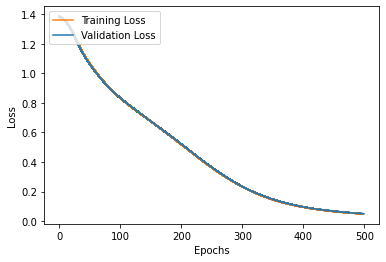

In [58]:
EPOCHS = 500
best_valid_loss = float('inf')
list_train_loss = []
list_val_loss = []

list_train_acc = []
list_val_acc = []

for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, device)
    
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.7f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.7f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    list_val_loss.append(valid_loss)
    list_train_loss.append(train_loss)
    
    list_val_acc.append(valid_acc)
    list_train_acc.append(train_acc)
    
    plt.plot(range(epoch+1),list_train_loss,'tab:orange',label='Training Loss')
    plt.plot(range(epoch+1),list_val_loss,'tab:blue',label='Validation Loss')
    
    if (epoch %20 == 0 or (epoch > 200 and epoch %5 == 0))and valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "linear_classifier_on_latents"+str(epoch)+".p")
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        
print('Finished Training')

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 0.0362862 | Train Acc: 99.21%
	 Val. Loss: 0.0378650 |  Val. Acc: 99.22%


Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 0.0361293 | Train Acc: 99.21%
	 Val. Loss: 0.0376439 |  Val. Acc: 99.21%


Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.0359619 | Train Acc: 99.22%
	 Val. Loss: 0.0374907 |  Val. Acc: 99.21%


Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 0.0357996 | Train Acc: 99.22%
	 Val. Loss: 0.0373233 |  Val. Acc: 99.22%


Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 0.0356392 | Train Acc: 99.22%
	 Val. Loss: 0.0371672 |  Val. Acc: 99.22%


Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.0354841 | Train Acc: 99.22%
	 Val. Loss: 0.0370177 |  Val. Acc: 99.22%


Epoch: 07 | Epoch Time: 0m 12s
	Train Loss: 0.0353179 | Train Acc: 99.24%
	 Val. Loss: 0.0368569 |  Val. Acc: 99.22%


Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 0.0351620 | Train Acc: 99.23%
	 Val. Loss: 0.0367044 |  Val. Acc: 99.22%


Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 0.0350079 | Train Acc: 99.24%
	 Val. Loss: 0.0365555 |  Val. Acc: 99.23%


Epoch: 10 | Epoch Time: 0m 10s
	Train Loss: 0.0348484 | Train Acc: 99.24%
	 Val. Loss: 0.0364060 |  Val. Acc: 99.22%


Epoch: 11 | Epoch Time: 0m 11s
	Train Loss: 0.0346961 | Train Acc: 99.25%
	 Val. Loss: 0.0362541 |  Val. Acc: 99.23%


Epoch: 12 | Epoch Time: 0m 11s
	Train Loss: 0.0345467 | Train Acc: 99.25%
	 Val. Loss: 0.0361167 |  Val. Acc: 99.23%


Epoch: 13 | Epoch Time: 0m 11s
	Train Loss: 0.0343941 | Train Acc: 99.25%
	 Val. Loss: 0.0359643 |  Val. Acc: 99.23%


Epoch: 14 | Epoch Time: 0m 11s
	Train Loss: 0.0342461 | Train Acc: 99.26%
	 Val. Loss: 0.0358221 |  Val. Acc: 99.24%


Epoch: 15 | Epoch Time: 0m 11s
	Train Loss: 0.0340924 | Train Acc: 99.26%
	 Val. Loss: 0.0356666 |  Val. Acc: 99.25%


Epoch: 16 | Epoch Time: 0m 11s
	Train Loss: 0.0339497 | Train Acc: 99.26%
	 Val. Loss: 0.0355269 |  Val. Acc: 99.25%


Epoch: 17 | Epoch Time: 0m 11s
	Train Loss: 0.0338005 | Train Acc: 99.27%
	 Val. Loss: 0.0353863 |  Val. Acc: 99.25%


Epoch: 18 | Epoch Time: 0m 10s
	Train Loss: 0.0336557 | Train Acc: 99.27%
	 Val. Loss: 0.0352383 |  Val. Acc: 99.26%


Epoch: 19 | Epoch Time: 0m 10s
	Train Loss: 0.0335127 | Train Acc: 99.27%
	 Val. Loss: 0.0351110 |  Val. Acc: 99.25%


Epoch: 20 | Epoch Time: 0m 9s
	Train Loss: 0.0333692 | Train Acc: 99.27%
	 Val. Loss: 0.0349725 |  Val. Acc: 99.25%


Epoch: 21 | Epoch Time: 0m 10s
	Train Loss: 0.0332248 | Train Acc: 99.28%
	 Val. Loss: 0.0348318 |  Val. Acc: 99.27%


Epoch: 22 | Epoch Time: 0m 9s
	Train Loss: 0.0330894 | Train Acc: 99.29%
	 Val. Loss: 0.0346957 |  Val. Acc: 99.26%


Epoch: 23 | Epoch Time: 0m 10s
	Train Loss: 0.0329451 | Train Acc: 99.29%
	 Val. Loss: 0.0345656 |  Val. Acc: 99.27%


Epoch: 24 | Epoch Time: 0m 10s
	Train Loss: 0.0328059 | Train Acc: 99.29%
	 Val. Loss: 0.0344267 |  Val. Acc: 99.27%


Epoch: 25 | Epoch Time: 0m 10s
	Train Loss: 0.0326725 | Train Acc: 99.29%
	 Val. Loss: 0.0342881 |  Val. Acc: 99.27%


Epoch: 26 | Epoch Time: 0m 11s
	Train Loss: 0.0325292 | Train Acc: 99.30%
	 Val. Loss: 0.0341628 |  Val. Acc: 99.27%


Epoch: 27 | Epoch Time: 0m 10s
	Train Loss: 0.0323915 | Train Acc: 99.30%
	 Val. Loss: 0.0340419 |  Val. Acc: 99.29%


Epoch: 28 | Epoch Time: 0m 10s
	Train Loss: 0.0322587 | Train Acc: 99.30%
	 Val. Loss: 0.0338823 |  Val. Acc: 99.28%


Epoch: 29 | Epoch Time: 0m 10s
	Train Loss: 0.0321221 | Train Acc: 99.30%
	 Val. Loss: 0.0337567 |  Val. Acc: 99.28%


Epoch: 30 | Epoch Time: 0m 10s
	Train Loss: 0.0319890 | Train Acc: 99.31%
	 Val. Loss: 0.0336426 |  Val. Acc: 99.29%


Epoch: 31 | Epoch Time: 0m 10s
	Train Loss: 0.0318554 | Train Acc: 99.31%
	 Val. Loss: 0.0335076 |  Val. Acc: 99.29%


Epoch: 32 | Epoch Time: 0m 10s
	Train Loss: 0.0317278 | Train Acc: 99.31%
	 Val. Loss: 0.0333661 |  Val. Acc: 99.29%


Epoch: 33 | Epoch Time: 0m 10s
	Train Loss: 0.0315954 | Train Acc: 99.31%
	 Val. Loss: 0.0332471 |  Val. Acc: 99.29%


Epoch: 34 | Epoch Time: 0m 10s
	Train Loss: 0.0314637 | Train Acc: 99.33%
	 Val. Loss: 0.0331203 |  Val. Acc: 99.30%


Epoch: 35 | Epoch Time: 0m 10s
	Train Loss: 0.0313400 | Train Acc: 99.32%
	 Val. Loss: 0.0329875 |  Val. Acc: 99.30%


Epoch: 36 | Epoch Time: 0m 10s
	Train Loss: 0.0312074 | Train Acc: 99.33%
	 Val. Loss: 0.0328768 |  Val. Acc: 99.30%


Epoch: 37 | Epoch Time: 0m 10s
	Train Loss: 0.0310855 | Train Acc: 99.33%
	 Val. Loss: 0.0327623 |  Val. Acc: 99.30%


Epoch: 38 | Epoch Time: 0m 10s
	Train Loss: 0.0309595 | Train Acc: 99.34%
	 Val. Loss: 0.0326290 |  Val. Acc: 99.32%


Epoch: 39 | Epoch Time: 0m 10s
	Train Loss: 0.0308343 | Train Acc: 99.34%
	 Val. Loss: 0.0325270 |  Val. Acc: 99.30%


Epoch: 40 | Epoch Time: 0m 11s
	Train Loss: 0.0307115 | Train Acc: 99.34%
	 Val. Loss: 0.0323886 |  Val. Acc: 99.32%


Epoch: 41 | Epoch Time: 0m 10s
	Train Loss: 0.0305861 | Train Acc: 99.34%
	 Val. Loss: 0.0322654 |  Val. Acc: 99.32%


Epoch: 42 | Epoch Time: 0m 9s
	Train Loss: 0.0304654 | Train Acc: 99.35%
	 Val. Loss: 0.0321426 |  Val. Acc: 99.32%


Epoch: 43 | Epoch Time: 0m 10s
	Train Loss: 0.0303409 | Train Acc: 99.35%
	 Val. Loss: 0.0320439 |  Val. Acc: 99.32%


Epoch: 44 | Epoch Time: 0m 10s
	Train Loss: 0.0302248 | Train Acc: 99.35%
	 Val. Loss: 0.0319166 |  Val. Acc: 99.33%


Epoch: 45 | Epoch Time: 0m 10s
	Train Loss: 0.0301068 | Train Acc: 99.36%
	 Val. Loss: 0.0318005 |  Val. Acc: 99.33%


Epoch: 46 | Epoch Time: 0m 10s
	Train Loss: 0.0299871 | Train Acc: 99.36%
	 Val. Loss: 0.0316848 |  Val. Acc: 99.33%


Epoch: 47 | Epoch Time: 0m 10s
	Train Loss: 0.0298675 | Train Acc: 99.36%
	 Val. Loss: 0.0315667 |  Val. Acc: 99.33%


Epoch: 48 | Epoch Time: 0m 10s
	Train Loss: 0.0297510 | Train Acc: 99.36%
	 Val. Loss: 0.0314601 |  Val. Acc: 99.34%


Epoch: 49 | Epoch Time: 0m 10s
	Train Loss: 0.0296354 | Train Acc: 99.37%
	 Val. Loss: 0.0313469 |  Val. Acc: 99.34%


Epoch: 50 | Epoch Time: 0m 10s
	Train Loss: 0.0295169 | Train Acc: 99.37%
	 Val. Loss: 0.0312348 |  Val. Acc: 99.34%


Epoch: 51 | Epoch Time: 0m 10s
	Train Loss: 0.0294049 | Train Acc: 99.37%
	 Val. Loss: 0.0311216 |  Val. Acc: 99.34%


Epoch: 52 | Epoch Time: 0m 10s
	Train Loss: 0.0292916 | Train Acc: 99.38%
	 Val. Loss: 0.0310067 |  Val. Acc: 99.34%


Epoch: 53 | Epoch Time: 0m 10s
	Train Loss: 0.0291776 | Train Acc: 99.38%
	 Val. Loss: 0.0309086 |  Val. Acc: 99.34%


Epoch: 54 | Epoch Time: 0m 9s
	Train Loss: 0.0290684 | Train Acc: 99.38%
	 Val. Loss: 0.0308022 |  Val. Acc: 99.35%


Epoch: 55 | Epoch Time: 0m 10s
	Train Loss: 0.0289585 | Train Acc: 99.39%
	 Val. Loss: 0.0306897 |  Val. Acc: 99.35%


Epoch: 56 | Epoch Time: 0m 10s
	Train Loss: 0.0288437 | Train Acc: 99.39%
	 Val. Loss: 0.0305774 |  Val. Acc: 99.35%


Epoch: 57 | Epoch Time: 0m 10s
	Train Loss: 0.0287372 | Train Acc: 99.39%
	 Val. Loss: 0.0304693 |  Val. Acc: 99.35%


Epoch: 58 | Epoch Time: 0m 10s
	Train Loss: 0.0286257 | Train Acc: 99.39%
	 Val. Loss: 0.0303724 |  Val. Acc: 99.35%


Epoch: 59 | Epoch Time: 0m 11s
	Train Loss: 0.0285143 | Train Acc: 99.39%
	 Val. Loss: 0.0302723 |  Val. Acc: 99.35%


Epoch: 60 | Epoch Time: 0m 10s
	Train Loss: 0.0284102 | Train Acc: 99.40%
	 Val. Loss: 0.0301705 |  Val. Acc: 99.36%


Epoch: 61 | Epoch Time: 0m 10s
	Train Loss: 0.0283011 | Train Acc: 99.40%
	 Val. Loss: 0.0300595 |  Val. Acc: 99.36%


Epoch: 62 | Epoch Time: 0m 9s
	Train Loss: 0.0282001 | Train Acc: 99.40%
	 Val. Loss: 0.0299563 |  Val. Acc: 99.37%


Epoch: 63 | Epoch Time: 0m 10s
	Train Loss: 0.0280934 | Train Acc: 99.40%
	 Val. Loss: 0.0298491 |  Val. Acc: 99.36%


Epoch: 64 | Epoch Time: 0m 10s
	Train Loss: 0.0279901 | Train Acc: 99.40%
	 Val. Loss: 0.0297546 |  Val. Acc: 99.37%


Epoch: 65 | Epoch Time: 0m 10s
	Train Loss: 0.0278836 | Train Acc: 99.41%
	 Val. Loss: 0.0296403 |  Val. Acc: 99.37%


Epoch: 66 | Epoch Time: 0m 10s
	Train Loss: 0.0277805 | Train Acc: 99.41%
	 Val. Loss: 0.0295476 |  Val. Acc: 99.37%


Epoch: 67 | Epoch Time: 0m 10s
	Train Loss: 0.0276759 | Train Acc: 99.41%
	 Val. Loss: 0.0294520 |  Val. Acc: 99.37%


Epoch: 68 | Epoch Time: 0m 10s
	Train Loss: 0.0275757 | Train Acc: 99.41%
	 Val. Loss: 0.0293527 |  Val. Acc: 99.38%


Epoch: 69 | Epoch Time: 0m 10s
	Train Loss: 0.0274742 | Train Acc: 99.42%
	 Val. Loss: 0.0292596 |  Val. Acc: 99.38%


Epoch: 70 | Epoch Time: 0m 10s
	Train Loss: 0.0273777 | Train Acc: 99.42%
	 Val. Loss: 0.0291504 |  Val. Acc: 99.38%


Epoch: 71 | Epoch Time: 0m 10s
	Train Loss: 0.0272694 | Train Acc: 99.42%
	 Val. Loss: 0.0290620 |  Val. Acc: 99.39%


Epoch: 72 | Epoch Time: 0m 10s
	Train Loss: 0.0271750 | Train Acc: 99.42%
	 Val. Loss: 0.0289720 |  Val. Acc: 99.39%


Epoch: 73 | Epoch Time: 0m 10s
	Train Loss: 0.0270755 | Train Acc: 99.43%
	 Val. Loss: 0.0288639 |  Val. Acc: 99.39%


Epoch: 74 | Epoch Time: 0m 10s
	Train Loss: 0.0269806 | Train Acc: 99.43%
	 Val. Loss: 0.0287755 |  Val. Acc: 99.39%


Epoch: 75 | Epoch Time: 0m 11s
	Train Loss: 0.0268814 | Train Acc: 99.43%
	 Val. Loss: 0.0286792 |  Val. Acc: 99.39%


Epoch: 76 | Epoch Time: 0m 10s
	Train Loss: 0.0267830 | Train Acc: 99.43%
	 Val. Loss: 0.0285876 |  Val. Acc: 99.39%


Epoch: 77 | Epoch Time: 0m 10s
	Train Loss: 0.0266828 | Train Acc: 99.44%
	 Val. Loss: 0.0284966 |  Val. Acc: 99.40%


Epoch: 78 | Epoch Time: 0m 10s
	Train Loss: 0.0265869 | Train Acc: 99.44%
	 Val. Loss: 0.0283947 |  Val. Acc: 99.40%


Epoch: 79 | Epoch Time: 0m 10s
	Train Loss: 0.0264932 | Train Acc: 99.44%
	 Val. Loss: 0.0283074 |  Val. Acc: 99.40%


Epoch: 80 | Epoch Time: 0m 10s
	Train Loss: 0.0264024 | Train Acc: 99.44%
	 Val. Loss: 0.0282098 |  Val. Acc: 99.41%


Epoch: 81 | Epoch Time: 0m 11s
	Train Loss: 0.0263028 | Train Acc: 99.45%
	 Val. Loss: 0.0281300 |  Val. Acc: 99.40%


Epoch: 82 | Epoch Time: 0m 9s
	Train Loss: 0.0262123 | Train Acc: 99.45%
	 Val. Loss: 0.0280363 |  Val. Acc: 99.41%


Epoch: 83 | Epoch Time: 0m 11s
	Train Loss: 0.0261247 | Train Acc: 99.45%
	 Val. Loss: 0.0279403 |  Val. Acc: 99.41%


Epoch: 84 | Epoch Time: 0m 10s
	Train Loss: 0.0260262 | Train Acc: 99.45%
	 Val. Loss: 0.0278596 |  Val. Acc: 99.41%


Epoch: 85 | Epoch Time: 0m 10s
	Train Loss: 0.0259410 | Train Acc: 99.45%
	 Val. Loss: 0.0277659 |  Val. Acc: 99.43%


Epoch: 86 | Epoch Time: 0m 10s
	Train Loss: 0.0258484 | Train Acc: 99.46%
	 Val. Loss: 0.0276724 |  Val. Acc: 99.42%


Epoch: 87 | Epoch Time: 0m 10s
	Train Loss: 0.0257593 | Train Acc: 99.46%
	 Val. Loss: 0.0275933 |  Val. Acc: 99.42%


Epoch: 88 | Epoch Time: 0m 10s
	Train Loss: 0.0256690 | Train Acc: 99.46%
	 Val. Loss: 0.0275090 |  Val. Acc: 99.43%


Epoch: 89 | Epoch Time: 0m 10s
	Train Loss: 0.0255800 | Train Acc: 99.47%
	 Val. Loss: 0.0274343 |  Val. Acc: 99.42%


Epoch: 90 | Epoch Time: 0m 10s
	Train Loss: 0.0254921 | Train Acc: 99.47%
	 Val. Loss: 0.0273420 |  Val. Acc: 99.43%


Epoch: 91 | Epoch Time: 0m 10s
	Train Loss: 0.0254028 | Train Acc: 99.47%
	 Val. Loss: 0.0272498 |  Val. Acc: 99.43%


Epoch: 92 | Epoch Time: 0m 10s
	Train Loss: 0.0253147 | Train Acc: 99.47%
	 Val. Loss: 0.0271739 |  Val. Acc: 99.43%


Epoch: 93 | Epoch Time: 0m 11s
	Train Loss: 0.0252273 | Train Acc: 99.47%
	 Val. Loss: 0.0270840 |  Val. Acc: 99.43%


Epoch: 94 | Epoch Time: 0m 10s
	Train Loss: 0.0251430 | Train Acc: 99.47%
	 Val. Loss: 0.0269955 |  Val. Acc: 99.43%


Epoch: 95 | Epoch Time: 0m 10s
	Train Loss: 0.0250547 | Train Acc: 99.48%
	 Val. Loss: 0.0269163 |  Val. Acc: 99.44%


Epoch: 96 | Epoch Time: 0m 10s
	Train Loss: 0.0249705 | Train Acc: 99.48%
	 Val. Loss: 0.0268278 |  Val. Acc: 99.44%


Epoch: 97 | Epoch Time: 0m 10s
	Train Loss: 0.0248828 | Train Acc: 99.48%
	 Val. Loss: 0.0267513 |  Val. Acc: 99.44%


Epoch: 98 | Epoch Time: 0m 10s
	Train Loss: 0.0248014 | Train Acc: 99.48%
	 Val. Loss: 0.0266646 |  Val. Acc: 99.44%


Epoch: 99 | Epoch Time: 0m 10s
	Train Loss: 0.0247176 | Train Acc: 99.49%
	 Val. Loss: 0.0265892 |  Val. Acc: 99.44%


Epoch: 100 | Epoch Time: 0m 10s
	Train Loss: 0.0246315 | Train Acc: 99.49%
	 Val. Loss: 0.0265116 |  Val. Acc: 99.44%
Finished Training


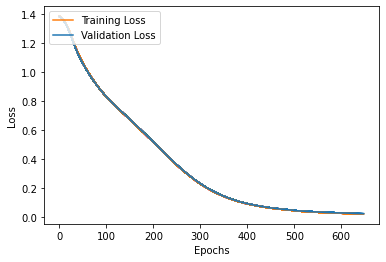

In [71]:
EPOCHS = 100
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, device)
    
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.7f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.7f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    list_val_loss.append(valid_loss)
    list_train_loss.append(train_loss)
    
    list_val_acc.append(valid_acc)
    list_train_acc.append(train_acc)
    
    plt.plot(range(epoch+550),list_train_loss,'tab:orange',label='Training Loss')
    plt.plot(range(epoch+550),list_val_loss,'tab:blue',label='Validation Loss')
    
    if (epoch %20 == 0 or (epoch > 200 and epoch %5 == 0))and valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "linear_classifier_on_latents"+str(epoch)+".p")
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        
print('Finished Training')

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 0.0109620 | Train Acc: 99.79%
	 Val. Loss: 0.0133662 |  Val. Acc: 99.74%


Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 0.0109398 | Train Acc: 99.79%
	 Val. Loss: 0.0133346 |  Val. Acc: 99.75%


Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.0109133 | Train Acc: 99.79%
	 Val. Loss: 0.0133196 |  Val. Acc: 99.75%


Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.0108893 | Train Acc: 99.79%
	 Val. Loss: 0.0132956 |  Val. Acc: 99.75%


Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.0108634 | Train Acc: 99.79%
	 Val. Loss: 0.0132685 |  Val. Acc: 99.75%


Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.0108410 | Train Acc: 99.79%
	 Val. Loss: 0.0132479 |  Val. Acc: 99.75%


Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.0108180 | Train Acc: 99.79%
	 Val. Loss: 0.0132125 |  Val. Acc: 99.75%


Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 0.0107924 | Train Acc: 99.79%
	 Val. Loss: 0.0132090 |  Val. Acc: 99.75%


Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.0107669 | Train Acc: 99.80%
	 Val. Loss: 0.0131770 |  Val. Acc: 99.75%


Epoch: 10 | Epoch Time: 0m 10s
	Train Loss: 0.0107446 | Train Acc: 99.79%
	 Val. Loss: 0.0131489 |  Val. Acc: 99.75%


Epoch: 11 | Epoch Time: 0m 11s
	Train Loss: 0.0107218 | Train Acc: 99.80%
	 Val. Loss: 0.0131207 |  Val. Acc: 99.75%


Epoch: 12 | Epoch Time: 0m 10s
	Train Loss: 0.0106972 | Train Acc: 99.80%
	 Val. Loss: 0.0131066 |  Val. Acc: 99.75%


Epoch: 13 | Epoch Time: 0m 10s
	Train Loss: 0.0106768 | Train Acc: 99.79%
	 Val. Loss: 0.0130790 |  Val. Acc: 99.75%


Epoch: 14 | Epoch Time: 0m 10s
	Train Loss: 0.0106510 | Train Acc: 99.80%
	 Val. Loss: 0.0130565 |  Val. Acc: 99.76%


Epoch: 15 | Epoch Time: 0m 10s
	Train Loss: 0.0106253 | Train Acc: 99.80%
	 Val. Loss: 0.0130385 |  Val. Acc: 99.75%


Epoch: 16 | Epoch Time: 0m 10s
	Train Loss: 0.0106042 | Train Acc: 99.80%
	 Val. Loss: 0.0130063 |  Val. Acc: 99.76%


Epoch: 17 | Epoch Time: 0m 10s
	Train Loss: 0.0105821 | Train Acc: 99.80%
	 Val. Loss: 0.0129980 |  Val. Acc: 99.75%


Epoch: 18 | Epoch Time: 0m 10s
	Train Loss: 0.0105597 | Train Acc: 99.80%
	 Val. Loss: 0.0129635 |  Val. Acc: 99.76%


Epoch: 19 | Epoch Time: 0m 10s
	Train Loss: 0.0105351 | Train Acc: 99.80%
	 Val. Loss: 0.0129445 |  Val. Acc: 99.75%


Epoch: 20 | Epoch Time: 0m 10s
	Train Loss: 0.0105123 | Train Acc: 99.80%
	 Val. Loss: 0.0129184 |  Val. Acc: 99.76%


Epoch: 21 | Epoch Time: 0m 10s
	Train Loss: 0.0104877 | Train Acc: 99.80%
	 Val. Loss: 0.0128991 |  Val. Acc: 99.76%


Epoch: 22 | Epoch Time: 0m 9s
	Train Loss: 0.0104644 | Train Acc: 99.80%
	 Val. Loss: 0.0128799 |  Val. Acc: 99.76%


Epoch: 23 | Epoch Time: 0m 10s
	Train Loss: 0.0104424 | Train Acc: 99.80%
	 Val. Loss: 0.0128419 |  Val. Acc: 99.76%


Epoch: 24 | Epoch Time: 0m 10s
	Train Loss: 0.0104177 | Train Acc: 99.80%
	 Val. Loss: 0.0128340 |  Val. Acc: 99.76%


Epoch: 25 | Epoch Time: 0m 11s
	Train Loss: 0.0103980 | Train Acc: 99.80%
	 Val. Loss: 0.0128112 |  Val. Acc: 99.76%


Epoch: 26 | Epoch Time: 0m 10s
	Train Loss: 0.0103737 | Train Acc: 99.80%
	 Val. Loss: 0.0127904 |  Val. Acc: 99.76%


Epoch: 27 | Epoch Time: 0m 10s
	Train Loss: 0.0103562 | Train Acc: 99.80%
	 Val. Loss: 0.0127588 |  Val. Acc: 99.76%


Epoch: 28 | Epoch Time: 0m 10s
	Train Loss: 0.0103315 | Train Acc: 99.80%
	 Val. Loss: 0.0127326 |  Val. Acc: 99.76%


Epoch: 29 | Epoch Time: 0m 10s
	Train Loss: 0.0103091 | Train Acc: 99.80%
	 Val. Loss: 0.0127140 |  Val. Acc: 99.76%


Epoch: 30 | Epoch Time: 0m 10s
	Train Loss: 0.0102849 | Train Acc: 99.80%
	 Val. Loss: 0.0126936 |  Val. Acc: 99.76%


Epoch: 31 | Epoch Time: 0m 10s
	Train Loss: 0.0102643 | Train Acc: 99.81%
	 Val. Loss: 0.0126743 |  Val. Acc: 99.76%


Epoch: 32 | Epoch Time: 0m 11s
	Train Loss: 0.0102397 | Train Acc: 99.80%
	 Val. Loss: 0.0126670 |  Val. Acc: 99.76%


Epoch: 33 | Epoch Time: 0m 11s
	Train Loss: 0.0102187 | Train Acc: 99.80%
	 Val. Loss: 0.0126364 |  Val. Acc: 99.76%


Epoch: 34 | Epoch Time: 0m 10s
	Train Loss: 0.0101968 | Train Acc: 99.81%
	 Val. Loss: 0.0126099 |  Val. Acc: 99.77%


Epoch: 35 | Epoch Time: 0m 10s
	Train Loss: 0.0101719 | Train Acc: 99.81%
	 Val. Loss: 0.0125786 |  Val. Acc: 99.77%


Epoch: 36 | Epoch Time: 0m 10s
	Train Loss: 0.0101507 | Train Acc: 99.81%
	 Val. Loss: 0.0125680 |  Val. Acc: 99.76%


Epoch: 37 | Epoch Time: 0m 10s
	Train Loss: 0.0101307 | Train Acc: 99.81%
	 Val. Loss: 0.0125400 |  Val. Acc: 99.77%


Epoch: 38 | Epoch Time: 0m 10s
	Train Loss: 0.0101086 | Train Acc: 99.81%
	 Val. Loss: 0.0125306 |  Val. Acc: 99.77%


Epoch: 39 | Epoch Time: 0m 10s
	Train Loss: 0.0100858 | Train Acc: 99.81%
	 Val. Loss: 0.0125053 |  Val. Acc: 99.77%


Epoch: 40 | Epoch Time: 0m 10s
	Train Loss: 0.0100663 | Train Acc: 99.81%
	 Val. Loss: 0.0124780 |  Val. Acc: 99.77%


Epoch: 41 | Epoch Time: 0m 11s
	Train Loss: 0.0100424 | Train Acc: 99.81%
	 Val. Loss: 0.0124617 |  Val. Acc: 99.77%


Epoch: 42 | Epoch Time: 0m 9s
	Train Loss: 0.0100208 | Train Acc: 99.81%
	 Val. Loss: 0.0124312 |  Val. Acc: 99.77%


Epoch: 43 | Epoch Time: 0m 11s
	Train Loss: 0.0099966 | Train Acc: 99.81%
	 Val. Loss: 0.0124146 |  Val. Acc: 99.77%


Epoch: 44 | Epoch Time: 0m 10s
	Train Loss: 0.0099761 | Train Acc: 99.82%
	 Val. Loss: 0.0123981 |  Val. Acc: 99.77%


Epoch: 45 | Epoch Time: 0m 10s
	Train Loss: 0.0099553 | Train Acc: 99.81%
	 Val. Loss: 0.0123675 |  Val. Acc: 99.77%


Epoch: 46 | Epoch Time: 0m 10s
	Train Loss: 0.0099325 | Train Acc: 99.81%
	 Val. Loss: 0.0123483 |  Val. Acc: 99.77%


Epoch: 47 | Epoch Time: 0m 10s
	Train Loss: 0.0099114 | Train Acc: 99.81%
	 Val. Loss: 0.0123303 |  Val. Acc: 99.77%


Epoch: 48 | Epoch Time: 0m 10s
	Train Loss: 0.0098891 | Train Acc: 99.81%
	 Val. Loss: 0.0123071 |  Val. Acc: 99.77%


Epoch: 49 | Epoch Time: 0m 10s
	Train Loss: 0.0098712 | Train Acc: 99.82%
	 Val. Loss: 0.0122864 |  Val. Acc: 99.77%


Epoch: 50 | Epoch Time: 0m 9s
	Train Loss: 0.0098500 | Train Acc: 99.82%
	 Val. Loss: 0.0122579 |  Val. Acc: 99.77%


Epoch: 51 | Epoch Time: 0m 11s
	Train Loss: 0.0098280 | Train Acc: 99.82%
	 Val. Loss: 0.0122339 |  Val. Acc: 99.77%


Epoch: 52 | Epoch Time: 0m 10s
	Train Loss: 0.0098076 | Train Acc: 99.82%
	 Val. Loss: 0.0122208 |  Val. Acc: 99.77%


Epoch: 53 | Epoch Time: 0m 10s
	Train Loss: 0.0097859 | Train Acc: 99.82%
	 Val. Loss: 0.0122036 |  Val. Acc: 99.78%


Epoch: 54 | Epoch Time: 0m 10s
	Train Loss: 0.0097635 | Train Acc: 99.82%
	 Val. Loss: 0.0121831 |  Val. Acc: 99.78%


Epoch: 55 | Epoch Time: 0m 10s
	Train Loss: 0.0097416 | Train Acc: 99.82%
	 Val. Loss: 0.0121607 |  Val. Acc: 99.78%


Epoch: 56 | Epoch Time: 0m 11s
	Train Loss: 0.0097239 | Train Acc: 99.82%
	 Val. Loss: 0.0121402 |  Val. Acc: 99.78%


Epoch: 57 | Epoch Time: 0m 11s
	Train Loss: 0.0097029 | Train Acc: 99.82%
	 Val. Loss: 0.0121119 |  Val. Acc: 99.78%


Epoch: 58 | Epoch Time: 0m 10s
	Train Loss: 0.0096778 | Train Acc: 99.82%
	 Val. Loss: 0.0121109 |  Val. Acc: 99.78%


Epoch: 59 | Epoch Time: 0m 10s
	Train Loss: 0.0096610 | Train Acc: 99.82%
	 Val. Loss: 0.0120707 |  Val. Acc: 99.77%


Epoch: 60 | Epoch Time: 0m 11s
	Train Loss: 0.0096413 | Train Acc: 99.82%
	 Val. Loss: 0.0120493 |  Val. Acc: 99.78%


Epoch: 61 | Epoch Time: 0m 9s
	Train Loss: 0.0096193 | Train Acc: 99.82%
	 Val. Loss: 0.0120290 |  Val. Acc: 99.77%


Epoch: 62 | Epoch Time: 0m 10s
	Train Loss: 0.0095976 | Train Acc: 99.82%
	 Val. Loss: 0.0120184 |  Val. Acc: 99.78%


Epoch: 63 | Epoch Time: 0m 11s
	Train Loss: 0.0095759 | Train Acc: 99.82%
	 Val. Loss: 0.0119853 |  Val. Acc: 99.77%


Epoch: 64 | Epoch Time: 0m 11s
	Train Loss: 0.0095568 | Train Acc: 99.82%
	 Val. Loss: 0.0119833 |  Val. Acc: 99.78%


Epoch: 65 | Epoch Time: 0m 11s
	Train Loss: 0.0095353 | Train Acc: 99.82%
	 Val. Loss: 0.0119478 |  Val. Acc: 99.78%


Epoch: 66 | Epoch Time: 0m 11s
	Train Loss: 0.0095171 | Train Acc: 99.82%
	 Val. Loss: 0.0119280 |  Val. Acc: 99.77%


Epoch: 67 | Epoch Time: 0m 11s
	Train Loss: 0.0094920 | Train Acc: 99.82%
	 Val. Loss: 0.0119125 |  Val. Acc: 99.78%


Epoch: 68 | Epoch Time: 0m 11s
	Train Loss: 0.0094787 | Train Acc: 99.82%
	 Val. Loss: 0.0118824 |  Val. Acc: 99.78%


Epoch: 69 | Epoch Time: 0m 11s
	Train Loss: 0.0094557 | Train Acc: 99.82%
	 Val. Loss: 0.0118604 |  Val. Acc: 99.77%


Epoch: 70 | Epoch Time: 0m 11s
	Train Loss: 0.0094321 | Train Acc: 99.82%
	 Val. Loss: 0.0118516 |  Val. Acc: 99.78%


Epoch: 71 | Epoch Time: 0m 10s
	Train Loss: 0.0094172 | Train Acc: 99.82%
	 Val. Loss: 0.0118217 |  Val. Acc: 99.78%


Epoch: 72 | Epoch Time: 0m 10s
	Train Loss: 0.0093958 | Train Acc: 99.83%
	 Val. Loss: 0.0118074 |  Val. Acc: 99.78%


Epoch: 73 | Epoch Time: 0m 11s
	Train Loss: 0.0093770 | Train Acc: 99.83%
	 Val. Loss: 0.0117801 |  Val. Acc: 99.78%


Epoch: 74 | Epoch Time: 0m 11s
	Train Loss: 0.0093537 | Train Acc: 99.83%
	 Val. Loss: 0.0117611 |  Val. Acc: 99.78%


Epoch: 75 | Epoch Time: 0m 11s
	Train Loss: 0.0093351 | Train Acc: 99.83%
	 Val. Loss: 0.0117445 |  Val. Acc: 99.78%


Epoch: 76 | Epoch Time: 0m 11s
	Train Loss: 0.0093167 | Train Acc: 99.83%
	 Val. Loss: 0.0117180 |  Val. Acc: 99.78%


Epoch: 77 | Epoch Time: 0m 11s
	Train Loss: 0.0092942 | Train Acc: 99.83%
	 Val. Loss: 0.0117015 |  Val. Acc: 99.78%


Epoch: 78 | Epoch Time: 0m 11s
	Train Loss: 0.0092777 | Train Acc: 99.83%
	 Val. Loss: 0.0116949 |  Val. Acc: 99.79%


Epoch: 79 | Epoch Time: 0m 11s
	Train Loss: 0.0092567 | Train Acc: 99.83%
	 Val. Loss: 0.0116699 |  Val. Acc: 99.78%


Epoch: 80 | Epoch Time: 0m 11s
	Train Loss: 0.0092363 | Train Acc: 99.83%
	 Val. Loss: 0.0116475 |  Val. Acc: 99.79%


Epoch: 81 | Epoch Time: 0m 11s
	Train Loss: 0.0092175 | Train Acc: 99.83%
	 Val. Loss: 0.0116235 |  Val. Acc: 99.79%


Epoch: 82 | Epoch Time: 0m 9s
	Train Loss: 0.0091955 | Train Acc: 99.83%
	 Val. Loss: 0.0115987 |  Val. Acc: 99.78%


Epoch: 83 | Epoch Time: 0m 10s
	Train Loss: 0.0091762 | Train Acc: 99.83%
	 Val. Loss: 0.0115829 |  Val. Acc: 99.79%


Epoch: 84 | Epoch Time: 0m 11s
	Train Loss: 0.0091557 | Train Acc: 99.83%
	 Val. Loss: 0.0115631 |  Val. Acc: 99.78%


Epoch: 85 | Epoch Time: 0m 11s
	Train Loss: 0.0091416 | Train Acc: 99.83%
	 Val. Loss: 0.0115421 |  Val. Acc: 99.79%


Epoch: 86 | Epoch Time: 0m 11s
	Train Loss: 0.0091213 | Train Acc: 99.83%
	 Val. Loss: 0.0115183 |  Val. Acc: 99.79%


Epoch: 87 | Epoch Time: 0m 11s
	Train Loss: 0.0091030 | Train Acc: 99.83%
	 Val. Loss: 0.0115073 |  Val. Acc: 99.79%


Epoch: 88 | Epoch Time: 0m 11s
	Train Loss: 0.0090806 | Train Acc: 99.83%
	 Val. Loss: 0.0114985 |  Val. Acc: 99.78%


Epoch: 89 | Epoch Time: 0m 11s
	Train Loss: 0.0090642 | Train Acc: 99.83%
	 Val. Loss: 0.0114580 |  Val. Acc: 99.79%


Epoch: 90 | Epoch Time: 0m 11s
	Train Loss: 0.0090438 | Train Acc: 99.83%
	 Val. Loss: 0.0114393 |  Val. Acc: 99.79%


Epoch: 91 | Epoch Time: 0m 11s
	Train Loss: 0.0090257 | Train Acc: 99.83%
	 Val. Loss: 0.0114195 |  Val. Acc: 99.79%


Epoch: 92 | Epoch Time: 0m 11s
	Train Loss: 0.0090036 | Train Acc: 99.83%
	 Val. Loss: 0.0114225 |  Val. Acc: 99.79%


Epoch: 93 | Epoch Time: 0m 10s
	Train Loss: 0.0089890 | Train Acc: 99.83%
	 Val. Loss: 0.0113932 |  Val. Acc: 99.79%


Epoch: 94 | Epoch Time: 0m 11s
	Train Loss: 0.0089701 | Train Acc: 99.83%
	 Val. Loss: 0.0113660 |  Val. Acc: 99.79%


Epoch: 95 | Epoch Time: 0m 11s
	Train Loss: 0.0089498 | Train Acc: 99.83%
	 Val. Loss: 0.0113498 |  Val. Acc: 99.79%


Epoch: 96 | Epoch Time: 0m 11s
	Train Loss: 0.0089357 | Train Acc: 99.83%
	 Val. Loss: 0.0113275 |  Val. Acc: 99.79%


Epoch: 97 | Epoch Time: 0m 11s
	Train Loss: 0.0089118 | Train Acc: 99.83%
	 Val. Loss: 0.0113141 |  Val. Acc: 99.79%


Epoch: 98 | Epoch Time: 0m 11s
	Train Loss: 0.0088947 | Train Acc: 99.83%
	 Val. Loss: 0.0112979 |  Val. Acc: 99.79%


Epoch: 99 | Epoch Time: 0m 11s
	Train Loss: 0.0088741 | Train Acc: 99.83%
	 Val. Loss: 0.0112658 |  Val. Acc: 99.79%


Epoch: 100 | Epoch Time: 0m 11s
	Train Loss: 0.0088581 | Train Acc: 99.84%
	 Val. Loss: 0.0112516 |  Val. Acc: 99.79%


Epoch: 101 | Epoch Time: 0m 11s
	Train Loss: 0.0088377 | Train Acc: 99.84%
	 Val. Loss: 0.0112392 |  Val. Acc: 99.79%


Epoch: 102 | Epoch Time: 0m 10s
	Train Loss: 0.0088215 | Train Acc: 99.84%
	 Val. Loss: 0.0112153 |  Val. Acc: 99.79%


Epoch: 103 | Epoch Time: 0m 11s
	Train Loss: 0.0088009 | Train Acc: 99.84%
	 Val. Loss: 0.0112121 |  Val. Acc: 99.79%


Epoch: 104 | Epoch Time: 0m 10s
	Train Loss: 0.0087822 | Train Acc: 99.84%
	 Val. Loss: 0.0111876 |  Val. Acc: 99.79%


Epoch: 105 | Epoch Time: 0m 11s
	Train Loss: 0.0087652 | Train Acc: 99.84%
	 Val. Loss: 0.0111586 |  Val. Acc: 99.80%


Epoch: 106 | Epoch Time: 0m 11s
	Train Loss: 0.0087470 | Train Acc: 99.84%
	 Val. Loss: 0.0111456 |  Val. Acc: 99.79%


Epoch: 107 | Epoch Time: 0m 11s
	Train Loss: 0.0087275 | Train Acc: 99.84%
	 Val. Loss: 0.0111409 |  Val. Acc: 99.80%


Epoch: 108 | Epoch Time: 0m 11s
	Train Loss: 0.0087081 | Train Acc: 99.84%
	 Val. Loss: 0.0111045 |  Val. Acc: 99.79%


Epoch: 109 | Epoch Time: 0m 11s
	Train Loss: 0.0086948 | Train Acc: 99.84%
	 Val. Loss: 0.0110891 |  Val. Acc: 99.79%


Epoch: 110 | Epoch Time: 0m 11s
	Train Loss: 0.0086786 | Train Acc: 99.84%
	 Val. Loss: 0.0110765 |  Val. Acc: 99.80%


Epoch: 111 | Epoch Time: 0m 11s
	Train Loss: 0.0086562 | Train Acc: 99.84%
	 Val. Loss: 0.0110534 |  Val. Acc: 99.80%


Epoch: 112 | Epoch Time: 0m 11s
	Train Loss: 0.0086425 | Train Acc: 99.84%
	 Val. Loss: 0.0110316 |  Val. Acc: 99.80%


Epoch: 113 | Epoch Time: 0m 11s
	Train Loss: 0.0086232 | Train Acc: 99.84%
	 Val. Loss: 0.0110218 |  Val. Acc: 99.80%


Epoch: 114 | Epoch Time: 0m 11s
	Train Loss: 0.0086047 | Train Acc: 99.84%
	 Val. Loss: 0.0110022 |  Val. Acc: 99.79%


Epoch: 115 | Epoch Time: 0m 10s
	Train Loss: 0.0085887 | Train Acc: 99.84%
	 Val. Loss: 0.0109702 |  Val. Acc: 99.80%


Epoch: 116 | Epoch Time: 0m 9s
	Train Loss: 0.0085696 | Train Acc: 99.84%
	 Val. Loss: 0.0109555 |  Val. Acc: 99.79%


Epoch: 117 | Epoch Time: 0m 10s
	Train Loss: 0.0085494 | Train Acc: 99.84%
	 Val. Loss: 0.0109472 |  Val. Acc: 99.80%


Epoch: 118 | Epoch Time: 0m 10s
	Train Loss: 0.0085359 | Train Acc: 99.84%
	 Val. Loss: 0.0109264 |  Val. Acc: 99.80%


Epoch: 119 | Epoch Time: 0m 10s
	Train Loss: 0.0085185 | Train Acc: 99.85%
	 Val. Loss: 0.0109351 |  Val. Acc: 99.80%


Epoch: 120 | Epoch Time: 0m 10s
	Train Loss: 0.0085029 | Train Acc: 99.84%
	 Val. Loss: 0.0108890 |  Val. Acc: 99.80%


Epoch: 121 | Epoch Time: 0m 10s
	Train Loss: 0.0084829 | Train Acc: 99.84%
	 Val. Loss: 0.0108738 |  Val. Acc: 99.80%


Epoch: 122 | Epoch Time: 0m 9s
	Train Loss: 0.0084640 | Train Acc: 99.84%
	 Val. Loss: 0.0108502 |  Val. Acc: 99.80%


Epoch: 123 | Epoch Time: 0m 10s
	Train Loss: 0.0084483 | Train Acc: 99.84%
	 Val. Loss: 0.0108425 |  Val. Acc: 99.80%


Epoch: 124 | Epoch Time: 0m 10s
	Train Loss: 0.0084308 | Train Acc: 99.85%
	 Val. Loss: 0.0108253 |  Val. Acc: 99.80%


Epoch: 125 | Epoch Time: 0m 10s
	Train Loss: 0.0084163 | Train Acc: 99.85%
	 Val. Loss: 0.0108067 |  Val. Acc: 99.80%


Epoch: 126 | Epoch Time: 0m 10s
	Train Loss: 0.0084002 | Train Acc: 99.85%
	 Val. Loss: 0.0107940 |  Val. Acc: 99.80%


Epoch: 127 | Epoch Time: 0m 10s
	Train Loss: 0.0083790 | Train Acc: 99.85%
	 Val. Loss: 0.0107664 |  Val. Acc: 99.80%


Epoch: 128 | Epoch Time: 0m 10s
	Train Loss: 0.0083645 | Train Acc: 99.85%
	 Val. Loss: 0.0107474 |  Val. Acc: 99.81%


Epoch: 129 | Epoch Time: 0m 9s
	Train Loss: 0.0083478 | Train Acc: 99.85%
	 Val. Loss: 0.0107231 |  Val. Acc: 99.80%


Epoch: 130 | Epoch Time: 0m 10s
	Train Loss: 0.0083256 | Train Acc: 99.85%
	 Val. Loss: 0.0107119 |  Val. Acc: 99.80%


Epoch: 131 | Epoch Time: 0m 10s
	Train Loss: 0.0083118 | Train Acc: 99.85%
	 Val. Loss: 0.0107014 |  Val. Acc: 99.80%


Epoch: 132 | Epoch Time: 0m 10s
	Train Loss: 0.0082964 | Train Acc: 99.85%
	 Val. Loss: 0.0106808 |  Val. Acc: 99.80%


Epoch: 133 | Epoch Time: 0m 10s
	Train Loss: 0.0082782 | Train Acc: 99.85%
	 Val. Loss: 0.0106585 |  Val. Acc: 99.80%


Epoch: 134 | Epoch Time: 0m 10s
	Train Loss: 0.0082615 | Train Acc: 99.85%
	 Val. Loss: 0.0106430 |  Val. Acc: 99.80%


Epoch: 135 | Epoch Time: 0m 10s
	Train Loss: 0.0082460 | Train Acc: 99.85%
	 Val. Loss: 0.0106244 |  Val. Acc: 99.81%


Epoch: 136 | Epoch Time: 0m 10s
	Train Loss: 0.0082275 | Train Acc: 99.85%
	 Val. Loss: 0.0106070 |  Val. Acc: 99.81%


Epoch: 137 | Epoch Time: 0m 10s
	Train Loss: 0.0082097 | Train Acc: 99.85%
	 Val. Loss: 0.0105915 |  Val. Acc: 99.81%


Epoch: 138 | Epoch Time: 0m 10s
	Train Loss: 0.0081941 | Train Acc: 99.85%
	 Val. Loss: 0.0105790 |  Val. Acc: 99.80%


Epoch: 139 | Epoch Time: 0m 10s
	Train Loss: 0.0081766 | Train Acc: 99.85%
	 Val. Loss: 0.0105557 |  Val. Acc: 99.81%


Epoch: 140 | Epoch Time: 0m 10s
	Train Loss: 0.0081609 | Train Acc: 99.85%
	 Val. Loss: 0.0105420 |  Val. Acc: 99.81%


Epoch: 141 | Epoch Time: 0m 10s
	Train Loss: 0.0081461 | Train Acc: 99.85%
	 Val. Loss: 0.0105200 |  Val. Acc: 99.81%


Epoch: 142 | Epoch Time: 0m 10s
	Train Loss: 0.0081310 | Train Acc: 99.85%
	 Val. Loss: 0.0105056 |  Val. Acc: 99.80%


Epoch: 143 | Epoch Time: 0m 10s
	Train Loss: 0.0081110 | Train Acc: 99.86%
	 Val. Loss: 0.0104890 |  Val. Acc: 99.81%


Epoch: 144 | Epoch Time: 0m 10s
	Train Loss: 0.0080961 | Train Acc: 99.85%
	 Val. Loss: 0.0104921 |  Val. Acc: 99.81%


Epoch: 145 | Epoch Time: 0m 11s
	Train Loss: 0.0080795 | Train Acc: 99.85%
	 Val. Loss: 0.0104545 |  Val. Acc: 99.81%


Epoch: 146 | Epoch Time: 0m 10s
	Train Loss: 0.0080629 | Train Acc: 99.86%
	 Val. Loss: 0.0104373 |  Val. Acc: 99.81%


Epoch: 147 | Epoch Time: 0m 10s
	Train Loss: 0.0080497 | Train Acc: 99.85%
	 Val. Loss: 0.0104253 |  Val. Acc: 99.81%


Epoch: 148 | Epoch Time: 0m 10s
	Train Loss: 0.0080313 | Train Acc: 99.86%
	 Val. Loss: 0.0104093 |  Val. Acc: 99.81%


Epoch: 149 | Epoch Time: 0m 10s
	Train Loss: 0.0080166 | Train Acc: 99.86%
	 Val. Loss: 0.0103839 |  Val. Acc: 99.81%


Epoch: 150 | Epoch Time: 0m 10s
	Train Loss: 0.0079994 | Train Acc: 99.86%
	 Val. Loss: 0.0103712 |  Val. Acc: 99.81%


Epoch: 151 | Epoch Time: 0m 10s
	Train Loss: 0.0079844 | Train Acc: 99.86%
	 Val. Loss: 0.0103604 |  Val. Acc: 99.81%


Epoch: 152 | Epoch Time: 0m 11s
	Train Loss: 0.0079681 | Train Acc: 99.86%
	 Val. Loss: 0.0103463 |  Val. Acc: 99.81%


Epoch: 153 | Epoch Time: 0m 10s
	Train Loss: 0.0079543 | Train Acc: 99.86%
	 Val. Loss: 0.0103254 |  Val. Acc: 99.81%


Epoch: 154 | Epoch Time: 0m 10s
	Train Loss: 0.0079370 | Train Acc: 99.86%
	 Val. Loss: 0.0103108 |  Val. Acc: 99.81%


Epoch: 155 | Epoch Time: 0m 11s
	Train Loss: 0.0079207 | Train Acc: 99.86%
	 Val. Loss: 0.0102893 |  Val. Acc: 99.81%


Epoch: 156 | Epoch Time: 0m 10s
	Train Loss: 0.0079068 | Train Acc: 99.86%
	 Val. Loss: 0.0102702 |  Val. Acc: 99.82%


Epoch: 157 | Epoch Time: 0m 10s
	Train Loss: 0.0078889 | Train Acc: 99.86%
	 Val. Loss: 0.0102562 |  Val. Acc: 99.81%


Epoch: 158 | Epoch Time: 0m 10s
	Train Loss: 0.0078740 | Train Acc: 99.86%
	 Val. Loss: 0.0102411 |  Val. Acc: 99.81%


Epoch: 159 | Epoch Time: 0m 11s
	Train Loss: 0.0078591 | Train Acc: 99.86%
	 Val. Loss: 0.0102334 |  Val. Acc: 99.81%


Epoch: 160 | Epoch Time: 0m 10s
	Train Loss: 0.0078416 | Train Acc: 99.86%
	 Val. Loss: 0.0102152 |  Val. Acc: 99.81%


Epoch: 161 | Epoch Time: 0m 10s
	Train Loss: 0.0078260 | Train Acc: 99.86%
	 Val. Loss: 0.0102054 |  Val. Acc: 99.81%


Epoch: 162 | Epoch Time: 0m 10s
	Train Loss: 0.0078113 | Train Acc: 99.86%
	 Val. Loss: 0.0101756 |  Val. Acc: 99.82%


Epoch: 163 | Epoch Time: 0m 10s
	Train Loss: 0.0077951 | Train Acc: 99.86%
	 Val. Loss: 0.0101655 |  Val. Acc: 99.81%


Epoch: 164 | Epoch Time: 0m 10s
	Train Loss: 0.0077812 | Train Acc: 99.86%
	 Val. Loss: 0.0101462 |  Val. Acc: 99.82%


Epoch: 165 | Epoch Time: 0m 11s
	Train Loss: 0.0077676 | Train Acc: 99.86%
	 Val. Loss: 0.0101322 |  Val. Acc: 99.82%


Epoch: 166 | Epoch Time: 0m 10s
	Train Loss: 0.0077490 | Train Acc: 99.86%
	 Val. Loss: 0.0101120 |  Val. Acc: 99.82%


Epoch: 167 | Epoch Time: 0m 10s
	Train Loss: 0.0077374 | Train Acc: 99.86%
	 Val. Loss: 0.0100914 |  Val. Acc: 99.82%


Epoch: 168 | Epoch Time: 0m 9s
	Train Loss: 0.0077218 | Train Acc: 99.86%
	 Val. Loss: 0.0100816 |  Val. Acc: 99.82%


Epoch: 169 | Epoch Time: 0m 9s
	Train Loss: 0.0077059 | Train Acc: 99.86%
	 Val. Loss: 0.0100578 |  Val. Acc: 99.82%


Epoch: 170 | Epoch Time: 0m 9s
	Train Loss: 0.0076905 | Train Acc: 99.86%
	 Val. Loss: 0.0100510 |  Val. Acc: 99.82%


Epoch: 171 | Epoch Time: 0m 9s
	Train Loss: 0.0076758 | Train Acc: 99.86%
	 Val. Loss: 0.0100351 |  Val. Acc: 99.82%


Epoch: 172 | Epoch Time: 0m 9s
	Train Loss: 0.0076601 | Train Acc: 99.86%
	 Val. Loss: 0.0100236 |  Val. Acc: 99.82%


Epoch: 173 | Epoch Time: 0m 10s
	Train Loss: 0.0076448 | Train Acc: 99.86%
	 Val. Loss: 0.0100053 |  Val. Acc: 99.82%


Epoch: 174 | Epoch Time: 0m 10s
	Train Loss: 0.0076284 | Train Acc: 99.86%
	 Val. Loss: 0.0099862 |  Val. Acc: 99.82%


Epoch: 175 | Epoch Time: 0m 10s
	Train Loss: 0.0076157 | Train Acc: 99.87%
	 Val. Loss: 0.0099753 |  Val. Acc: 99.82%


Epoch: 176 | Epoch Time: 0m 10s
	Train Loss: 0.0075972 | Train Acc: 99.87%
	 Val. Loss: 0.0099784 |  Val. Acc: 99.82%


Epoch: 177 | Epoch Time: 0m 10s
	Train Loss: 0.0075842 | Train Acc: 99.87%
	 Val. Loss: 0.0099475 |  Val. Acc: 99.82%


Epoch: 178 | Epoch Time: 0m 10s
	Train Loss: 0.0075734 | Train Acc: 99.87%
	 Val. Loss: 0.0099250 |  Val. Acc: 99.82%


Epoch: 179 | Epoch Time: 0m 10s
	Train Loss: 0.0075564 | Train Acc: 99.86%
	 Val. Loss: 0.0099104 |  Val. Acc: 99.82%


Epoch: 180 | Epoch Time: 0m 10s
	Train Loss: 0.0075408 | Train Acc: 99.87%
	 Val. Loss: 0.0098909 |  Val. Acc: 99.82%


Epoch: 181 | Epoch Time: 0m 10s
	Train Loss: 0.0075250 | Train Acc: 99.87%
	 Val. Loss: 0.0098783 |  Val. Acc: 99.82%


Epoch: 182 | Epoch Time: 0m 9s
	Train Loss: 0.0075109 | Train Acc: 99.86%
	 Val. Loss: 0.0098778 |  Val. Acc: 99.82%


Epoch: 183 | Epoch Time: 0m 9s
	Train Loss: 0.0074975 | Train Acc: 99.87%
	 Val. Loss: 0.0098553 |  Val. Acc: 99.82%


Epoch: 184 | Epoch Time: 0m 10s
	Train Loss: 0.0074855 | Train Acc: 99.87%
	 Val. Loss: 0.0098319 |  Val. Acc: 99.82%


Epoch: 185 | Epoch Time: 0m 10s
	Train Loss: 0.0074670 | Train Acc: 99.87%
	 Val. Loss: 0.0098304 |  Val. Acc: 99.82%


Epoch: 186 | Epoch Time: 0m 10s
	Train Loss: 0.0074526 | Train Acc: 99.87%
	 Val. Loss: 0.0098018 |  Val. Acc: 99.82%


Epoch: 187 | Epoch Time: 0m 10s
	Train Loss: 0.0074422 | Train Acc: 99.87%
	 Val. Loss: 0.0097915 |  Val. Acc: 99.82%


Epoch: 188 | Epoch Time: 0m 11s
	Train Loss: 0.0074227 | Train Acc: 99.87%
	 Val. Loss: 0.0097768 |  Val. Acc: 99.82%


Epoch: 189 | Epoch Time: 0m 10s
	Train Loss: 0.0074075 | Train Acc: 99.87%
	 Val. Loss: 0.0097734 |  Val. Acc: 99.82%


Epoch: 190 | Epoch Time: 0m 10s
	Train Loss: 0.0073979 | Train Acc: 99.87%
	 Val. Loss: 0.0097434 |  Val. Acc: 99.82%


Epoch: 191 | Epoch Time: 0m 10s
	Train Loss: 0.0073816 | Train Acc: 99.87%
	 Val. Loss: 0.0097257 |  Val. Acc: 99.82%


Epoch: 192 | Epoch Time: 0m 10s
	Train Loss: 0.0073649 | Train Acc: 99.87%
	 Val. Loss: 0.0097005 |  Val. Acc: 99.82%


Epoch: 193 | Epoch Time: 0m 10s
	Train Loss: 0.0073520 | Train Acc: 99.87%
	 Val. Loss: 0.0096986 |  Val. Acc: 99.82%


Epoch: 194 | Epoch Time: 0m 10s
	Train Loss: 0.0073348 | Train Acc: 99.87%
	 Val. Loss: 0.0096837 |  Val. Acc: 99.82%


Epoch: 195 | Epoch Time: 0m 10s
	Train Loss: 0.0073258 | Train Acc: 99.87%
	 Val. Loss: 0.0096754 |  Val. Acc: 99.83%


Epoch: 196 | Epoch Time: 0m 10s
	Train Loss: 0.0073126 | Train Acc: 99.87%
	 Val. Loss: 0.0096530 |  Val. Acc: 99.83%


Epoch: 197 | Epoch Time: 0m 10s
	Train Loss: 0.0072986 | Train Acc: 99.87%
	 Val. Loss: 0.0096521 |  Val. Acc: 99.83%


Epoch: 198 | Epoch Time: 0m 10s
	Train Loss: 0.0072825 | Train Acc: 99.87%
	 Val. Loss: 0.0096290 |  Val. Acc: 99.83%


Epoch: 199 | Epoch Time: 0m 10s
	Train Loss: 0.0072688 | Train Acc: 99.87%
	 Val. Loss: 0.0096128 |  Val. Acc: 99.83%


Epoch: 200 | Epoch Time: 0m 10s
	Train Loss: 0.0072548 | Train Acc: 99.87%
	 Val. Loss: 0.0095940 |  Val. Acc: 99.83%
Finished Training


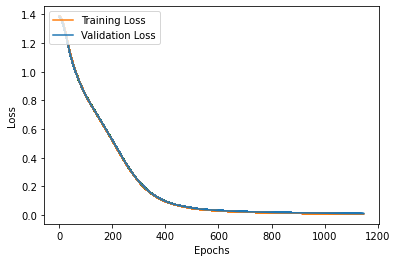

In [73]:
EPOCHS = 200
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, device)
    
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.7f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.7f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    list_val_loss.append(valid_loss)
    list_train_loss.append(train_loss)
    
    list_val_acc.append(valid_acc)
    list_train_acc.append(train_acc)
    
    plt.plot(range(epoch+950),list_train_loss,'tab:orange',label='Training Loss')
    plt.plot(range(epoch+950),list_val_loss,'tab:blue',label='Validation Loss')
    
    if (epoch %20 == 0 or (epoch > 200 and epoch %5 == 0))and valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "./LatentLinearClassifier/linear_classifier_on_latents"+str(epoch)+".p")
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        
print('Finished Training')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


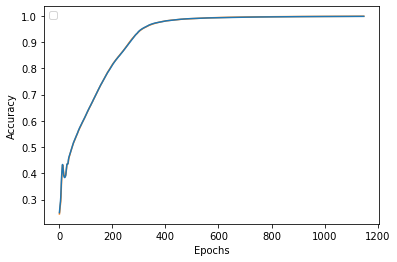

In [75]:
plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(range(len(list_train_acc)),list_train_acc,'tab:orange',label='Training Accuracy')
plt.plot(range(len(list_val_acc)),list_val_acc,'tab:blue',label='Validation Accuracy')

In [ ]:
groupHI = ['17202339_a', '17202342_a', '17202346_a', '17202341_a','17202345_b', '17202338_b', '17202346_c', '17202345_c', '17202339_c', '17202342_c', '17202342_d', '6394837_d']
groupLOW = ['17202338_a', '17202345_a', '17202346_b', '17202346_b', '17202341_b', '17202339_b','17202342_b','17202341_c', '17202338_c', '17202341_d', '17202339_d', '6394836_d', '6394841_d']

In [76]:
final_training_list[0]

'/media/data_cifs/anagara8/preexposure/FC-D_preexposure_W1_06-01-2019_comp2video_2019Y_06M_02D_12h_49m_27s_cam_6394839-0000_525.jpg'

In [128]:
# Returns Cohort Name and Animal ID
def get_video_details(file_name):
    # Get cohort name
    cohort_name = file_name.split("FC-")[-1][0].lower()
    animal_id = file_name.split("cam_")[-1].split("-")[0]
    return cohort_name, animal_id

In [129]:
get_video_details(final_training_list[0])

('c', '17202338')

### Testing

In [130]:
len(final_training_list)

5415872

In [131]:
random.seed(42)
testing_samples = 2000000
test_list = random.sample(final_training_list, testing_samples)

In [138]:
model2 = newAE(32)
model2 = nn.DataParallel(model2)
model2 = model2.cuda()
model2.load_state_dict(torch.load("new_architecture_MSE_e2400.p"))
model2.eval()

DataParallel(
  (module): newAE(
    (encoder): ResNet18Enc(
      (ResNet18): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [ ]:
test_latent_array = []
test_label_array = []
image_count = 0

for image in test_list:
    image_count += 1
    if image_count % 10000 == 0:
        print("Processed", image_count, "Images..")
    name = image
    image = cv2.imread(image)
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
    tensor_frame = torchvision.transforms.functional.to_tensor(image).unsqueeze(0).cuda()
    with torch.no_grad():
        latent_representation = model2.module.encoder(tensor_frame)
    test_latent_array.append(latent_representation.squeeze().cpu().numpy())
    
    # Append One Hot encoded Labels
    if "preexposure" in name:
        test_label_array.append([1.0, 0.0, 0.0, 0.0])
    elif "postcond" in name:
        test_label_array.append([0.0, 1.0, 0.0, 0.0])
    elif "postext" in name:
        test_label_array.append([0.0, 0.0, 1.0, 0.0])
    elif "postret" in name:
        test_label_array.append([0.0, 0.0, 0.0, 1.0])
    else:
        print("ERROR: Incorrect Experiment Phase, no label associated.")

Processed 10000 Images..
Processed 20000 Images..
Processed 30000 Images..
Processed 40000 Images..
Processed 50000 Images..
Processed 60000 Images..
Processed 70000 Images..
Processed 80000 Images..
Processed 90000 Images..
Processed 100000 Images..
Processed 110000 Images..
Processed 120000 Images..
Processed 130000 Images..


In [154]:
test_label_array[0]

[0.0, 0.0, 1.0, 0.0]

In [155]:
# Save Test Latents
# np.save("shuffledTestLatents1_2mil.npy", test_latent_array)
# np.save("shuffledTestLabels1_2mil.npy", test_label_array)

# Load Test Latents
# test_latent_array = np.load("shuffledTestLatents200k.npy")
# test_label_array = np.load("shuffledTestLabels200k.npy")

In [156]:
# Testing Dataset
batch_size = 512
test_data = list(zip(test_latent_array, test_label_array))
test_dataset = LatentDataset(test_data)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers = 4, shuffle=True)

In [187]:
# Loading pre-trained Model
model.load_state_dict(torch.load("LatentLinearClassifier/linear_classifier_on_latents180.p"))

<All keys matched successfully>

In [188]:
def test(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    
    predictions = []
    targets = []

    model.eval()
    with torch.no_grad():
        for sample in tqdm(iterator, desc="Testing", leave=False):
            latent, label = sample
        
            latent = latent.to(device)
            label = label.squeeze().to(device)
            
            y_pred = model(latent)

            loss = criterion(y_pred, label)
            acc = calculate_accuracy(y_pred, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            targets.append(label)
            predictions.append(y_pred)

    return epoch_loss / len(iterator), epoch_acc / len(iterator), predictions, targets

In [ ]:
# Testing the model
start_time = time.monotonic()
test_loss, test_acc, predictions, target = test(model, test_loader, criterion, device)

end_time = time.monotonic()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)

# list_test_loss.append(test_loss)
# list_test_acc.append(test_acc)
        
print('Finished Testing in', end_time-start_time, "seconds")

Testing:  97%|█████████████████████████████▏| 2299/2367 [11:13<00:20,  3.37it/s]

In [165]:
print("Test Loss:", test_loss, " Test Acc:", test_acc)

Test Loss: 0.008994155998975606  Test Acc: 0.9981236137515843


In [160]:
test_predictions = []
test_targets = []

for prediction_batch in predictions:
    for prediction in prediction_batch:
        test_predictions.append(torch.argmax(prediction, dim = 0).cpu().numpy())
        
for target_batch in target:
    for target in target_batch:
        test_targets.append(torch.argmax(target, dim = 0).cpu().numpy())

In [161]:
len(test_predictions)

1211418

In [162]:
len(test_targets)

1211418

In [163]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(test_targets, test_predictions)

print(cf_matrix)

[[302652    126     14      2]
 [    66 301992    420    655]
 [    10    267 302208     35]
 [    16    591     72 302292]]


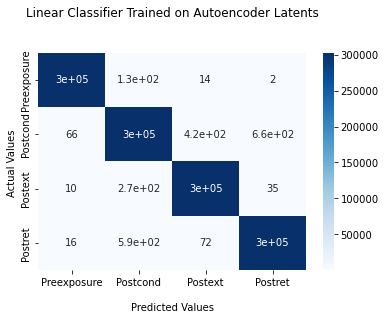

In [164]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Linear Classifier Trained on Autoencoder Latents\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Preexposure', 'Postcond', 'Postext', 'Postret'])
ax.yaxis.set_ticklabels(['Preexposure', 'Postcond', 'Postext', 'Postret'])

plt.show()

In [169]:
len(postret_frames)

108000

In [202]:
test_latent_array1 = []
test_label_array1 = []
image_count = 0

for image in postret_frames:
    test_latent_array1.append(image)
    test_label_array1.append([0.0, 0.0, 0.0, 1.0])
    
#     # Append One Hot encoded Labels
#     if "preexposure" in name:
#         test_label_array.append([1.0, 0.0, 0.0, 0.0])
#     elif "postcond" in name:
#         test_label_array.append([0.0, 1.0, 0.0, 0.0])
#     elif "postext" in name:
#         test_label_array.append([0.0, 0.0, 1.0, 0.0])
#     elif "postret" in name:
#         test_label_array.append([0.0, 0.0, 0.0, 1.0])
#     else:
#         print("ERROR: Incorrect Experiment Phase, no label associated.")

In [203]:
# Testing Dataset
batch_size = 512
test_data1 = list(zip(test_latent_array1, test_label_array1))
test_dataset1 = LatentDataset(test_data1)
test_loader1 = torch.utils.data.DataLoader(test_dataset1, batch_size=batch_size, num_workers = 4, shuffle=True)

In [204]:
test_loss, test_acc, predictions, target = test(model, test_loader1, criterion, device)

In [211]:
test_acc

1.0

In [206]:
target

[tensor([[0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.]], device='cuda:0'),
 tensor([[0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.]], device='cuda:0'),
 tensor([[0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.]], device='cuda:0'),
 tensor([[0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.]], device='cuda:0'),
 tensor([[0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.]], device='cuda:0'),
 tensor([[0., 0., 0., 1.]

In [207]:
predictions

[tensor([[-15.7567,  -8.2774,  -0.4505,   9.1718],
         [-19.7974,  -6.6038,   0.6786,   9.0314],
         [-14.2558,  -6.0932,  -1.4723,   6.2665],
         ...,
         [-18.1802,  -7.4583,   0.1982,   9.0515],
         [-14.4130,  -3.5456,  -1.6689,   4.0868],
         [-15.8870,  -7.2413,  -0.0801,   7.7218]], device='cuda:0'),
 tensor([[-18.1755,  -4.6445,  -0.3468,   6.7292],
         [-16.3834,  -5.6269,  -0.4334,   6.5208],
         [-13.9012,  -6.0059,  -1.6584,   6.1534],
         ...,
         [-14.8896,  -5.4000,  -2.1686,   7.4539],
         [-15.5404,  -8.1145,  -0.5592,   8.5327],
         [-15.8439,  -8.3604,  -0.4811,   9.1597]], device='cuda:0'),
 tensor([[-16.4140,  -8.4443,  -0.3527,   9.5169],
         [-17.9686,  -6.7561,   0.5107,   8.2796],
         [-16.8305,  -5.0370,  -0.7066,   6.4831],
         ...,
         [-14.5978,  -6.9271,  -1.4771,   7.7785],
         [-16.3254,  -6.1056,  -0.4235,   7.3576],
         [-20.5585,  -6.7082,   1.2746,   8.9856]], d